In [20]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import sys
import nltk
import numpy as np
import sklearn
import warnings
warnings.filterwarnings("ignore")
import string
import contractions
from nltk.corpus import stopwords, wordnet
import pickle
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

In [21]:
df = pd.read_csv(r'qa_senti_analysis.csv',encoding='latin1')
df.head()

freshdesk_id  \
0          2073   
1          2074   
2          2075   
3          2076   
4          2077   

                                                                                      title  \
0                        LMS content issue reported for Presentation_PPT of DevOps Workshop   
1         LMS content issue reported for Presentation_PPT of Ansible Certification Training   
2  LMS content issue reported for Presentation - Random Forest_PPT of Data Science Workshop   
3                                                  When will the grades be out for the PGP?   
4                        LMS content issue reported for Presentation_PPT of DevOps Workshop   

           created  \
0  4/24/2020 12:08   
1  4/24/2020 12:15   
2  4/24/2020 12:05   
3  4/24/2020 12:15   
4  4/24/2020 12:16   

                                                                                         clean_content  \
0  Dear IRD Team -<br><br><br />                    User barath.star81@gmail.com has raised a query...   
1  Dear IRD Team -<br><br><br />                    User version@tech.edureka.in has raised a query...   
2  Dear IRD Team -<br><br><br />                    User barath.star81@gmail.com has raised a query...   
3                        I have submitted the final project When will the evaluation process complete?   
4  Dear IRD Team -<br><br><br />                    User barath.star81@gmail.com has raised a query...   

  happiness_rating  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [22]:
df.isna().sum()

freshdesk_id             0
title                   18
created                  0
clean_content         2916
happiness_rating    375858
dtype: int64

In [23]:
df.dropna(subset=["clean_content"],inplace=True)
df.isna().sum()

freshdesk_id             0
title                   17
created                  0
clean_content            0
happiness_rating    373149
dtype: int64

In [97]:
df1 = df[['freshdesk_id','clean_content','happiness_rating']]
df1

freshdesk_id  \
0               2073   
1               2074   
2               2075   
3               2076   
4               2077   
...              ...   
436028       1020408   
436029       1020409   
436030       1020410   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
0       Dear IRD Team -<br><br><br />                    User barath.star81@gmail.com has raised a query...   
1       Dear IRD Team -<br><br><br />                    User version@tech.edureka.in has raised a query...   
2       Dear IRD Team -<br><br><br />                    User barath.star81@gmail.com has raised a query...   
3                             I have submitted the final project When will the evaluation process complete?   
4       Dear IRD Team -<br><br><br />                    User barath.star81@gmail.com has raised a query...   
...                                                                                                     ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436030  Dear IRD Team -<br><br><br />                    User sbonageri@gmail.com has raised a query wit...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
...                 ...  
436028              NaN  
436029              NaN  
436030              NaN  
436031              NaN  
436032              NaN  

[433117 rows x 3 columns]

In [98]:
df1.drop(df1[df1['clean_content'].str.contains("Dear IRD Team")].index,inplace = True)
df1.drop(df1[df1['clean_content'].str.contains("dear team")].index,inplace = True)
df1.drop(df1[df1['clean_content'].str.contains("sdddddddddddddddd")].index,inplace = True)
df1.drop(df1[df1['clean_content'].str.contains("Content URL:https://wwwupload.s3.amazonaws.com/Library%2F2roi4.ipynb")].index,inplace = True)
df1.drop(df1[df1['clean_content'].str.contains("/Users/")].index,inplace = True)

df1['clean_content'] = df1['clean_content'].str.replace(r'\s+', ' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  
3                   NaN  
6                   NaN  
9                   NaN  
11                  NaN  
13                 Good  
...                 ...  
436027              NaN  
436028              NaN  
436029              NaN  
436031              NaN  
436032              NaN  

[421829 rows x 3 columns]

In [10]:
#df1.reset_index(drop=True)

In [11]:
#spec_chars = ["!",'"',"#","%","&","'","(",")",
             # "*","+",",","-",".","/",":",";","<",
            #  "=",">","?","@","[","\\","]","^","_",
             # "`","{","|","}","~","–","?","<br>","<br/>"]
#for char in spec_chars:
    #df1['title'] = df['clean_content'].str.replace(char, ' ')

#df1

In [99]:
df1['no_contract'] = df1['clean_content'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]  
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...  
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...  
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...  
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...  
...                                                                                                     ...  
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...  
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]  
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...  
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]  
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]  

[421829 rows x 4 columns]

In [100]:
df1['clean_content_str'] = [' '.join(map(str, l)) for l in df1['no_contract']]
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                             I have submitted the final project When will the evaluation process complete?  
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...  
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once as soon as possi...  
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...  
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...  
...                                                                 

In [101]:
# use regular expressions to replace email addresses, URLs, phone numbers, other numbers

# Replace email addresses with 'email'
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+",' ')

df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                             I have submitted the final project When will the evaluation process complete?  
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...  
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once as soon as possi...  
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...  
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...  
...                                                                 

In [102]:
# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'£|\$', ' ')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                             I have submitted the final project When will the evaluation process complete?  
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...  
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once as soon as possi...  
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...  
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...  
...                                                                 

In [103]:
# Remove punctuation
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'^\s+|\s+?$', '')

# change words to lower case - Hello, HELLO, hello are all the same word
df1['clean_content_str'] = df1['clean_content_str'].str.lower()

df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6       hi team br br i opted for a full stack web development course on wednesday 22nd april and after ...  
9       hi team br i am unable to play 2nd recording video br could you check once as soon as possible b...  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13      hi team br br i am facing difficulty in submitting the below question while execution it gives n...  
...                                                                 

In [104]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r" br ",' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6       hi team br i opted for a full stack web development course on wednesday 22nd april and after enr...  
9       hi team i am unable to play 2nd recording video could you check once as soon as possible br than...  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13      hi team br i am facing difficulty in submitting the below question while execution it gives no e...  
...                                                                 

In [105]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6       hi team br i opted for a full stack web development course on wednesday 22nd april and after enr...  
9       hi team i am unable to play 2nd recording video could you check once as soon as possible br than...  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13      hi team br i am facing difficulty in submitting the below question while execution it gives no e...  
...                                                                 

In [106]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r" br ",' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6       hi team i opted for a full stack web development course on wednesday 22nd april and after enroll...  
9       hi team i am unable to play 2nd recording video could you check once as soon as possible thanks ...  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13      hi team i am facing difficulty in submitting the below question while execution it gives no erro...  
...                                                                 

In [110]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r" br br",' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6       hi team i opted for a full stack web development course on wednesday 22nd april and after enroll...  
9       hi team i am unable to play 2nd recording video could you check once as soon as possible thanks ...  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13      hi team i am facing difficulty in submitting the below question while execution it gives no erro...  
...                                                                 

In [112]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r" br ",' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6       hi team i opted for a full stack web development course on wednesday 22nd april and after enroll...  
9       hi team i am unable to play 2nd recording video could you check once as soon as possible thanks ...  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13      hi team i am facing difficulty in submitting the below question while execution it gives no erro...  
...                                                                 

In [115]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r"div style font size 13px font family regular lato arial helvetica sans serif ",' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6       hi team i opted for a full stack web development course on wednesday 22nd april and after enroll...  
9       hi team i am unable to play 2nd recording video could you check once as soon as possible thanks ...  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13      hi team i am facing difficulty in submitting the below question while execution it gives no erro...  
...                                                                 

In [117]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r"div span class x_690327091size style font size 16px line height normal ",' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6       hi team i opted for a full stack web development course on wednesday 22nd april and after enroll...  
9       hi team i am unable to play 2nd recording video could you check once as soon as possible thanks ...  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13      hi team i am facing difficulty in submitting the below question while execution it gives no erro...  
...                                                                 

In [119]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r" div ",' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6       hi team i opted for a full stack web development course on wednesday 22nd april and after enroll...  
9       hi team i am unable to play 2nd recording video could you check once as soon as possible thanks ...  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13      hi team i am facing difficulty in submitting the below question while execution it gives no erro...  
...                                                                 

In [121]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r"^div ",' ')t div div div 
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6       hi team i opted for a full stack web development course on wednesday 22nd april and after enroll...  
9       hi team i am unable to play 2nd recording video could you check once as soon as possible thanks ...  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13      hi team i am facing difficulty in submitting the below question while execution it gives no erro...  
...                                                                 

In [123]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r" div div div ",' ') div div 
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6       hi team i opted for a full stack web development course on wednesday 22nd april and after enroll...  
9       hi team i am unable to play 2nd recording video could you check once as soon as possible thanks ...  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13      hi team i am facing difficulty in submitting the below question while execution it gives no erro...  
...                                                                 

In [127]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r" div div",' ') div 
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6       hi team i opted for a full stack web development course on wednesday 22nd april and after enroll...  
9       hi team i am unable to play 2nd recording video could you check once as soon as possible thanks ...  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13      hi team i am facing difficulty in submitting the below question while execution it gives no erro...  
...                                                                 

In [131]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r" div ",' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6       hi team i opted for a full stack web development course on wednesday 22nd april and after enroll...  
9       hi team i am unable to play 2nd recording video could you check once as soon as possible thanks ...  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13      hi team i am facing difficulty in submitting the below question while execution it gives no erro...  
...                                                                 

In [132]:
c = df1[df1['clean_content_str'].str.contains(" div ")]
c

Empty DataFrame
Columns: [freshdesk_id, clean_content, happiness_rating, no_contract, clean_content_str]
Index: []

In [ ]:
#df1['clean_content'] = df1['clean_content'].str.replace(r'^URL:https://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','')
#df1['clean_content'] = df1['clean_content'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','')
#df1['clean_content'] = df1['clean_content'].str.replace(r'\s+', ' ')
#df1

In [133]:
# Replace numbers with ''
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\d+(\.\d+)?', '')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6       hi team i opted for a full stack web development course on wednesday nd april and after enrollin...  
9       hi team i am unable to play nd recording video could you check once as soon as possible thanks c...  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13      hi team i am facing difficulty in submitting the below question while execution it gives no erro...  
...                                                                 

In [107]:
b = df1[df1['clean_content_str'].str.contains(" br ")]
b

freshdesk_id  \
78              2158   
267             2351   
281             2365   
666             2753   
767             2857   
...              ...   
434443       1017399   
434527       1017584   
434650       1017789   
435413       1019469   
435522       1019702   

                                                                                              clean_content  \
78      Dear Edureka<br /><br />i had share case study 2 and case study 3<br />please help me through th...   
267     Hi Team <br /><br />I am trying to create below customize template <br /><br /><br /><br />{<br ...   
281     Hi Kunal<br /><br />Tried with code which one u shared earlier but facing same issue. I want to ...   
666     Hi<br /><br />In the case study you are asking us to:<br />Build a system where when user enters...   
767     ubuntu@ip-172-31-29-167:~/Dockercompose$ docker-compose up<br />ERROR: yaml.reader.ReaderError: ...   
...                                                                                                     ...   
434443  Hi<br />In the below code I have name as an global variable and updated the name <br />But when ...   
434527  Hi<br /><br />I am facing an issue with implementing disk quota on user home folder that are hos...   
434650  I have written a simple Java code to print the even and odd numbers below 20 and I am separating...   
435413  Hi<br /><br />Please get back to me on the following.<br /><br /><br />Introduction to Python Ca...   
435522  Hi<br /><br />I am getting below error message while pyspark and spark-shell.<br />Could you ple...   

       happiness_rating  \
78                  NaN   
267                 NaN   
281                 NaN   
666                 NaN   
767                 NaN   
...                 ...   
434443              NaN   
434527              NaN   
434650              NaN   
435413              NaN   
435522              NaN   

                                                                                                no_contract  \
78      [Dear, Edureka<br, /><br, />i, had, share, case, study, 2, and, case, study, 3<br, />please, hel...   
267     [Hi, Team, <br, /><br, />I, am, trying, to, create, below, customize, template, <br, /><br, /><b...   
281     [Hi, Kunal<br, /><br, />Tried, with, code, which, one, you, shared, earlier, but, facing, same, ...   
666     [Hi<br, /><br, />In, the, case, study, you, are, asking, us, to:<br, />Build, a, system, where, ...   
767     [ubuntu@ip-172-31-29-167:~/Dockercompose$, docker-compose, up<br, />ERROR:, yaml.reader.ReaderEr...   
...                                                                                                     ...   
434443  [Hi<br, />In, the, below, code, I, have, name, as, an, global, variable, and, updated, the, name...   
434527  [Hi<br, /><br, />I, am, facing, an, issue, with, implementing, disk, quota, on, user, home, fold...   
434650  [I, have, written, a, simple, Java, code, to, print, the, even, and, odd, numbers, below, 20, an...   
435413  [Hi<br, /><br, />Please, get, back, to, me, on, the, following.<br, /><br, /><br, />Introduction...   
435522  [Hi<br, /><br, />I, am, getting, below, error, message, while, pyspark, and, spark-she will.<br,...   

                                                                                          clean_content_str  
78      dear edureka i had share case study 2 and case study 3 please help me through that code i apprec...  
267     hi team i am trying to create below customize template br schema https schema management azure c...  
281     hi kunal tried with code which one you shared earlier but facing same issue i want to know how t...  
666     hi in the case study you are asking us to build a system where when user enters reference id it ...  
767     ubuntu ip 172 31 29 167 dockercompose docker compose up error yaml reader readererror unacceptab...  
...                                                                 

In [129]:
df1['clean_content_str'][423638]

' the learner is not able to login through lms for last 3 4 classes span nbsp style color rgb 34 34 34 font family arial helvetica sans serif font size small font style normal font variant ligatures normal font variant caps normal font weight 400 letter spacing normal orphans 2 text indent 0px text transform none white space normal widows 2 word spacing 0px background color rgb 255 255 255 text decoration color initial dir auto when the learner tries to join the session it just keeps on loading and never opens up the session nbsp div style cursor pointer outline none padding 10px 0px width 22px margin 2px 0px 0px color rgb 34 34 34 font family arial helvetica sans serif font size small font style normal font variant ligatures normal font variant caps normal font weight 400 letter spacing normal orphans 2 text indent 0px text transform none white space normal widows 2 word spacing 0px background color rgb 255 255 255 text decoration color initial class x_690327091yj6qo x_690327091aju cl

In [134]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' please ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [135]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'hi team ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [136]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'dear team ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [137]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'hello ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [138]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'^hi ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [139]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' hi ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [140]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'^hey ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [141]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' hey ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [142]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' regards ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [143]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' st ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [144]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' th ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [145]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' nd ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [146]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' rd ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [147]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' muralikrishna ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [148]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' vinod ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [149]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' chandan ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [150]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' jan ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [151]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' feb ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [152]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' march ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [153]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' april ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [154]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' may ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [155]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' june ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [156]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' july ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [157]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' august ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [158]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' september ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [159]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' october ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [160]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' november ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [161]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' december ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [162]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' edureka', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [163]:
df1['clean_content_str'][420956]

' we had received a deadline along with the respective project details of to complete and submit the project if we are to be eligible to receive the completion certificate however considering the year end work and the fact that we are now having additional sessions request you to kindly extend the project submission deadline to attached is the email request sent in this regard to mukesh sahu of '

In [164]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' mukesh sahu ',' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [165]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' day ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [166]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' thank ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [167]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r' thanks ', ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [168]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'_', '')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6        i opted for a full stack web development course on wednesday and after enrolling into it only i...  
9                      i am unable to play recording video could you check once as soon as possible chandan  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13       i am facing difficulty in submitting the below question while execution it gives no error messa...  
...                                                                 

In [169]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r" url ", ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [170]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r" http ", ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [171]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r" amazonaws ", ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [172]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r" com ", ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [173]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r"www", ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [174]:
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r" zip ", ' ')
df1['clean_content_str'] = df1['clean_content_str'].str.replace(r'\s+', ' ')

In [175]:
df1

freshdesk_id  \
3               2076   
6               2079   
9               2082   
11              2084   
13              2087   
...              ...   
436027       1020407   
436028       1020408   
436029       1020409   
436031       1020411   
436032       1020412   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

       happiness_rating  \
3                   NaN   
6                   NaN   
9                   NaN   
11                  NaN   
13                 Good   
...                 ...   
436027              NaN   
436028              NaN   
436029              NaN   
436031              NaN   
436032              NaN   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6        i opted for a full stack web development course on wednesday and after enrolling into it only i...  
9                      i am unable to play recording video could you check once as soon as possible chandan  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13       i am facing difficulty in submitting the below question while execution it gives no error messa...  
...                                                                 

In [ ]:
#from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
#nltk.download('vader_lexicon')

In [ ]:
#sent = SentimentIntensityAnalyzer()

In [ ]:
#polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in df1['clean_content']]

In [ ]:
#df1['sentiment_score'] = polarity
#df1.head()

In [ ]:
#df1.to_csv("qa_sentiment_scores_file.csv",index=False)

In [176]:
for col in df1.columns:
    print(col, df1[col].isnull().sum())

freshdesk_id 0
clean_content 0
happiness_rating 363375
no_contract 0
clean_content_str 0


In [177]:
rws = df1.loc[:, ['freshdesk_id', 'happiness_rating','clean_content','no_contract', 'clean_content_str']]
rws

freshdesk_id happiness_rating  \
3               2076              NaN   
6               2079              NaN   
9               2082              NaN   
11              2084              NaN   
13              2087             Good   
...              ...              ...   
436027       1020407              NaN   
436028       1020408              NaN   
436029       1020409              NaN   
436031       1020411              NaN   
436032       1020412              NaN   

                                                                                              clean_content  \
3                             I have submitted the final project When will the evaluation process complete?   
6       Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9       Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11      My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13      Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   
...                                                                                                     ...   
436027  Dear team<br /><br /> I request for please update me on PMI exams pattern will change from 30th ...   
436028                                                need reference notes for module 3 and 4 for reference   
436029  Hi team<br /><br />i would like to reattend the aws class again.<br />please have a look and let...   
436031                                             Can we extend the lab access beyond the initial 60 days?   
436032                               hello Can you please give a retake for assignment 13 from NLP module ?   

                                                                                                no_contract  \
3                [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6       [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9       [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11      [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13      [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   
...                                                                                                     ...   
436027  [Dear, team<br, /><br, />, I, request, for, please, update, me, on, PMI, exams, pattern, will, c...   
436028                                     [need, reference, notes, for, module, 3, and, 4, for, reference]   
436029  [Hi, team<br, /><br, />i, would, like, to, reattend, the, aws, class, again.<br, />please, have,...   
436031                                 [Can, we, extend, the, lab, access, beyond, the, initial, 60, days?]   
436032                [hello, Can, you, please, give, a, retake, for, assignment, 13, from, NLP, module, ?]   

                                                                                          clean_content_str  
3                              i have submitted the final project when will the evaluation process complete  
6        i opted for a full stack web development course on wednesday and after enrolling into it only i...  
9                      i am unable to play recording video could you check once as soon as possible chandan  
11      my assignment is not getting verified because of which i am not able to get my certificate have ...  
13       i am facing difficulty in submitting the below question while execution it gives no error messa...  
...                                                                                                     ...  
436027                          i request for update me on pmi exams pattern wi

In [178]:
rws['tokenized'] = rws['clean_content_str'].apply(word_tokenize)
rws.head()

freshdesk_id happiness_rating  \
3           2076              NaN   
6           2079              NaN   
9           2082              NaN   
11          2084              NaN   
13          2087             Good   

                                                                                          clean_content  \
3                         I have submitted the final project When will the evaluation process complete?   
6   Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9   Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11  My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13  Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   

                                                                                            no_contract  \
3            [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6   [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9   [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11  [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13  [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   

                                                                                      clean_content_str  \
3                          i have submitted the final project when will the evaluation process complete   
6    i opted for a full stack web development course on wednesday and after enrolling into it only i...   
9                  i am unable to play recording video could you check once as soon as possible chandan   
11  my assignment is not getting verified because of which i am not able to get my certificate have ...   
13   i am facing difficulty in submitting the below question while execution it gives no error messa...   

                                                                                              tokenized  
3             [i, have, submitted, the, final, project, when, will, the, evaluation, process, complete]  
6   [i, opted, for, a, full, stack, web, development, course, on, wednesday, and, after, enrolling, ...  
9   [i, am, unable, to, play, recording, video, could, you, check, once, as, soon, as, possible, cha...  
11  [my, assignment, is, not, getting, verified, because, of, which, i, am, not, able, to, get, my, ...  
13  [i, am, facing, difficulty, in, submitting, the, below, question, while, execution, it, gives, n...

In [179]:
punc = string.punctuation
rws['no_punc'] = rws['tokenized'].apply(lambda x: [word for word in x if word not in punc])
rws.head()

freshdesk_id happiness_rating  \
3           2076              NaN   
6           2079              NaN   
9           2082              NaN   
11          2084              NaN   
13          2087             Good   

                                                                                          clean_content  \
3                         I have submitted the final project When will the evaluation process complete?   
6   Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9   Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11  My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13  Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   

                                                                                            no_contract  \
3            [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6   [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9   [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11  [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13  [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   

                                                                                      clean_content_str  \
3                          i have submitted the final project when will the evaluation process complete   
6    i opted for a full stack web development course on wednesday and after enrolling into it only i...   
9                  i am unable to play recording video could you check once as soon as possible chandan   
11  my assignment is not getting verified because of which i am not able to get my certificate have ...   
13   i am facing difficulty in submitting the below question while execution it gives no error messa...   

                                                                                              tokenized  \
3             [i, have, submitted, the, final, project, when, will, the, evaluation, process, complete]   
6   [i, opted, for, a, full, stack, web, development, course, on, wednesday, and, after, enrolling, ...   
9   [i, am, unable, to, play, recording, video, could, you, check, once, as, soon, as, possible, cha...   
11  [my, assignment, is, not, getting, verified, because, of, which, i, am, not, able, to, get, my, ...   
13  [i, am, facing, difficulty, in, submitting, the, below, question, while, execution, it, gives, n...   

                                                                                                no_punc  
3             [i, have, submitted, the, final, project, when, will, the, evaluation, process, complete]  
6   [i, opted, for, a, full, stack, web, development, course, on, wednesday, and, after, enrolling, ...  
9   [i, am, unable, to, play, recording, video, could, you, check, once, as, soon, as, possible, cha...  
11  [my, assignment, is, not, getting, verified, because, of, which, i, am, not, able, to, get, my, ...  
13  [i, am, facing, difficulty, in, submitting, the, below, question, while, execution, it, gives, n...

In [180]:
stop_words = set(stopwords.words('english'))
rws['stopwords_removed'] = rws['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
rws.head()

freshdesk_id happiness_rating  \
3           2076              NaN   
6           2079              NaN   
9           2082              NaN   
11          2084              NaN   
13          2087             Good   

                                                                                          clean_content  \
3                         I have submitted the final project When will the evaluation process complete?   
6   Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9   Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11  My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13  Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   

                                                                                            no_contract  \
3            [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6   [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9   [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11  [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13  [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   

                                                                                      clean_content_str  \
3                          i have submitted the final project when will the evaluation process complete   
6    i opted for a full stack web development course on wednesday and after enrolling into it only i...   
9                  i am unable to play recording video could you check once as soon as possible chandan   
11  my assignment is not getting verified because of which i am not able to get my certificate have ...   
13   i am facing difficulty in submitting the below question while execution it gives no error messa...   

                                                                                              tokenized  \
3             [i, have, submitted, the, final, project, when, will, the, evaluation, process, complete]   
6   [i, opted, for, a, full, stack, web, development, course, on, wednesday, and, after, enrolling, ...   
9   [i, am, unable, to, play, recording, video, could, you, check, once, as, soon, as, possible, cha...   
11  [my, assignment, is, not, getting, verified, because, of, which, i, am, not, able, to, get, my, ...   
13  [i, am, facing, difficulty, in, submitting, the, below, question, while, execution, it, gives, n...   

                                                                                                no_punc  \
3             [i, have, submitted, the, final, project, when, will, the, evaluation, process, complete]   
6   [i, opted, for, a, full, stack, web, development, course, on, wednesday, and, after, enrolling, ...   
9   [i, am, unable, to, play, recording, video, could, you, check, once, as, soon, as, possible, cha...   
11  [my, assignment, is, not, getting, verified, because, of, which, i, am, not, able, to, get, my, ...   
13  [i, am, facing, difficulty, in, submitting, the, below, question, while, execution, it, gives, n...   

                                                                                      stopwords_removed  
3                                            [submitted, final, project, evaluation, process, complete]  
6   [opted, full, stack, web, development, course, wednesday, enrolling, came, know, nothing, java, ...  
9                               [unable, play, recording, video, could, check, soon, possible, chandan]  
11                                [assignment, getting, verified, able, get, certificate, look, please]  
13  [facing, difficulty, submitting,

In [181]:
rws['pos_tags'] = rws['stopwords_removed'].apply(nltk.tag.pos_tag)
rws.head()

freshdesk_id happiness_rating  \
3           2076              NaN   
6           2079              NaN   
9           2082              NaN   
11          2084              NaN   
13          2087             Good   

                                                                                          clean_content  \
3                         I have submitted the final project When will the evaluation process complete?   
6   Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9   Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11  My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13  Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   

                                                                                            no_contract  \
3            [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6   [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9   [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11  [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13  [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   

                                                                                      clean_content_str  \
3                          i have submitted the final project when will the evaluation process complete   
6    i opted for a full stack web development course on wednesday and after enrolling into it only i...   
9                  i am unable to play recording video could you check once as soon as possible chandan   
11  my assignment is not getting verified because of which i am not able to get my certificate have ...   
13   i am facing difficulty in submitting the below question while execution it gives no error messa...   

                                                                                              tokenized  \
3             [i, have, submitted, the, final, project, when, will, the, evaluation, process, complete]   
6   [i, opted, for, a, full, stack, web, development, course, on, wednesday, and, after, enrolling, ...   
9   [i, am, unable, to, play, recording, video, could, you, check, once, as, soon, as, possible, cha...   
11  [my, assignment, is, not, getting, verified, because, of, which, i, am, not, able, to, get, my, ...   
13  [i, am, facing, difficulty, in, submitting, the, below, question, while, execution, it, gives, n...   

                                                                                                no_punc  \
3             [i, have, submitted, the, final, project, when, will, the, evaluation, process, complete]   
6   [i, opted, for, a, full, stack, web, development, course, on, wednesday, and, after, enrolling, ...   
9   [i, am, unable, to, play, recording, video, could, you, check, once, as, soon, as, possible, cha...   
11  [my, assignment, is, not, getting, verified, because, of, which, i, am, not, able, to, get, my, ...   
13  [i, am, facing, difficulty, in, submitting, the, below, question, while, execution, it, gives, n...   

                                                                                      stopwords_removed  \
3                                            [submitted, final, project, evaluation, process, complete]   
6   [opted, full, stack, web, development, course, wednesday, enrolling, came, know, nothing, java, ...   
9                               [unable, play, recording, video, could, check, soon, possible, chandan]   
11                                [assignment, getting, verified, able, get, certificate, look, please]   
13  [facing, difficulty, submit

In [182]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
rws['wordnet_pos'] = rws['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
rws.head()

freshdesk_id happiness_rating  \
3           2076              NaN   
6           2079              NaN   
9           2082              NaN   
11          2084              NaN   
13          2087             Good   

                                                                                          clean_content  \
3                         I have submitted the final project When will the evaluation process complete?   
6   Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9   Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11  My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13  Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   

                                                                                            no_contract  \
3            [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6   [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9   [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11  [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13  [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   

                                                                                      clean_content_str  \
3                          i have submitted the final project when will the evaluation process complete   
6    i opted for a full stack web development course on wednesday and after enrolling into it only i...   
9                  i am unable to play recording video could you check once as soon as possible chandan   
11  my assignment is not getting verified because of which i am not able to get my certificate have ...   
13   i am facing difficulty in submitting the below question while execution it gives no error messa...   

                                                                                              tokenized  \
3             [i, have, submitted, the, final, project, when, will, the, evaluation, process, complete]   
6   [i, opted, for, a, full, stack, web, development, course, on, wednesday, and, after, enrolling, ...   
9   [i, am, unable, to, play, recording, video, could, you, check, once, as, soon, as, possible, cha...   
11  [my, assignment, is, not, getting, verified, because, of, which, i, am, not, able, to, get, my, ...   
13  [i, am, facing, difficulty, in, submitting, the, below, question, while, execution, it, gives, n...   

                                                                                                no_punc  \
3             [i, have, submitted, the, final, project, when, will, the, evaluation, process, complete]   
6   [i, opted, for, a, full, stack, web, development, course, on, wednesday, and, after, enrolling, ...   
9   [i, am, unable, to, play, recording, video, could, you, check, once, as, soon, as, possible, cha...   
11  [my, assignment, is, not, getting, verified, because, of, which, i, am, not, able, to, get, my, ...   
13  [i, am, facing, difficulty, in, submitting, the, below, question, while, execution, it, gives, n...   

                                                                                      stopwords_removed  \
3                                            [submitted, final, project, evaluation, process, complete]   
6   [opted, full, stack, web, development, course, wednesday, enrolling, came, know, nothing, java, ...   
9                               [unable, play, recording, video, could, check, soon, possible, chandan]   
11                                [assignment, getting, verified, able, get, certificate, look, please]   
13  [facing, difficulty, submit

In [183]:
wnl = WordNetLemmatizer()
rws['lemmatized'] = rws['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
rws.head()

freshdesk_id happiness_rating  \
3           2076              NaN   
6           2079              NaN   
9           2082              NaN   
11          2084              NaN   
13          2087             Good   

                                                                                          clean_content  \
3                         I have submitted the final project When will the evaluation process complete?   
6   Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9   Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11  My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13  Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   

                                                                                            no_contract  \
3            [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6   [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9   [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11  [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13  [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   

                                                                                      clean_content_str  \
3                          i have submitted the final project when will the evaluation process complete   
6    i opted for a full stack web development course on wednesday and after enrolling into it only i...   
9                  i am unable to play recording video could you check once as soon as possible chandan   
11  my assignment is not getting verified because of which i am not able to get my certificate have ...   
13   i am facing difficulty in submitting the below question while execution it gives no error messa...   

                                                                                              tokenized  \
3             [i, have, submitted, the, final, project, when, will, the, evaluation, process, complete]   
6   [i, opted, for, a, full, stack, web, development, course, on, wednesday, and, after, enrolling, ...   
9   [i, am, unable, to, play, recording, video, could, you, check, once, as, soon, as, possible, cha...   
11  [my, assignment, is, not, getting, verified, because, of, which, i, am, not, able, to, get, my, ...   
13  [i, am, facing, difficulty, in, submitting, the, below, question, while, execution, it, gives, n...   

                                                                                                no_punc  \
3             [i, have, submitted, the, final, project, when, will, the, evaluation, process, complete]   
6   [i, opted, for, a, full, stack, web, development, course, on, wednesday, and, after, enrolling, ...   
9   [i, am, unable, to, play, recording, video, could, you, check, once, as, soon, as, possible, cha...   
11  [my, assignment, is, not, getting, verified, because, of, which, i, am, not, able, to, get, my, ...   
13  [i, am, facing, difficulty, in, submitting, the, below, question, while, execution, it, gives, n...   

                                                                                      stopwords_removed  \
3                                            [submitted, final, project, evaluation, process, complete]   
6   [opted, full, stack, web, development, course, wednesday, enrolling, came, know, nothing, java, ...   
9                               [unable, play, recording, video, could, check, soon, possible, chandan]   
11                                [assignment, getting, verified, able, get, certificate, look, please]   
13  [facing, difficulty, submit

In [184]:
rws['lemma_str'] =[' '.join(map(str, l)) for l in rws['lemmatized']]
rws.head()

freshdesk_id happiness_rating  \
3           2076              NaN   
6           2079              NaN   
9           2082              NaN   
11          2084              NaN   
13          2087             Good   

                                                                                          clean_content  \
3                         I have submitted the final project When will the evaluation process complete?   
6   Hi team<br /><br /> I opted for a Full stack web development course on Wednesday 22nd April and ...   
9   Hi Team<br />I am unable to play 2nd recording video.<br />Could you check once asap.<br /><br /...   
11  My assignment is not getting verified because of which I am not able to get my certificate. Have...   
13  Hi Team<br /><br />I am facing difficulty in submitting the below question. While execution it g...   

                                                                                            no_contract  \
3            [I, have, submitted, the, final, project, When, will, the, evaluation, process, complete?]   
6   [Hi, team<br, /><br, />, I, opted, for, a, Full, stack, web, development, course, on, Wednesday,...   
9   [Hi, Team<br, />I, am, unable, to, play, 2nd, recording, video.<br, />Could, you, check, once, a...   
11  [My, assignment, is, not, getting, verified, because, of, which, I, am, not, able, to, get, my, ...   
13  [Hi, Team<br, /><br, />I, am, facing, difficulty, in, submitting, the, below, question., While, ...   

                                                                                      clean_content_str  \
3                          i have submitted the final project when will the evaluation process complete   
6    i opted for a full stack web development course on wednesday and after enrolling into it only i...   
9                  i am unable to play recording video could you check once as soon as possible chandan   
11  my assignment is not getting verified because of which i am not able to get my certificate have ...   
13   i am facing difficulty in submitting the below question while execution it gives no error messa...   

                                                                                              tokenized  \
3             [i, have, submitted, the, final, project, when, will, the, evaluation, process, complete]   
6   [i, opted, for, a, full, stack, web, development, course, on, wednesday, and, after, enrolling, ...   
9   [i, am, unable, to, play, recording, video, could, you, check, once, as, soon, as, possible, cha...   
11  [my, assignment, is, not, getting, verified, because, of, which, i, am, not, able, to, get, my, ...   
13  [i, am, facing, difficulty, in, submitting, the, below, question, while, execution, it, gives, n...   

                                                                                                no_punc  \
3             [i, have, submitted, the, final, project, when, will, the, evaluation, process, complete]   
6   [i, opted, for, a, full, stack, web, development, course, on, wednesday, and, after, enrolling, ...   
9   [i, am, unable, to, play, recording, video, could, you, check, once, as, soon, as, possible, cha...   
11  [my, assignment, is, not, getting, verified, because, of, which, i, am, not, able, to, get, my, ...   
13  [i, am, facing, difficulty, in, submitting, the, below, question, while, execution, it, gives, n...   

                                                                                      stopwords_removed  \
3                                            [submitted, final, project, evaluation, process, complete]   
6   [opted, full, stack, web, development, course, wednesday, enrolling, came, know, nothing, java, ...   
9                               [unable, play, recording, video, could, check, soon, possible, chandan]   
11                                [assignment, getting, verified, able, get, certificate, look, please]   
13  [facing, difficulty, submit

In [185]:
rws.to_csv('qa_sentiment_analysis_EDA_main4.csv')

In [186]:
df3 = rws[['freshdesk_id','happiness_rating', 'lemmatized','lemma_str']]
df3.head()

freshdesk_id happiness_rating  \
3           2076              NaN   
6           2079              NaN   
9           2082              NaN   
11          2084              NaN   
13          2087             Good   

                                                                                             lemmatized  \
3                                               [submit, final, project, evaluation, process, complete]   
6   [opt, full, stack, web, development, course, wednesday, enrol, come, know, nothing, java, devlop...   
9                                  [unable, play, record, video, could, check, soon, possible, chandan]   
11                                      [assignment, get, verify, able, get, certificate, look, please]   
13  [face, difficulty, submit, question, execution, give, error, message, submit, fails, test, case,...   

                                                                                              lemma_str  
3                                                      submit final project evaluation process complete  
6   opt full stack web development course wednesday enrol come know nothing java devloping side thin...  
9                                            unable play record video could check soon possible chandan  
11                                               assignment get verify able get certificate look please  
13  face difficulty submit question execution give error message submit fails test case let know wro...

## Sentiment Analysis
#### Sentiment analysis is the process of determining the writer’s attitude or opinion ranging from -1 (negative attitude) to 1 (positive attitude). We’ll be using the TextBlob library to analyze sentiment. TextBlob’s Sentiment() function requires a string but our “lemmatized” column is currently a list. Let’s convert the list into a string.

In [187]:
df3['sentiment'] = df3['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
df3.head()

freshdesk_id happiness_rating  \
3           2076              NaN   
6           2079              NaN   
9           2082              NaN   
11          2084              NaN   
13          2087             Good   

                                                                                             lemmatized  \
3                                               [submit, final, project, evaluation, process, complete]   
6   [opt, full, stack, web, development, course, wednesday, enrol, come, know, nothing, java, devlop...   
9                                  [unable, play, record, video, could, check, soon, possible, chandan]   
11                                      [assignment, get, verify, able, get, certificate, look, please]   
13  [face, difficulty, submit, question, execution, give, error, message, submit, fails, test, case,...   

                                                                                              lemma_str  \
3                                                      submit final project evaluation process complete   
6   opt full stack web development course wednesday enrol come know nothing java devloping side thin...   
9                                            unable play record video could check soon possible chandan   
11                                               assignment get verify able get certificate look please   
13  face difficulty submit question execution give error message submit fails test case let know wro...   

    sentiment  
3    0.050000  
6    0.412500  
9   -0.250000  
11   0.500000  
13  -0.142857

In [188]:
df3.to_csv('qa_sentiment_analysis_EDA_senti_category.csv')

In [195]:
df4 = pd.read_csv('qa_sentiment_analysis_EDA_senti_category.csv')
df4.head()

freshdesk_id happiness_rating  rating  \
0          2076              NaN       0   
1          2079              NaN       0   
2          2082              NaN       0   
3          2084              NaN       0   
4          2087             Good       5   

                                                                                            lemmatized  \
0                                  ['submit', 'final', 'project', 'evaluation', 'process', 'complete']   
1  ['opt', 'full', 'stack', 'web', 'development', 'course', 'wednesday', 'enrol', 'come', 'know', '...   
2               ['unable', 'play', 'record', 'video', 'could', 'check', 'soon', 'possible', 'chandan']   
3                      ['assignment', 'get', 'verify', 'able', 'get', 'certificate', 'look', 'please']   
4  ['face', 'difficulty', 'submit', 'question', 'execution', 'give', 'error', 'message', 'submit', ...   

                                                                                             lemma_str  \
0                                                     submit final project evaluation process complete   
1  opt full stack web development course wednesday enrol come know nothing java devloping side thin...   
2                                           unable play record video could check soon possible chandan   
3                                               assignment get verify able get certificate look please   
4  face difficulty submit question execution give error message submit fails test case let know wro...   

   sentiment senti_category  
0   0.050000       Positive  
1   0.412500       Positive  
2  -0.250000       Negative  
3   0.500000       Positive  
4  -0.142857       Negative

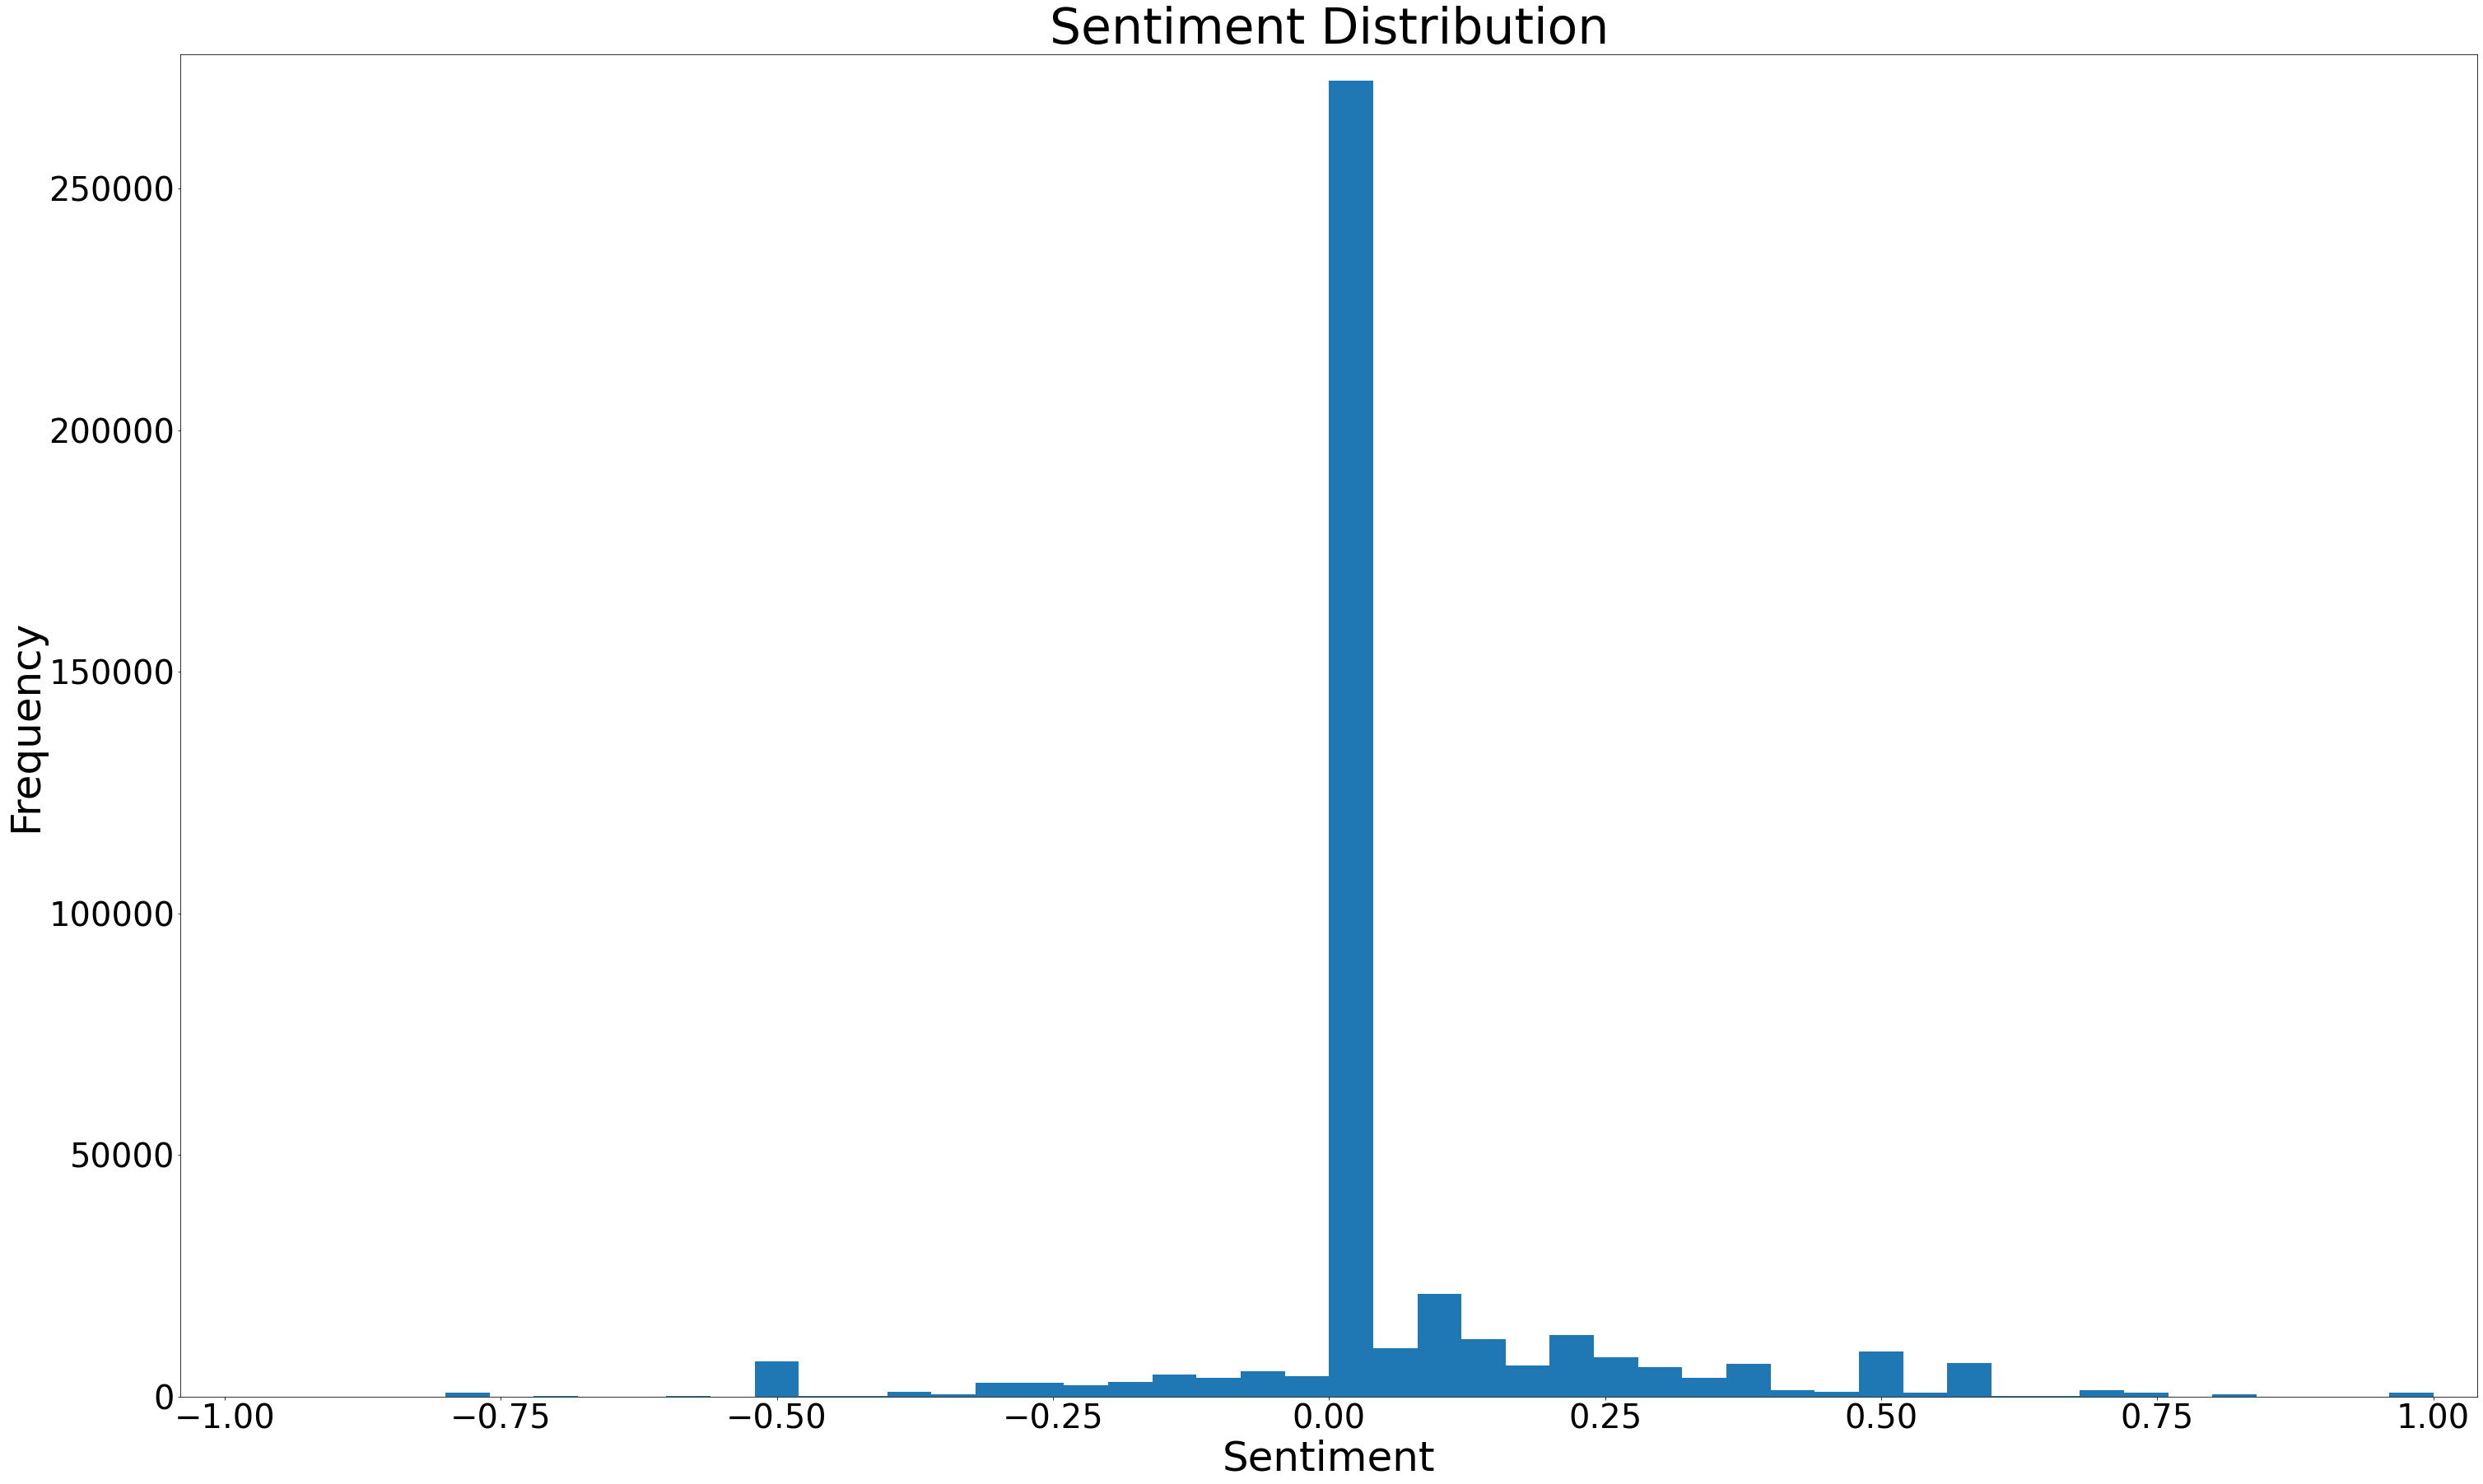

In [196]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df4['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

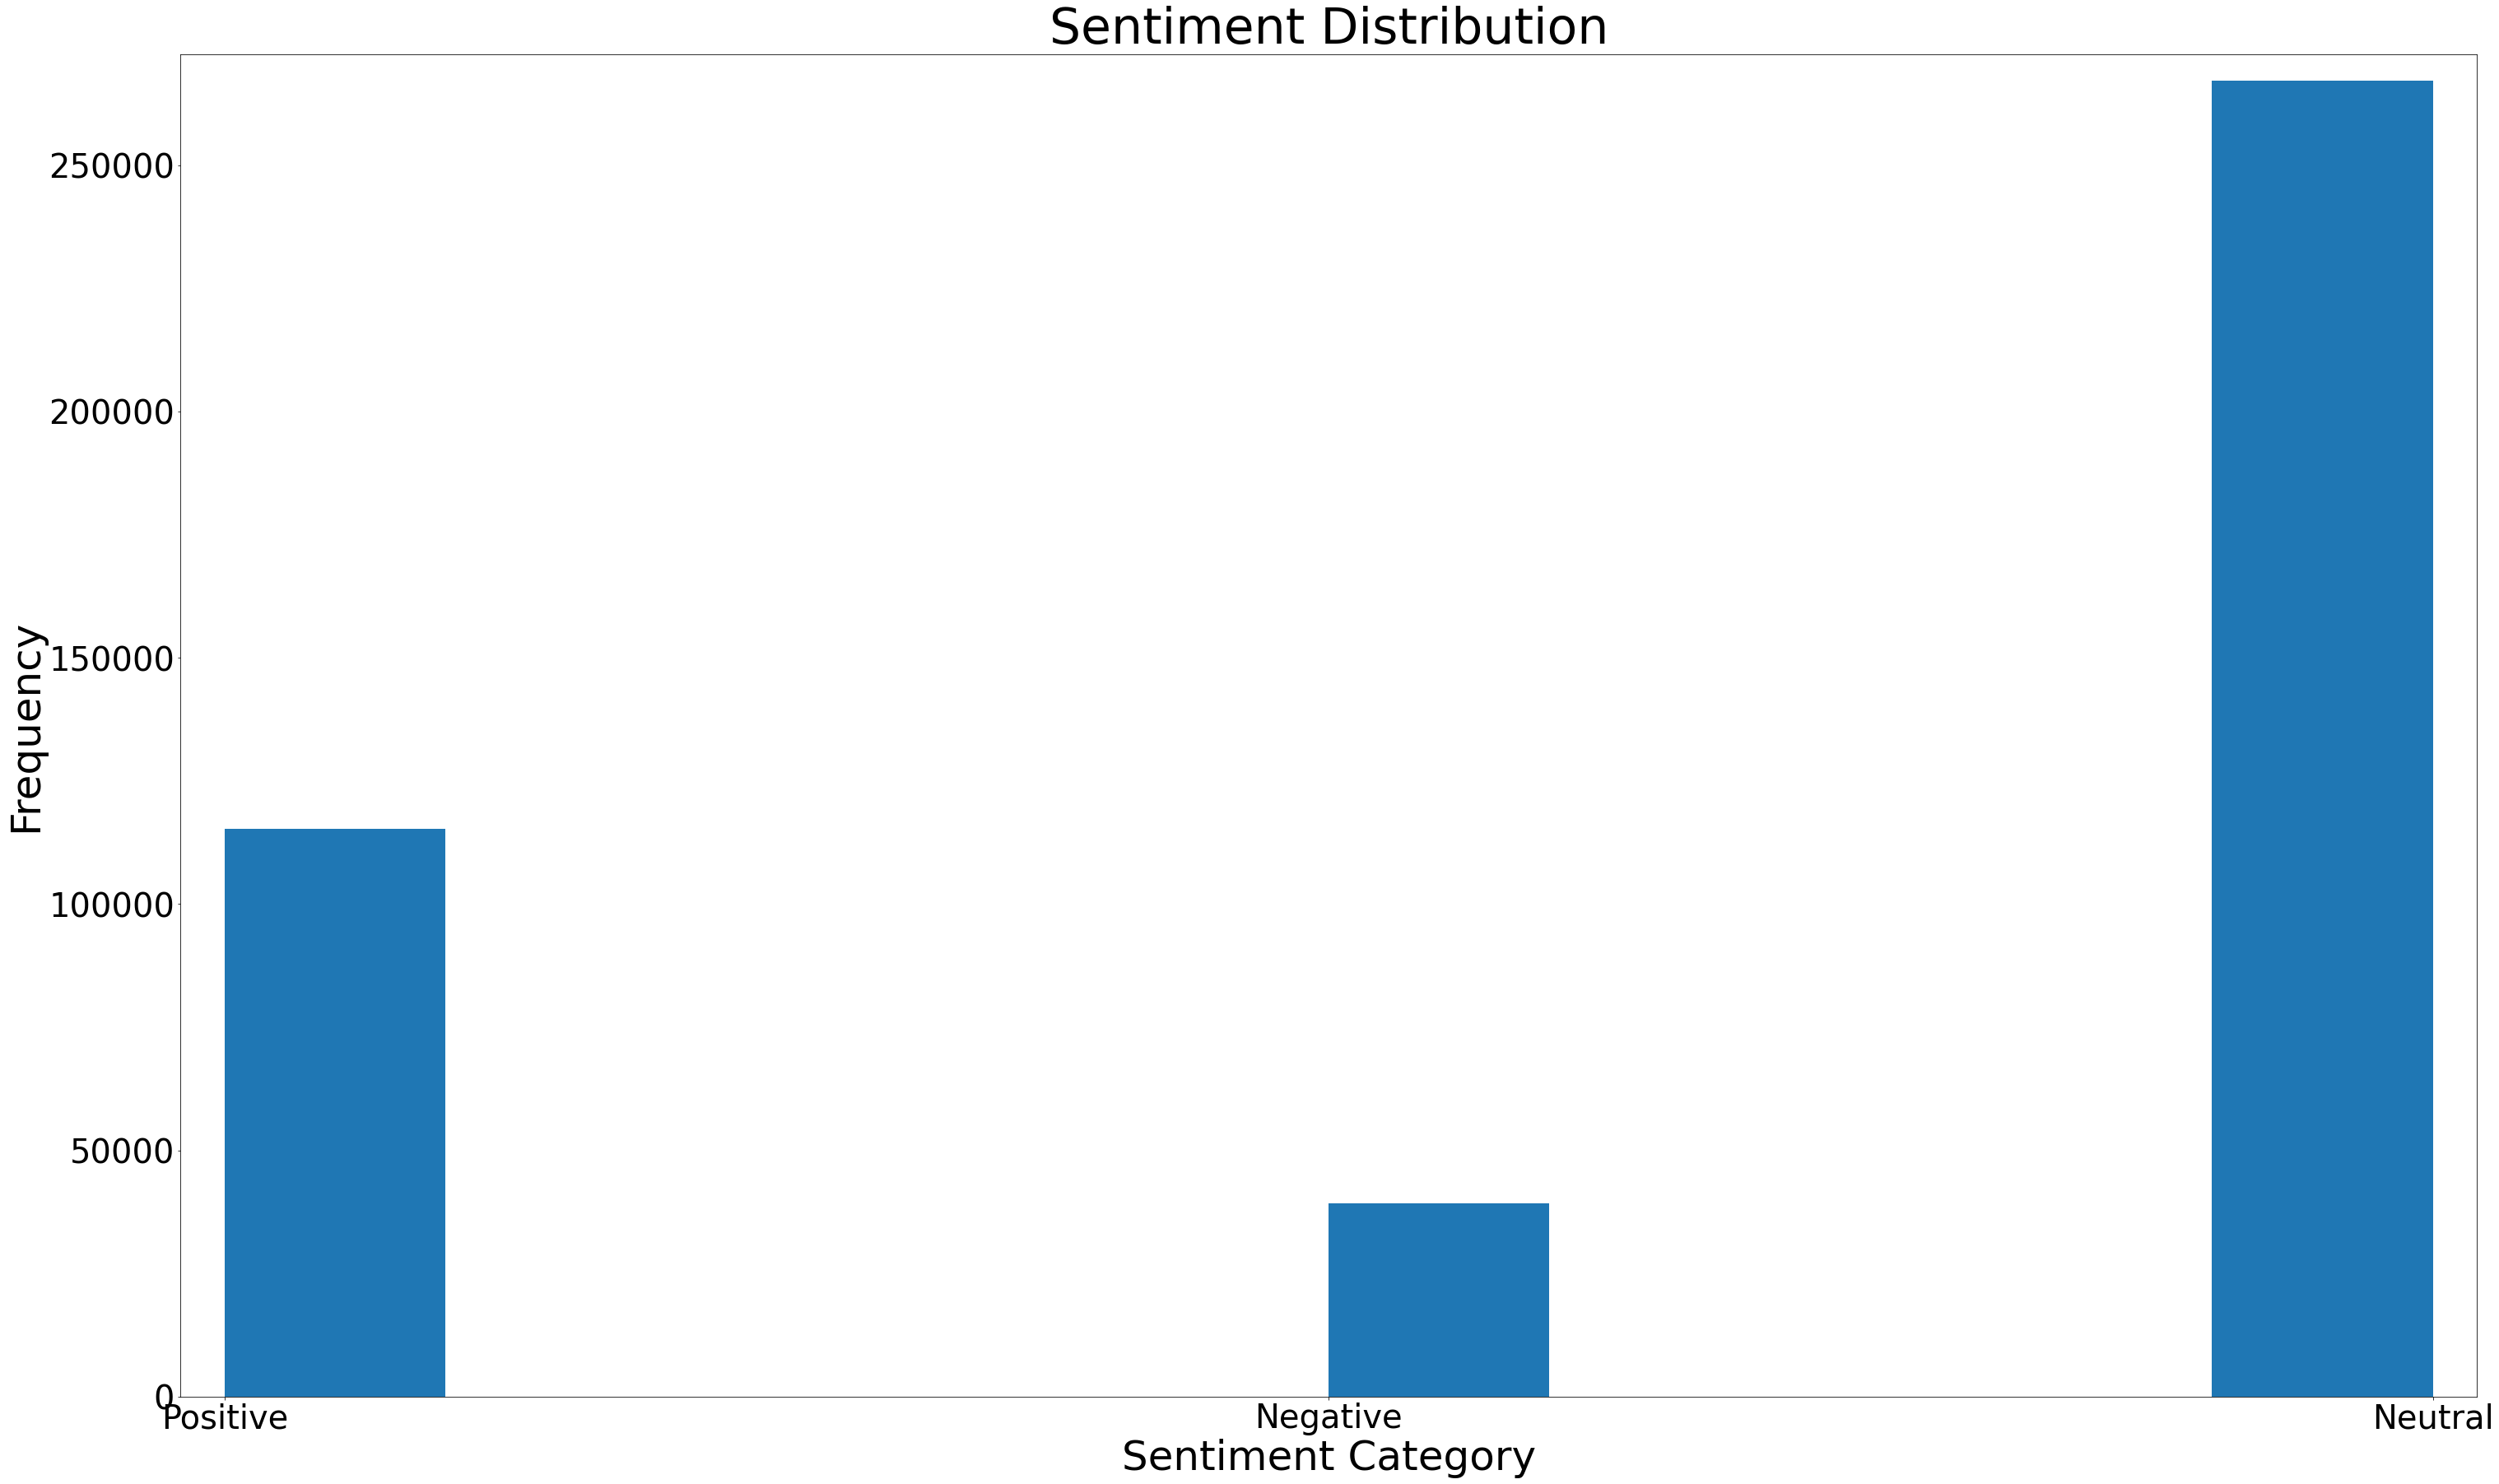

In [197]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment Category', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df4['senti_category'],bins=10)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

(array([0, 1, 2]), [Text(0, 0, 'Good'), Text(1, 0, 'Bad'), Text(2, 0, 'Okay')])

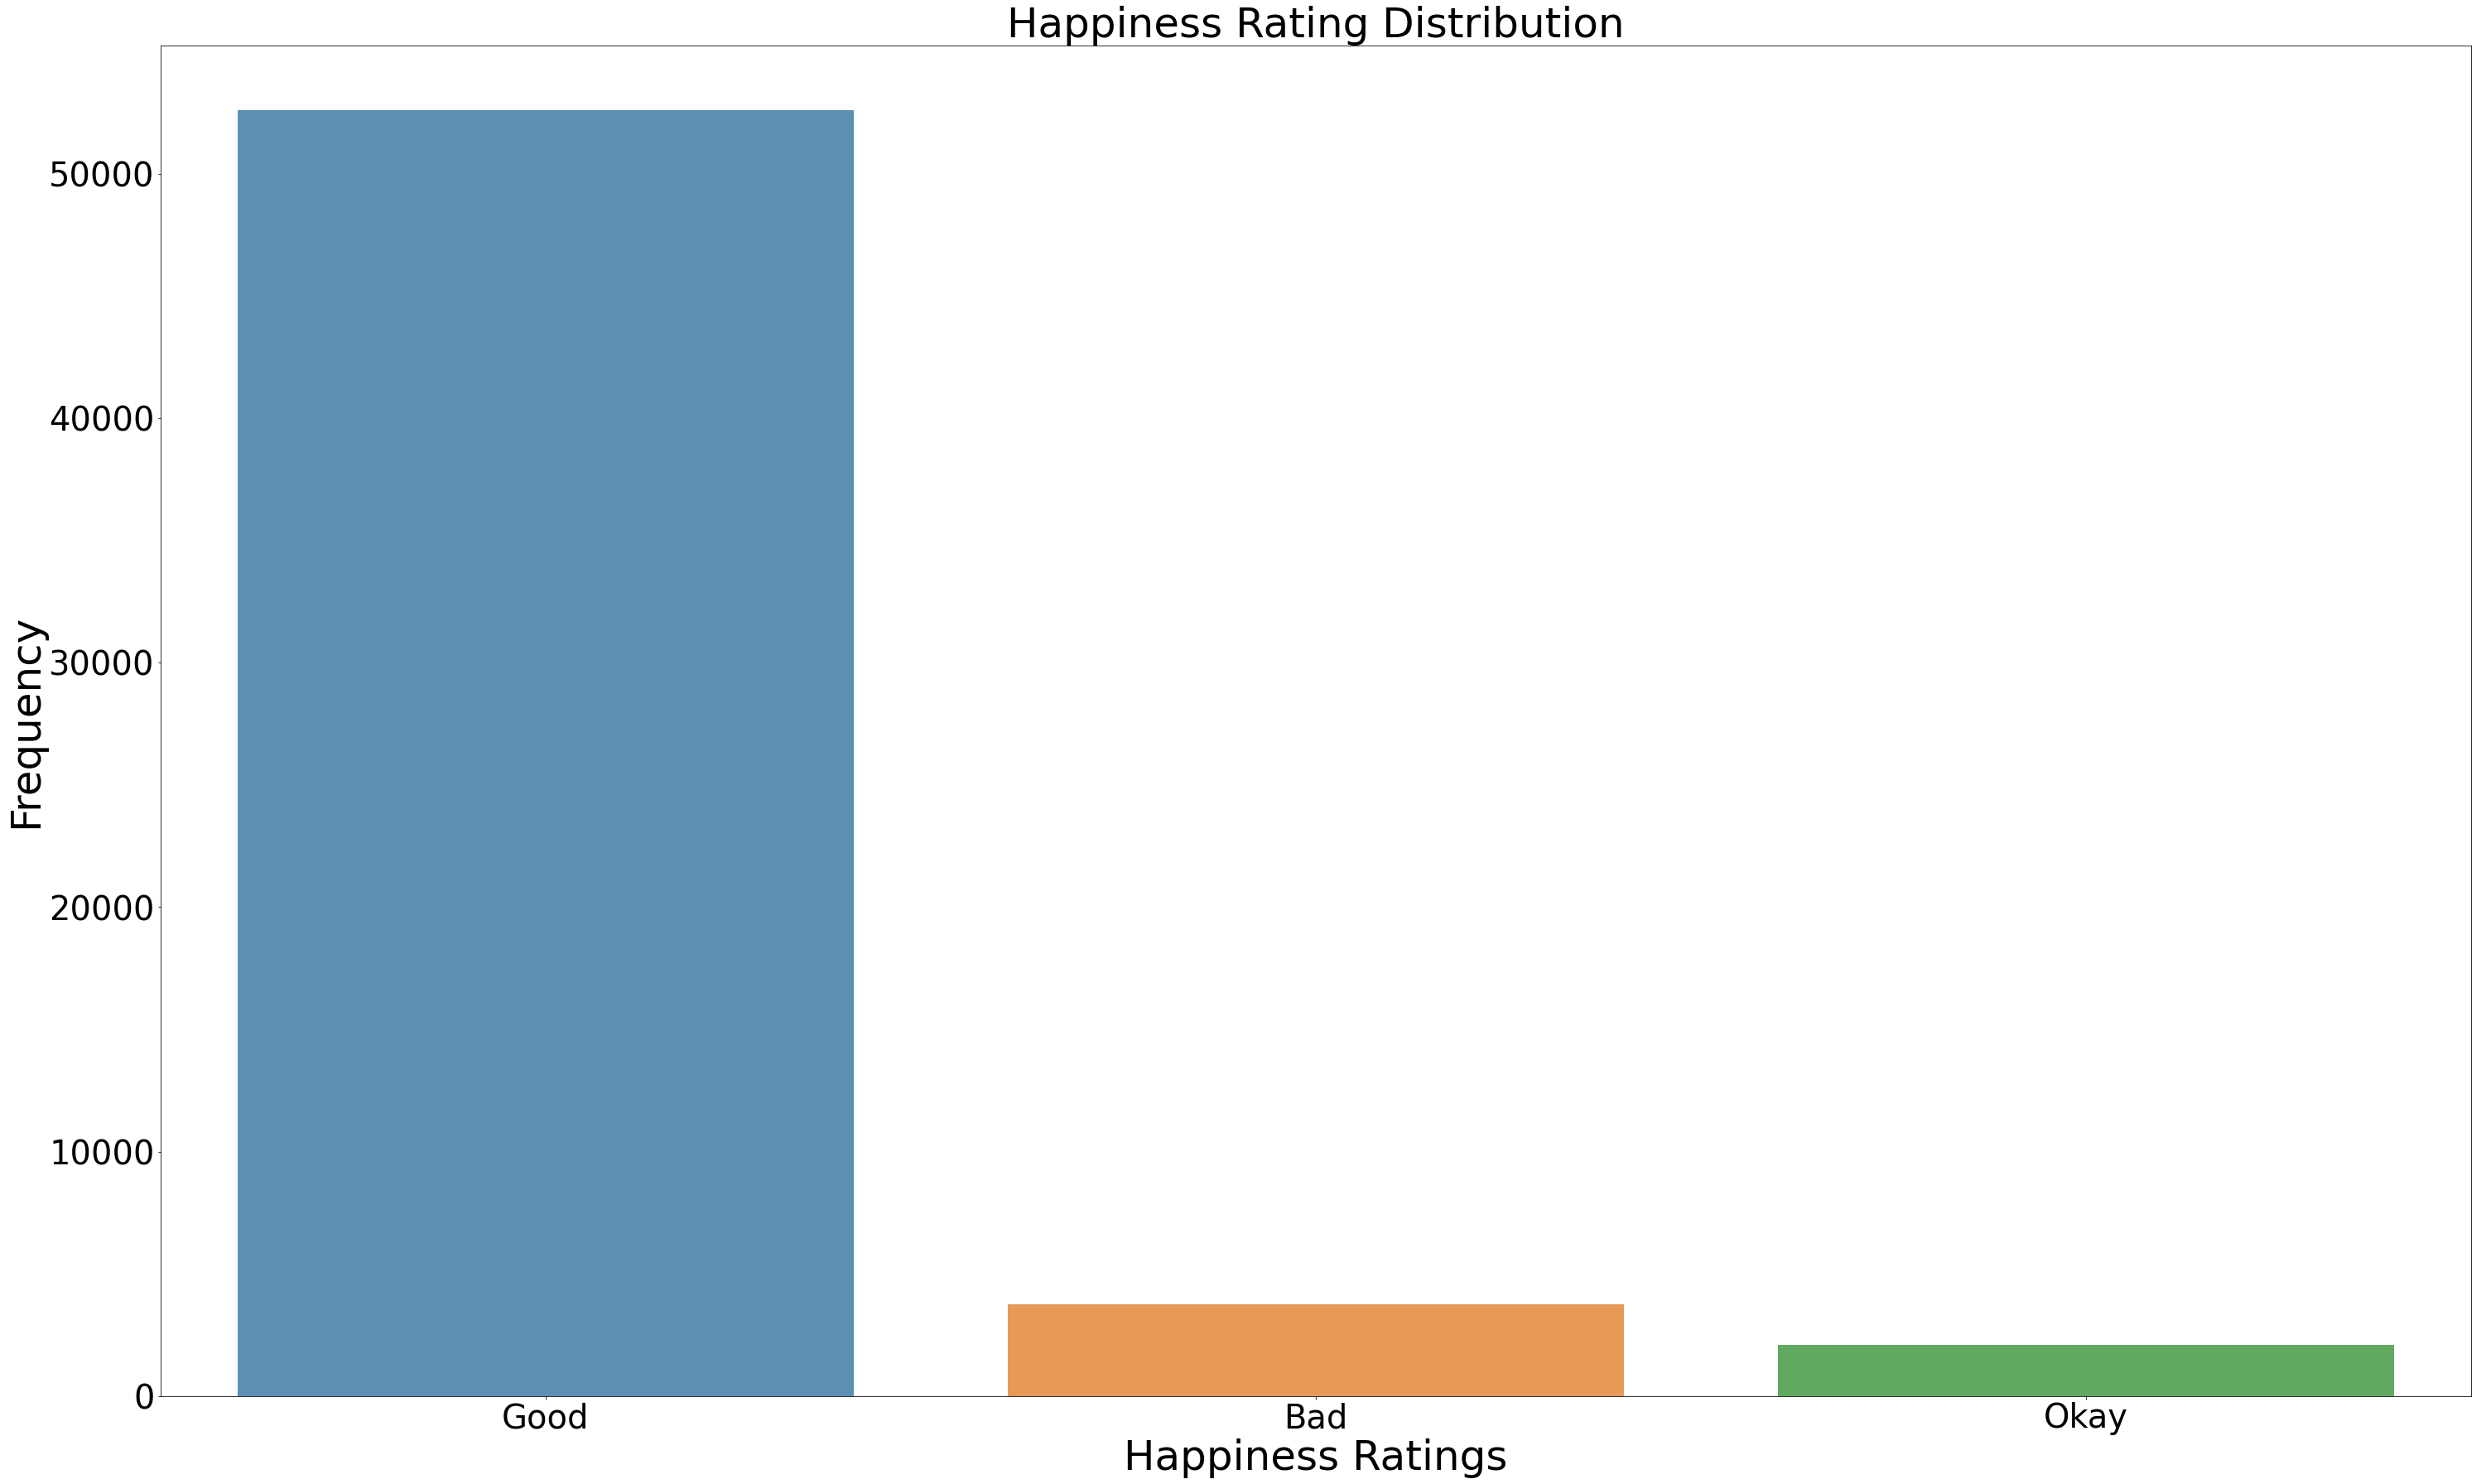

In [198]:
x_rating = df4.happiness_rating.value_counts()
y_rating = x_rating.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Happiness Rating Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Happiness Ratings', fontsize=50)
plt.xticks(fontsize=40)

In [199]:
x_rating

Good    52612
Bad      3760
Okay     2082
Name: happiness_rating, dtype: int64

<AxesSubplot:title={'center':'Percentage of Ratings'}, ylabel='happiness_rating'>

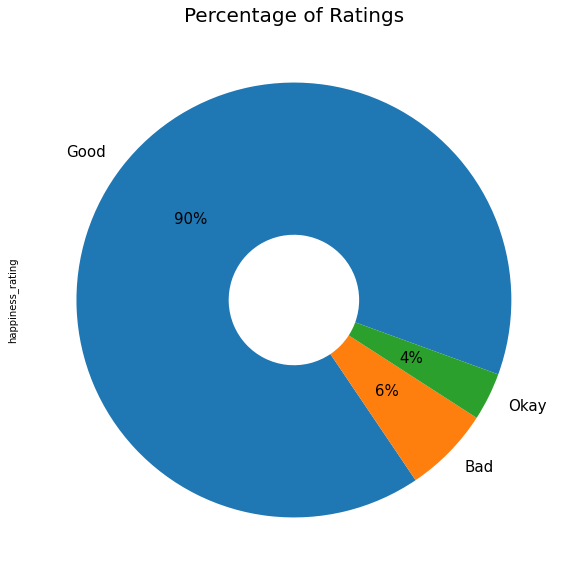

In [200]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Ratings', fontsize=20)
df4.happiness_rating.value_counts().plot(kind='pie', labels=['Good', 'Bad', 'Okay'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

<AxesSubplot:title={'center':'Sentiment Category Distribution'}, ylabel='senti_category'>

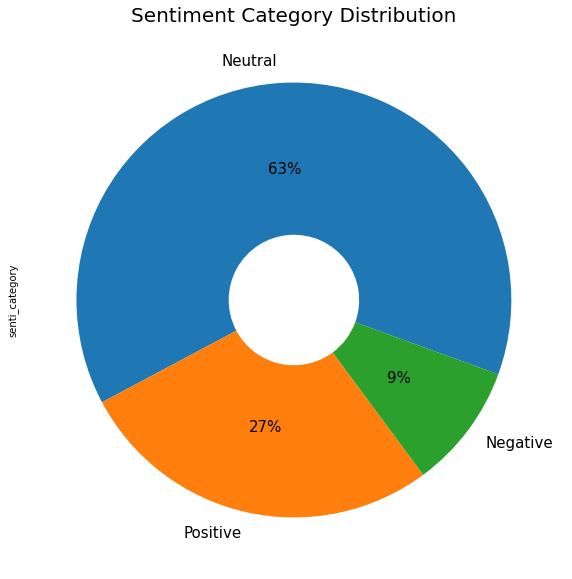

In [201]:
plt.figure(figsize=(30,10))
plt.title('Sentiment Category Distribution', fontsize=20)
df4.senti_category.value_counts().plot(kind='pie', labels=['Neutral','Positive','Negative'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

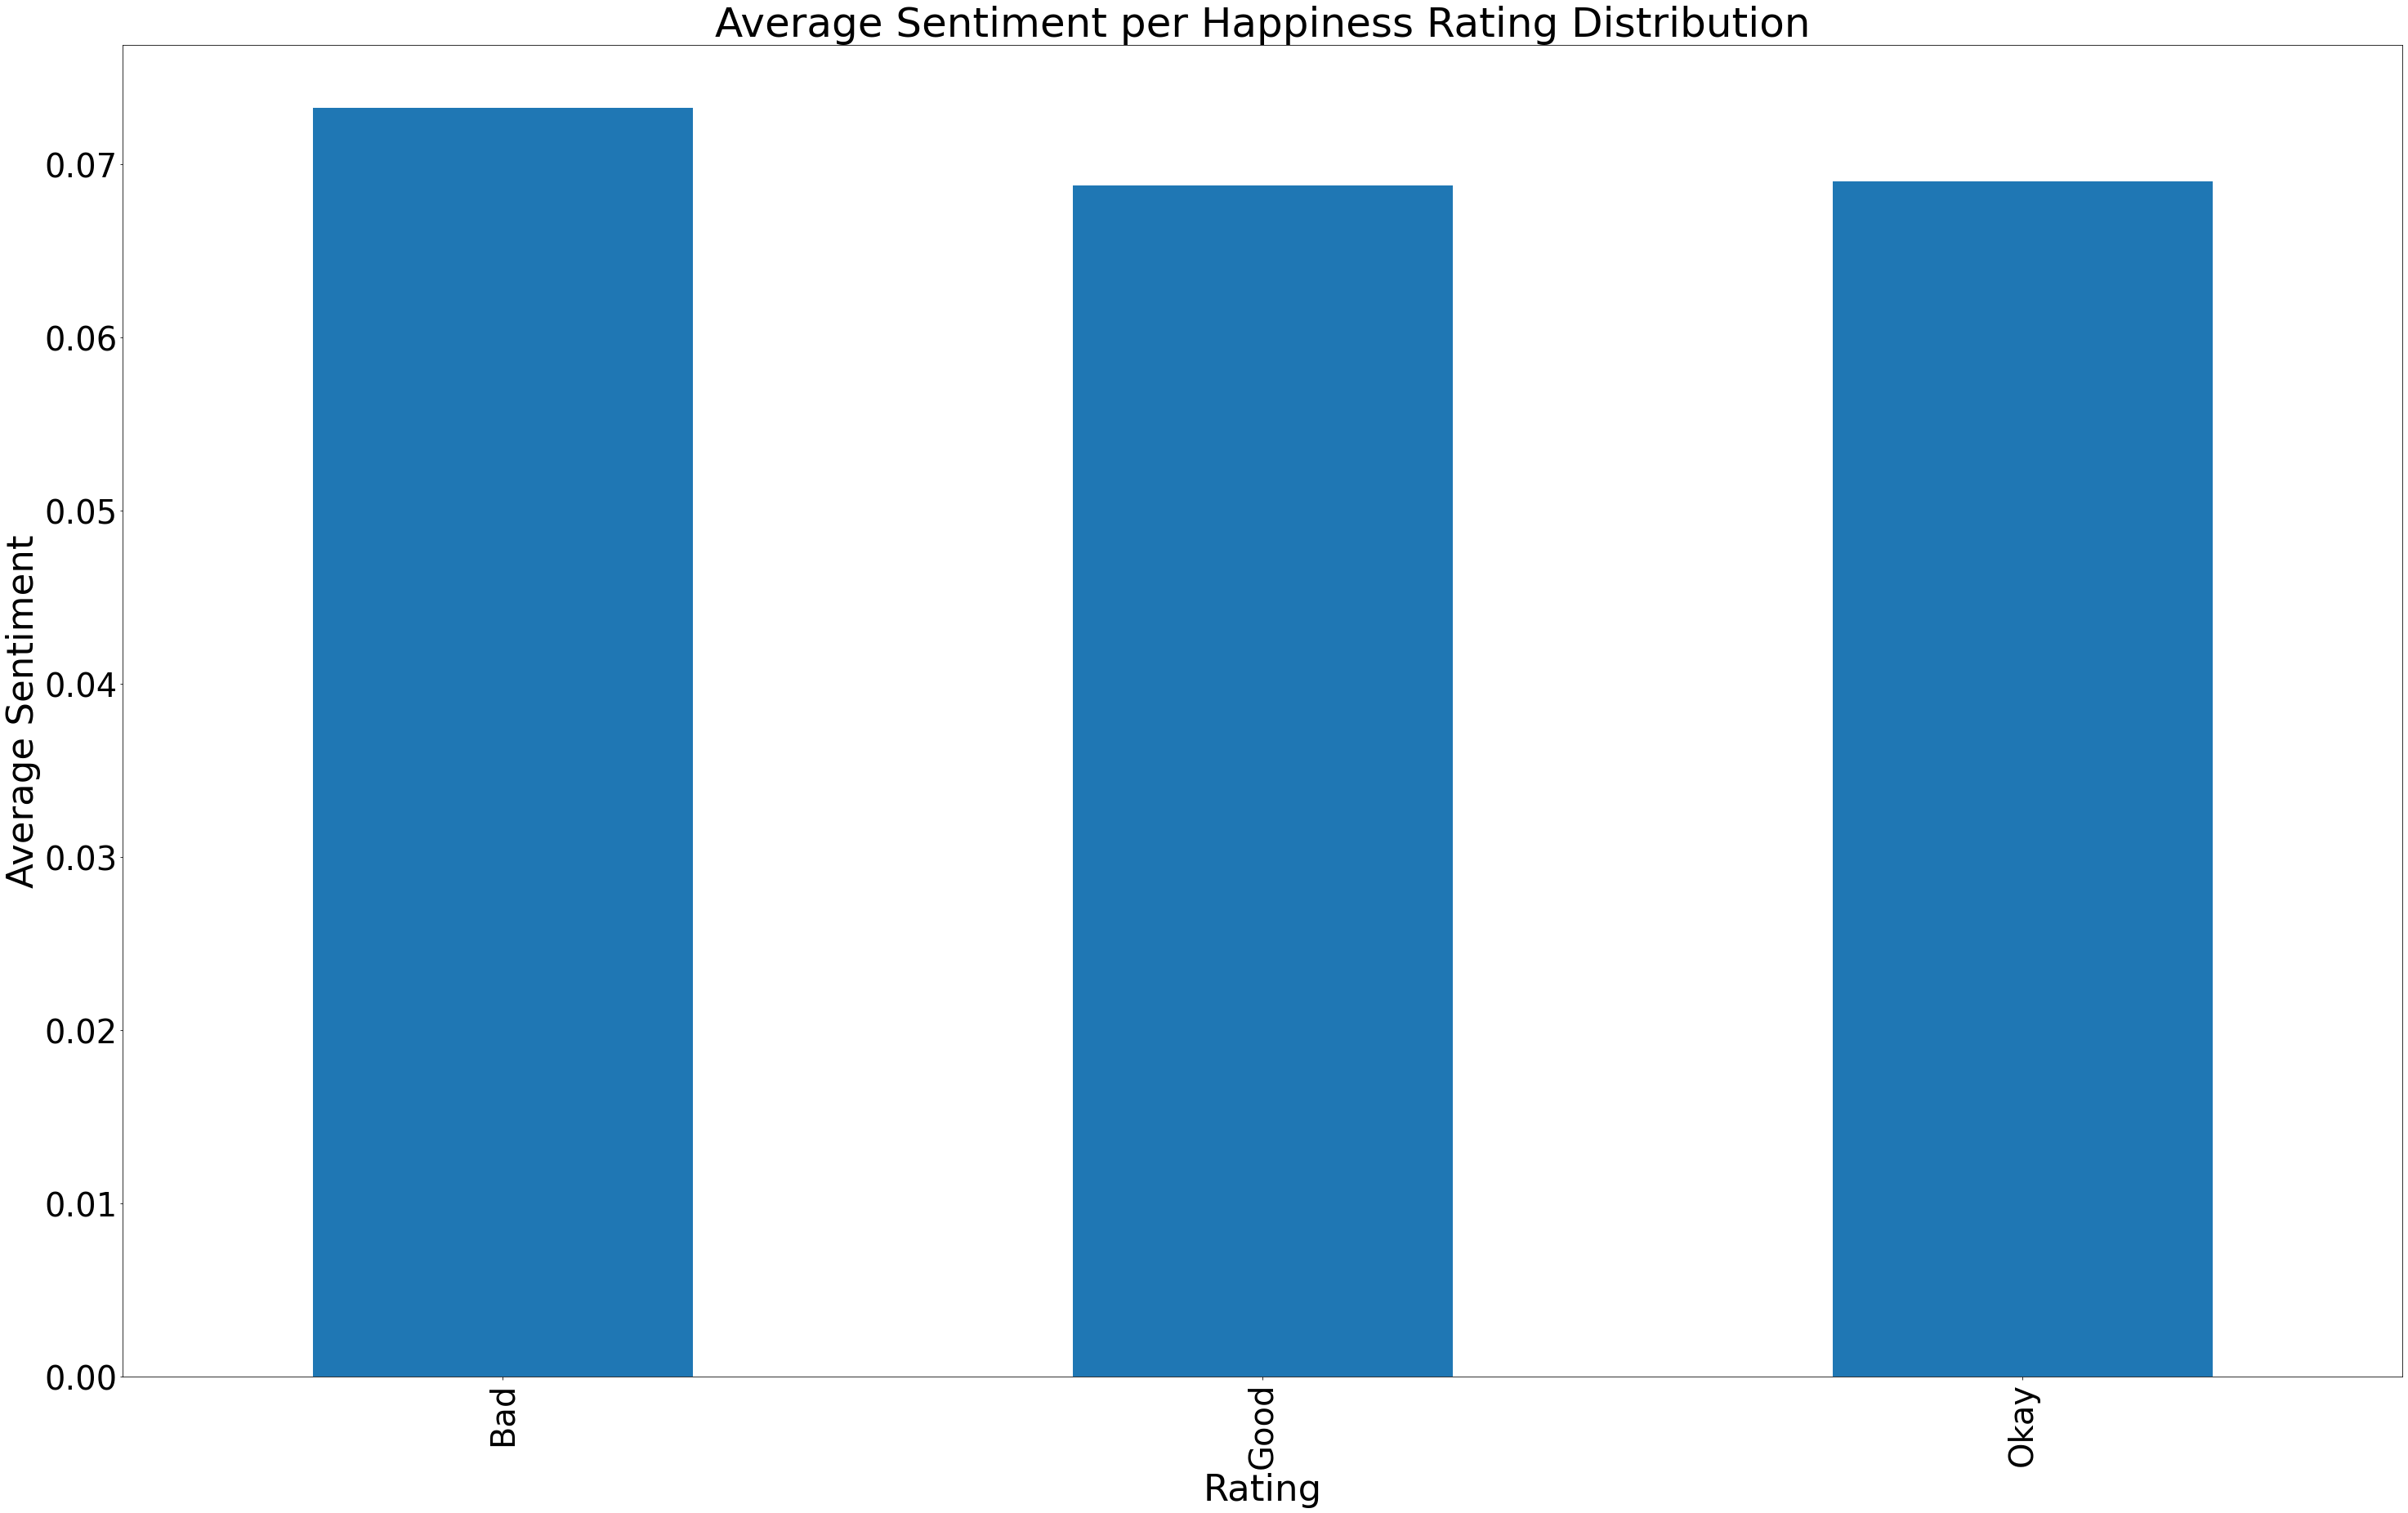

In [202]:
polarity_avg = df4.groupby('happiness_rating')['sentiment'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Happiness Rating Distribution', fontsize=50)
plt.show()

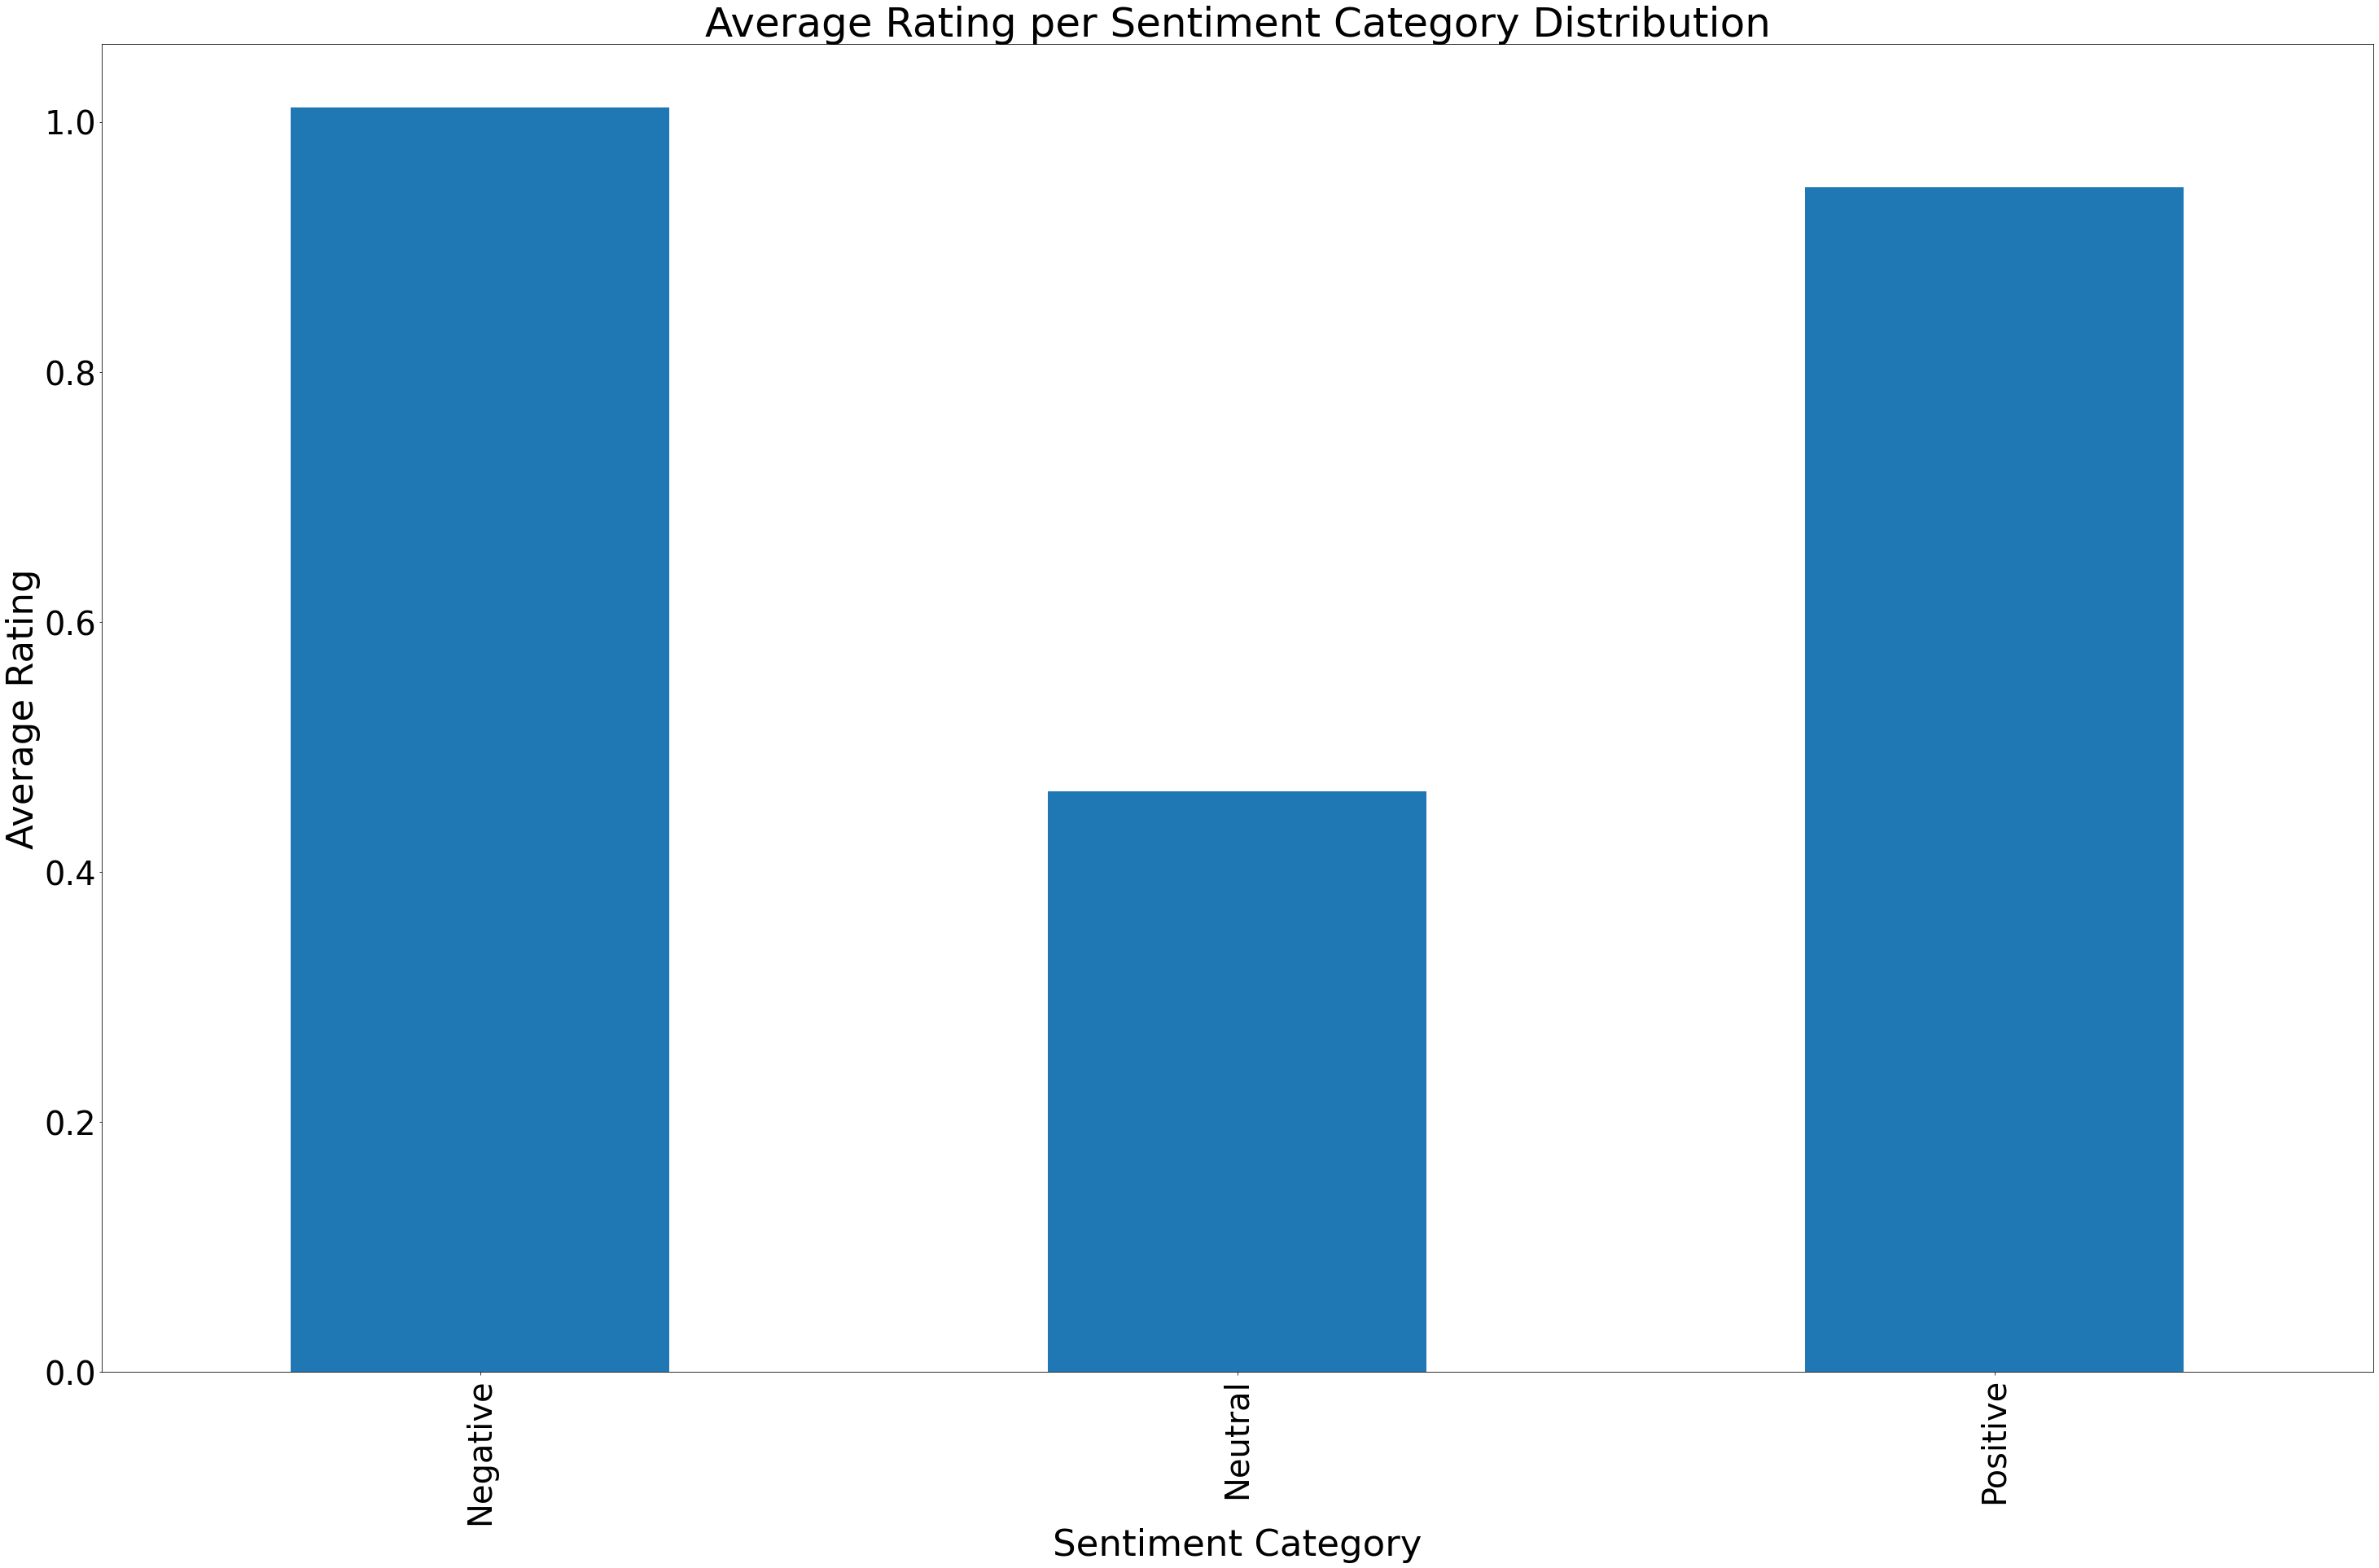

In [203]:
polarity_avg = df4.groupby('senti_category')['rating'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Sentiment Category', fontsize=45)
plt.ylabel('Average Rating', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Rating per Sentiment Category Distribution', fontsize=50)
plt.show()

In [204]:
df4['word_count'] = df4['lemmatized'].apply(lambda x: len(str(x).split()))
df4['review_len'] = df4['lemma_str'].astype(str).apply(len)
df4

freshdesk_id happiness_rating  rating  \
0               2076              NaN       0   
1               2079              NaN       0   
2               2082              NaN       0   
3               2084              NaN       0   
4               2087             Good       5   
...              ...              ...     ...   
421823       1020407              NaN       0   
421824       1020408              NaN       0   
421825       1020409              NaN       0   
421826       1020411              NaN       0   
421827       1020412              NaN       0   

                                                                                                 lemmatized  \
0                                       ['submit', 'final', 'project', 'evaluation', 'process', 'complete']   
1       ['opt', 'full', 'stack', 'web', 'development', 'course', 'wednesday', 'enrol', 'come', 'know', '...   
2                    ['unable', 'play', 'record', 'video', 'could', 'check', 'soon', 'possible', 'chandan']   
3                           ['assignment', 'get', 'verify', 'able', 'get', 'certificate', 'look', 'please']   
4       ['face', 'difficulty', 'submit', 'question', 'execution', 'give', 'error', 'message', 'submit', ...   
...                                                                                                     ...   
421823                          ['request', 'update', 'pmi', 'exams', 'pattern', 'change', 'muralikrishna']   
421824                                                 ['need', 'reference', 'note', 'module', 'reference']   
421825                  ['would', 'like', 'reattend', 'aws', 'class', 'look', 'let', 'know', 'timing', 'n']   
421826                                              ['extend', 'lab', 'access', 'beyond', 'initial', 'day']   
421827                                                    ['give', 'retake', 'assignment', 'nlp', 'module']   

                                                                                                  lemma_str  \
0                                                          submit final project evaluation process complete   
1       opt full stack web development course wednesday enrol come know nothing java devloping side thin...   
2                                                unable play record video could check soon possible chandan   
3                                                    assignment get verify able get certificate look please   
4       face difficulty submit question execution give error message submit fails test case let know wro...   
...                                                                                                     ...   
421823                                                request update pmi exams pattern change muralikrishna   
421824                                                                 need reference note module reference   
421825                                                 would like reattend aws class look let know timing n   
421826                                                                 extend lab access beyond initial day   
421827                                                                    give retake assignment nlp module   

        sentiment senti_category  word_count  review_len  
0        0.050000       Positive           6          48  
1        0.412500       Positive          31         211  
2       -0.250000       Negative           9          58  
3        0.500000       Positive           8          54  
4       -0.142857       Negative         129        1094  
...           ...            ...         ...         ...  
421823   0.000000        Neutral           7          53  
421824   0.000000        Neutral           5          36  
421825   0.000000        Neutral          10          52  
421826   0.000000        Neutral           6          36  
421827   0.000000        Neutral           5          33  

[421828 rows x 9 columns]

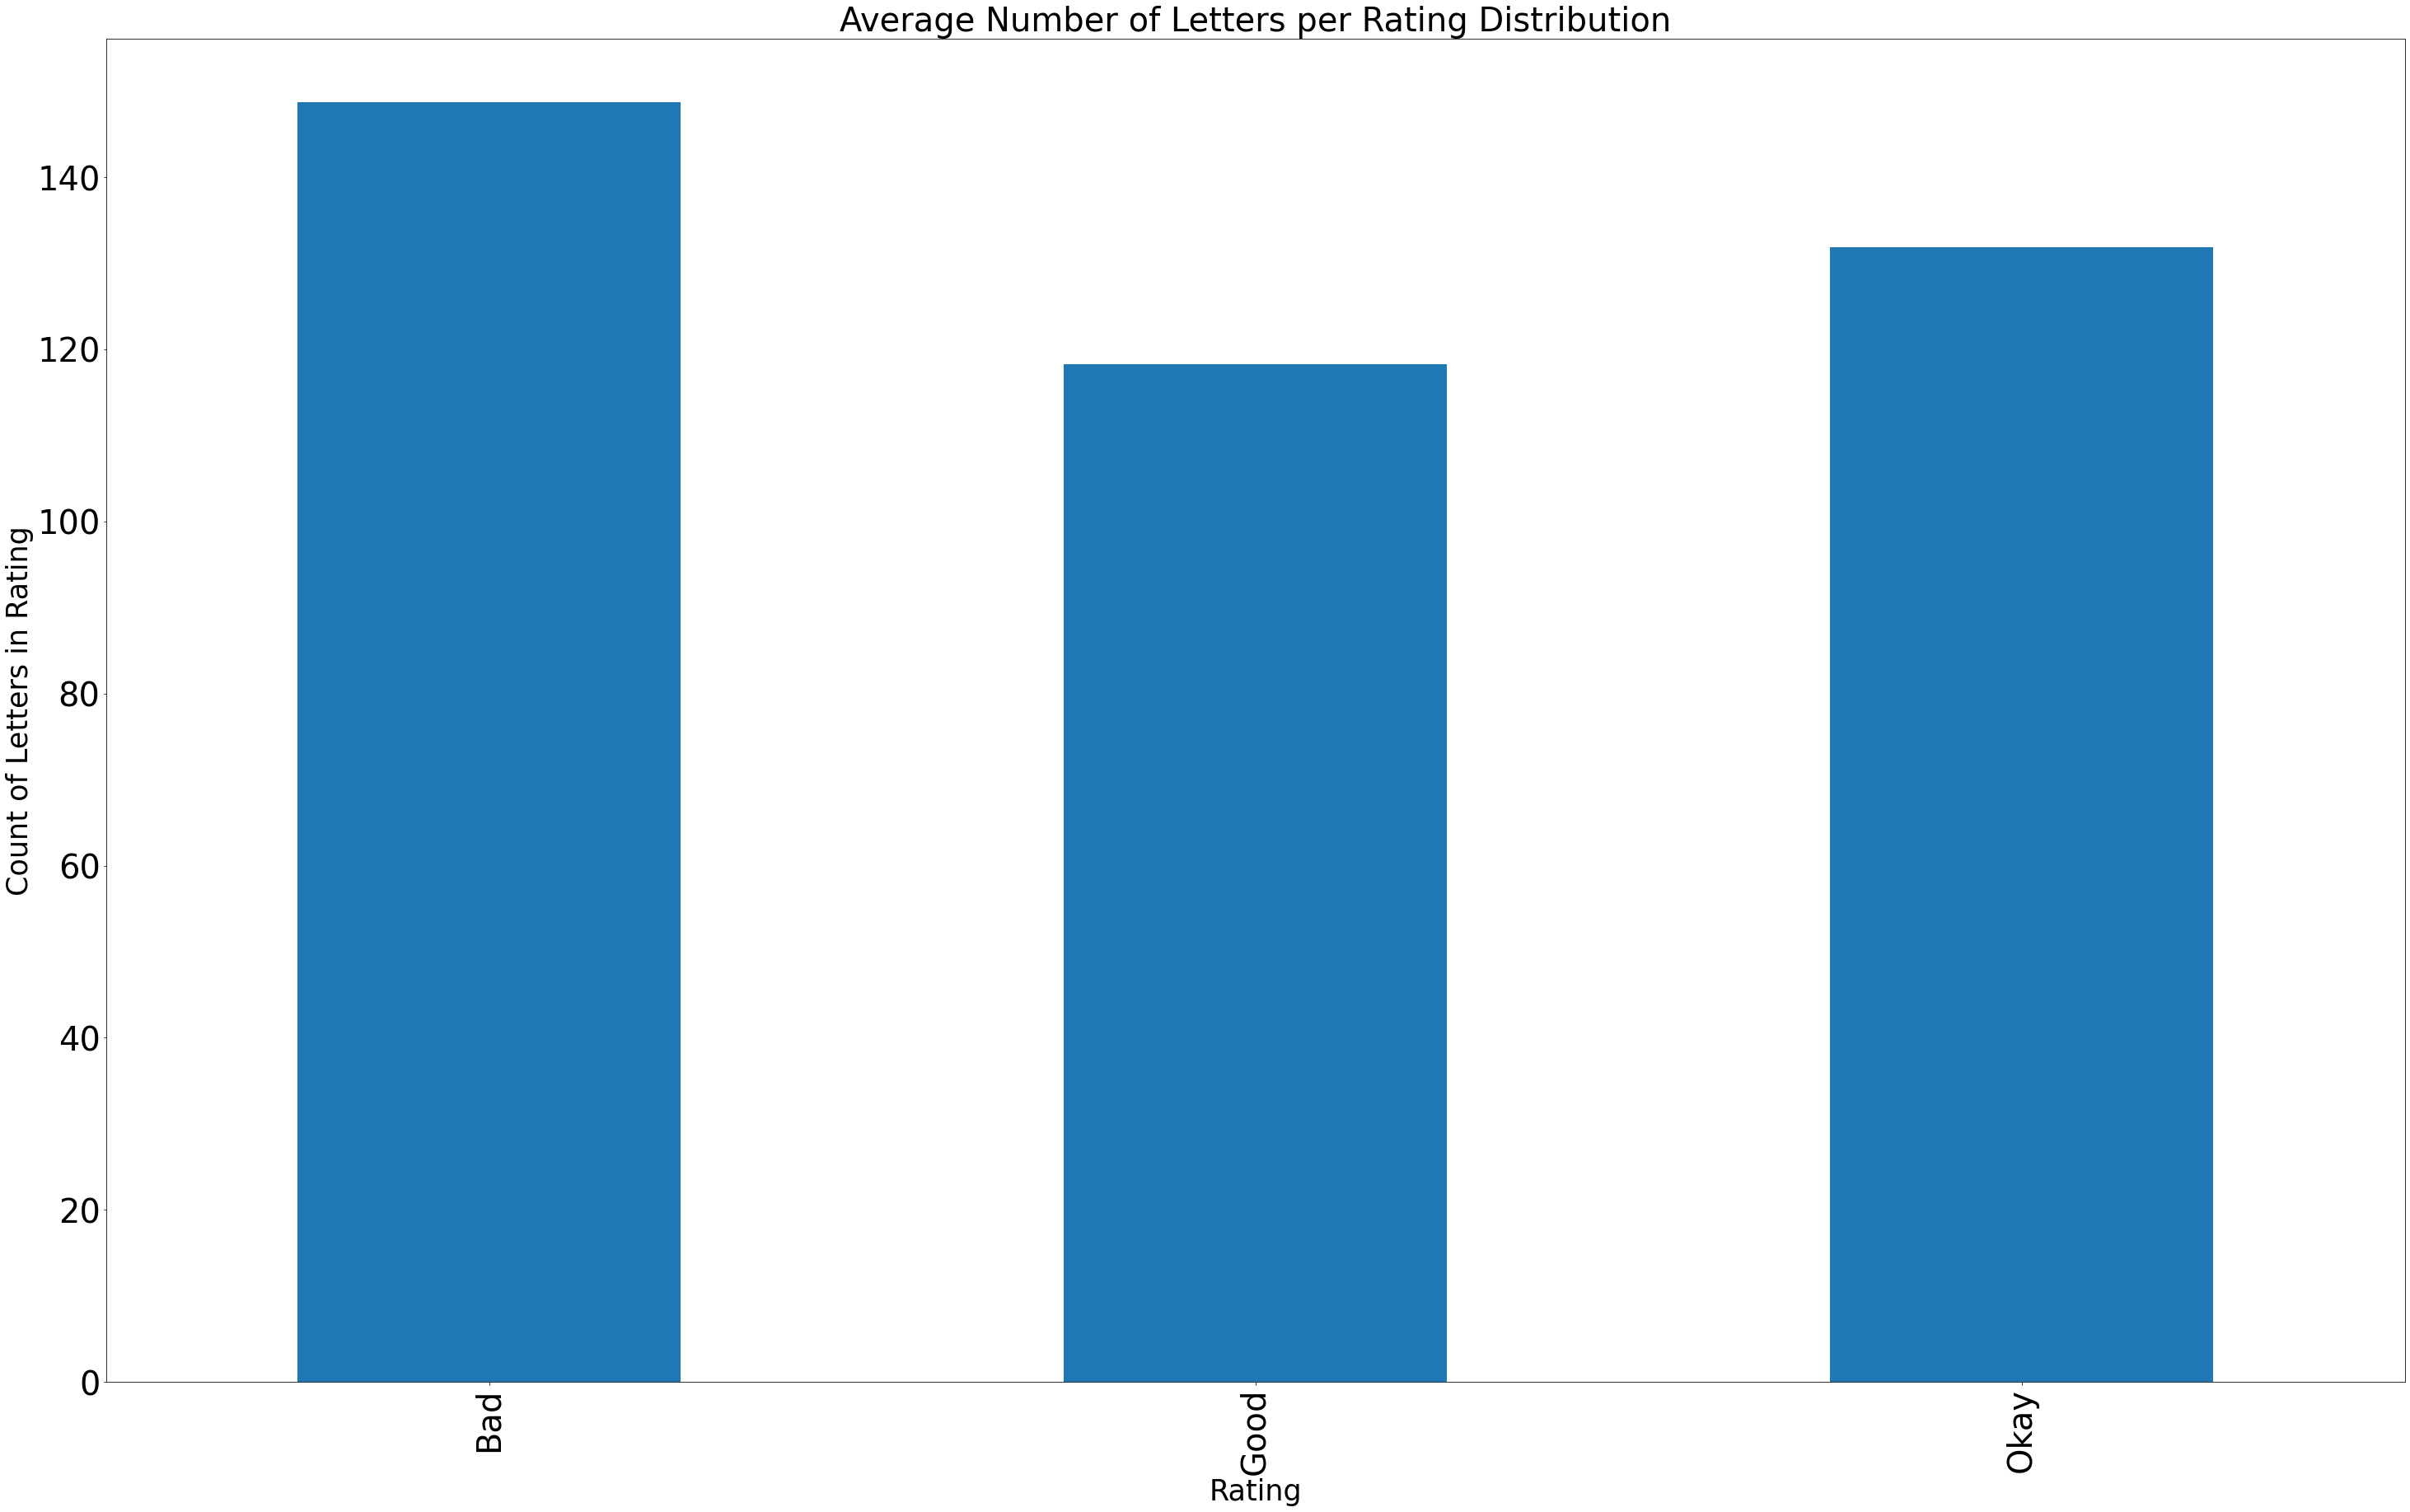

In [205]:
letter_avg = df4.groupby('happiness_rating')['review_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Letters in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Letters per Rating Distribution', fontsize=40)
plt.show()

### Although the differences are not significantly large it seems the longest reviews based on the count of letters and words seem to be bad and okay.

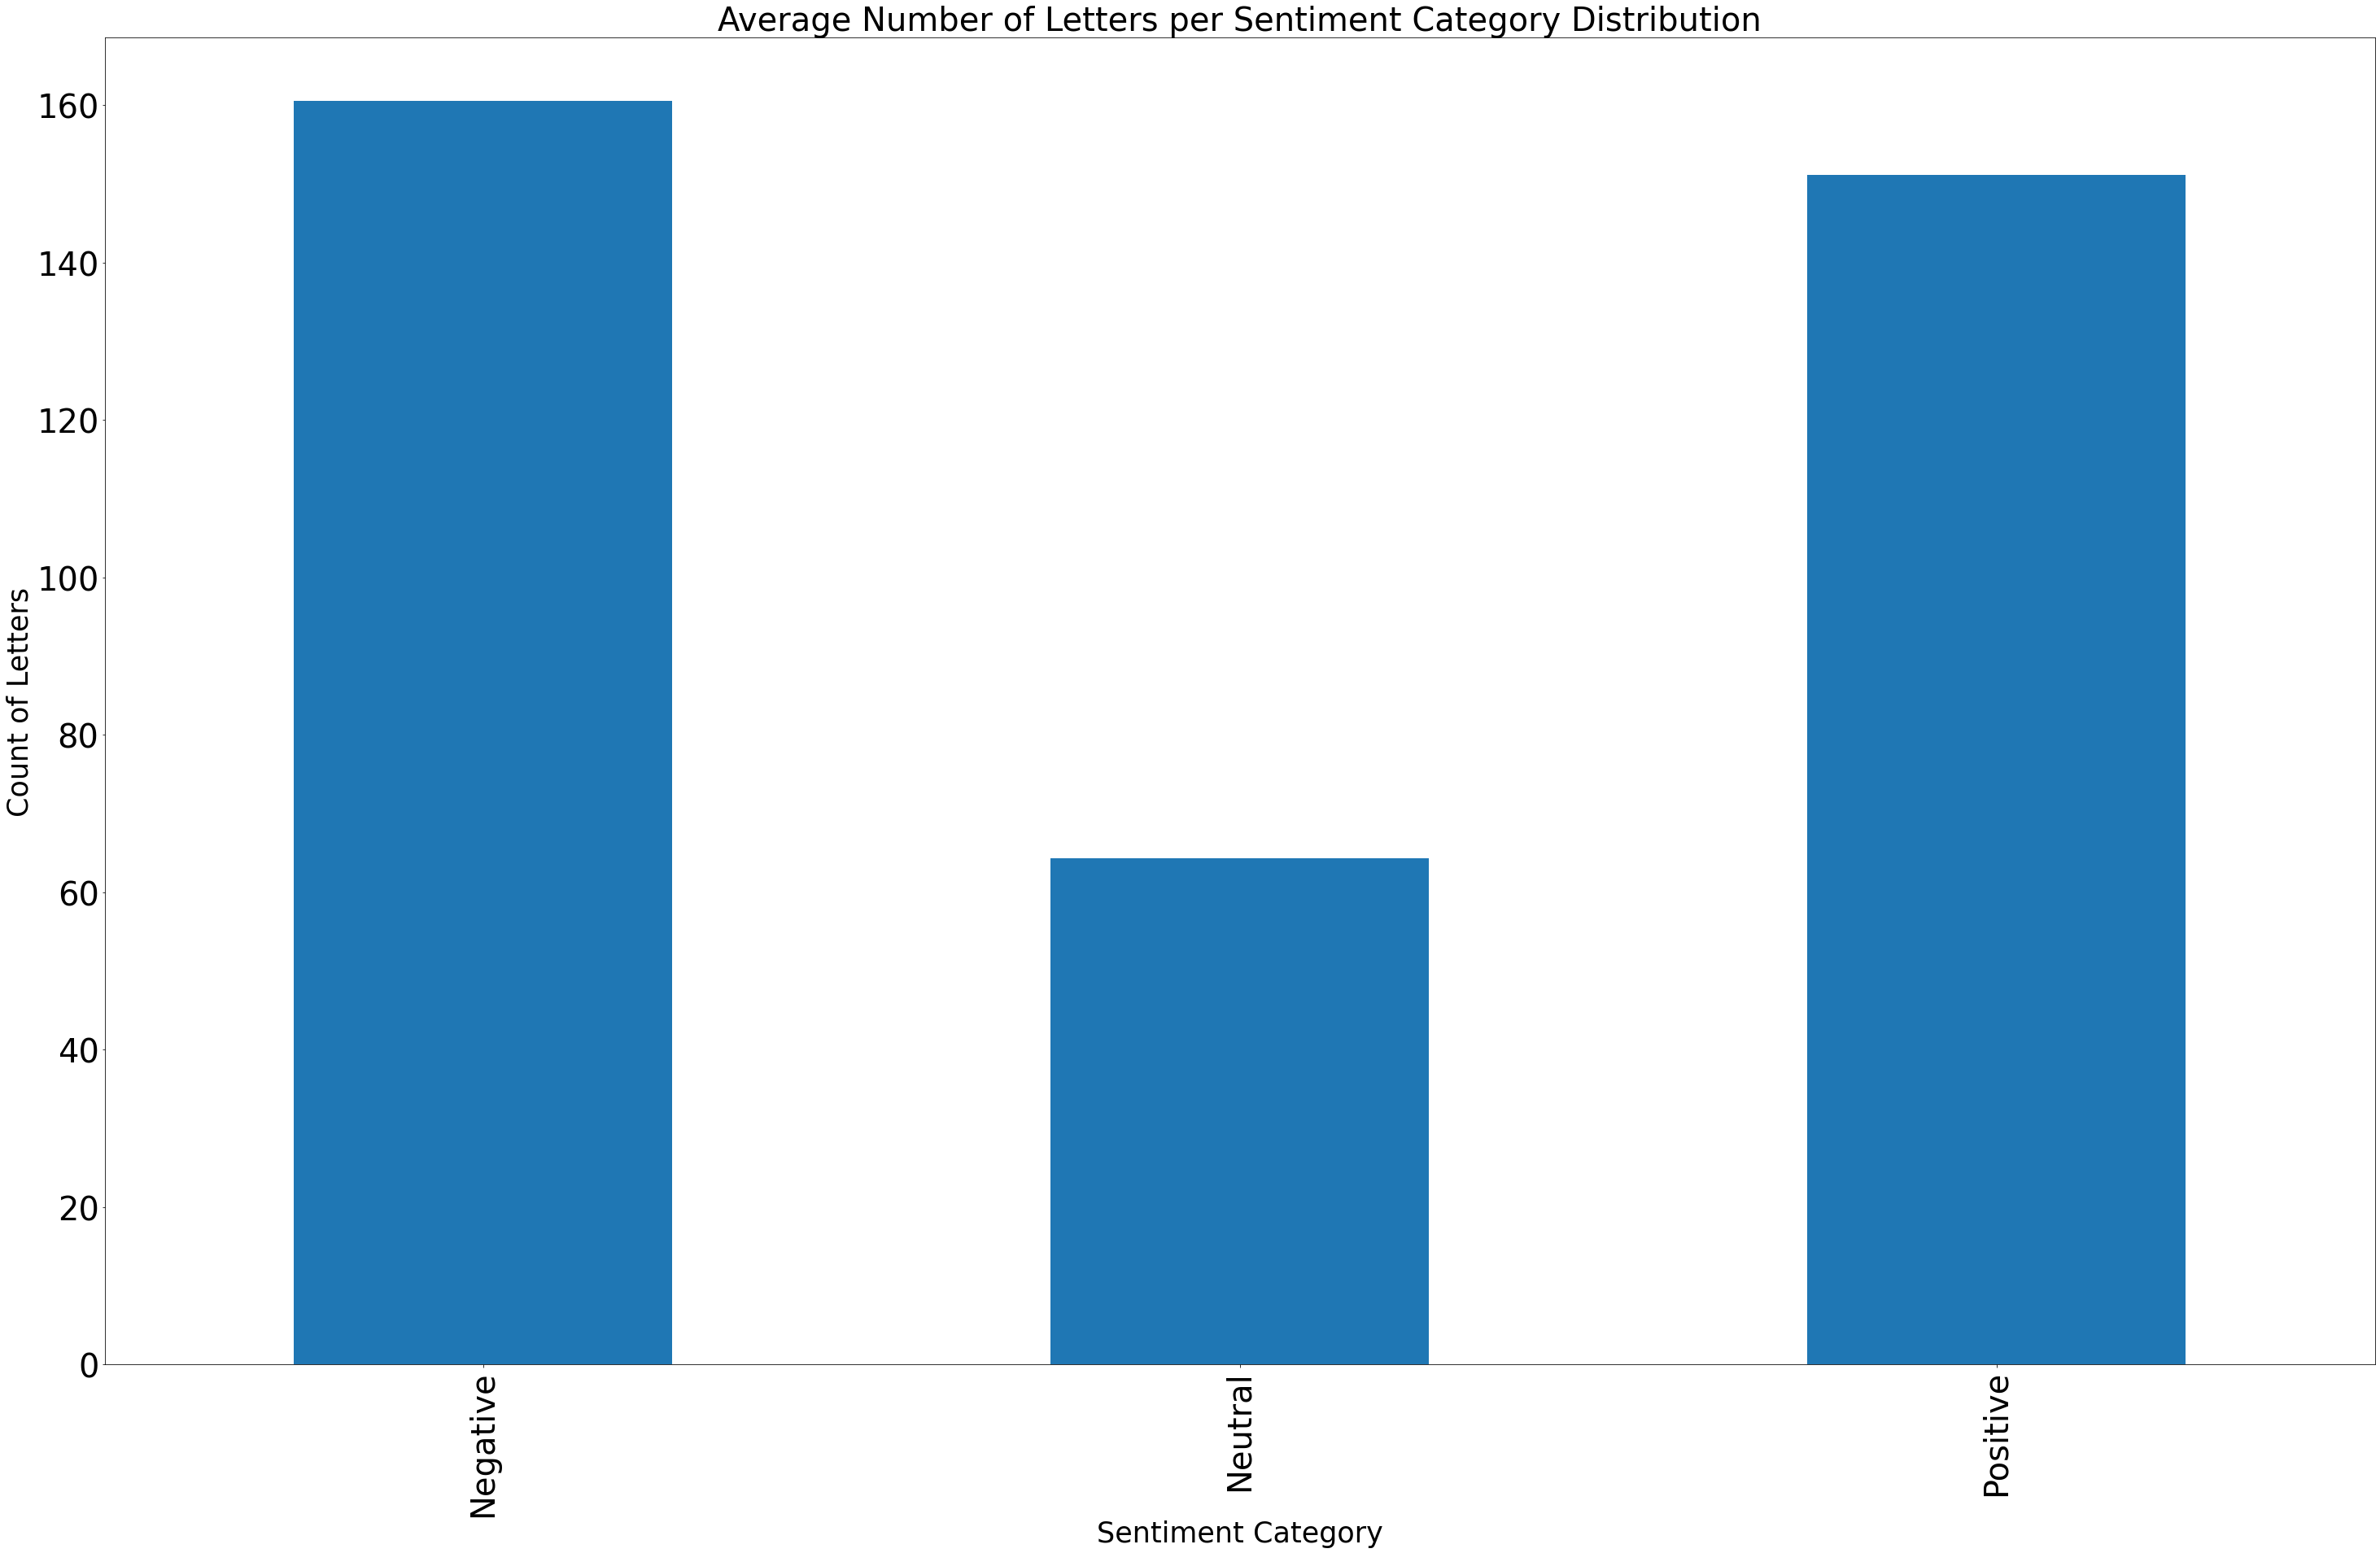

In [206]:
letter_avg = df4.groupby('senti_category')['review_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Sentiment Category', fontsize=35)
plt.ylabel('Count of Letters', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Letters per Sentiment Category Distribution', fontsize=40)
plt.show()

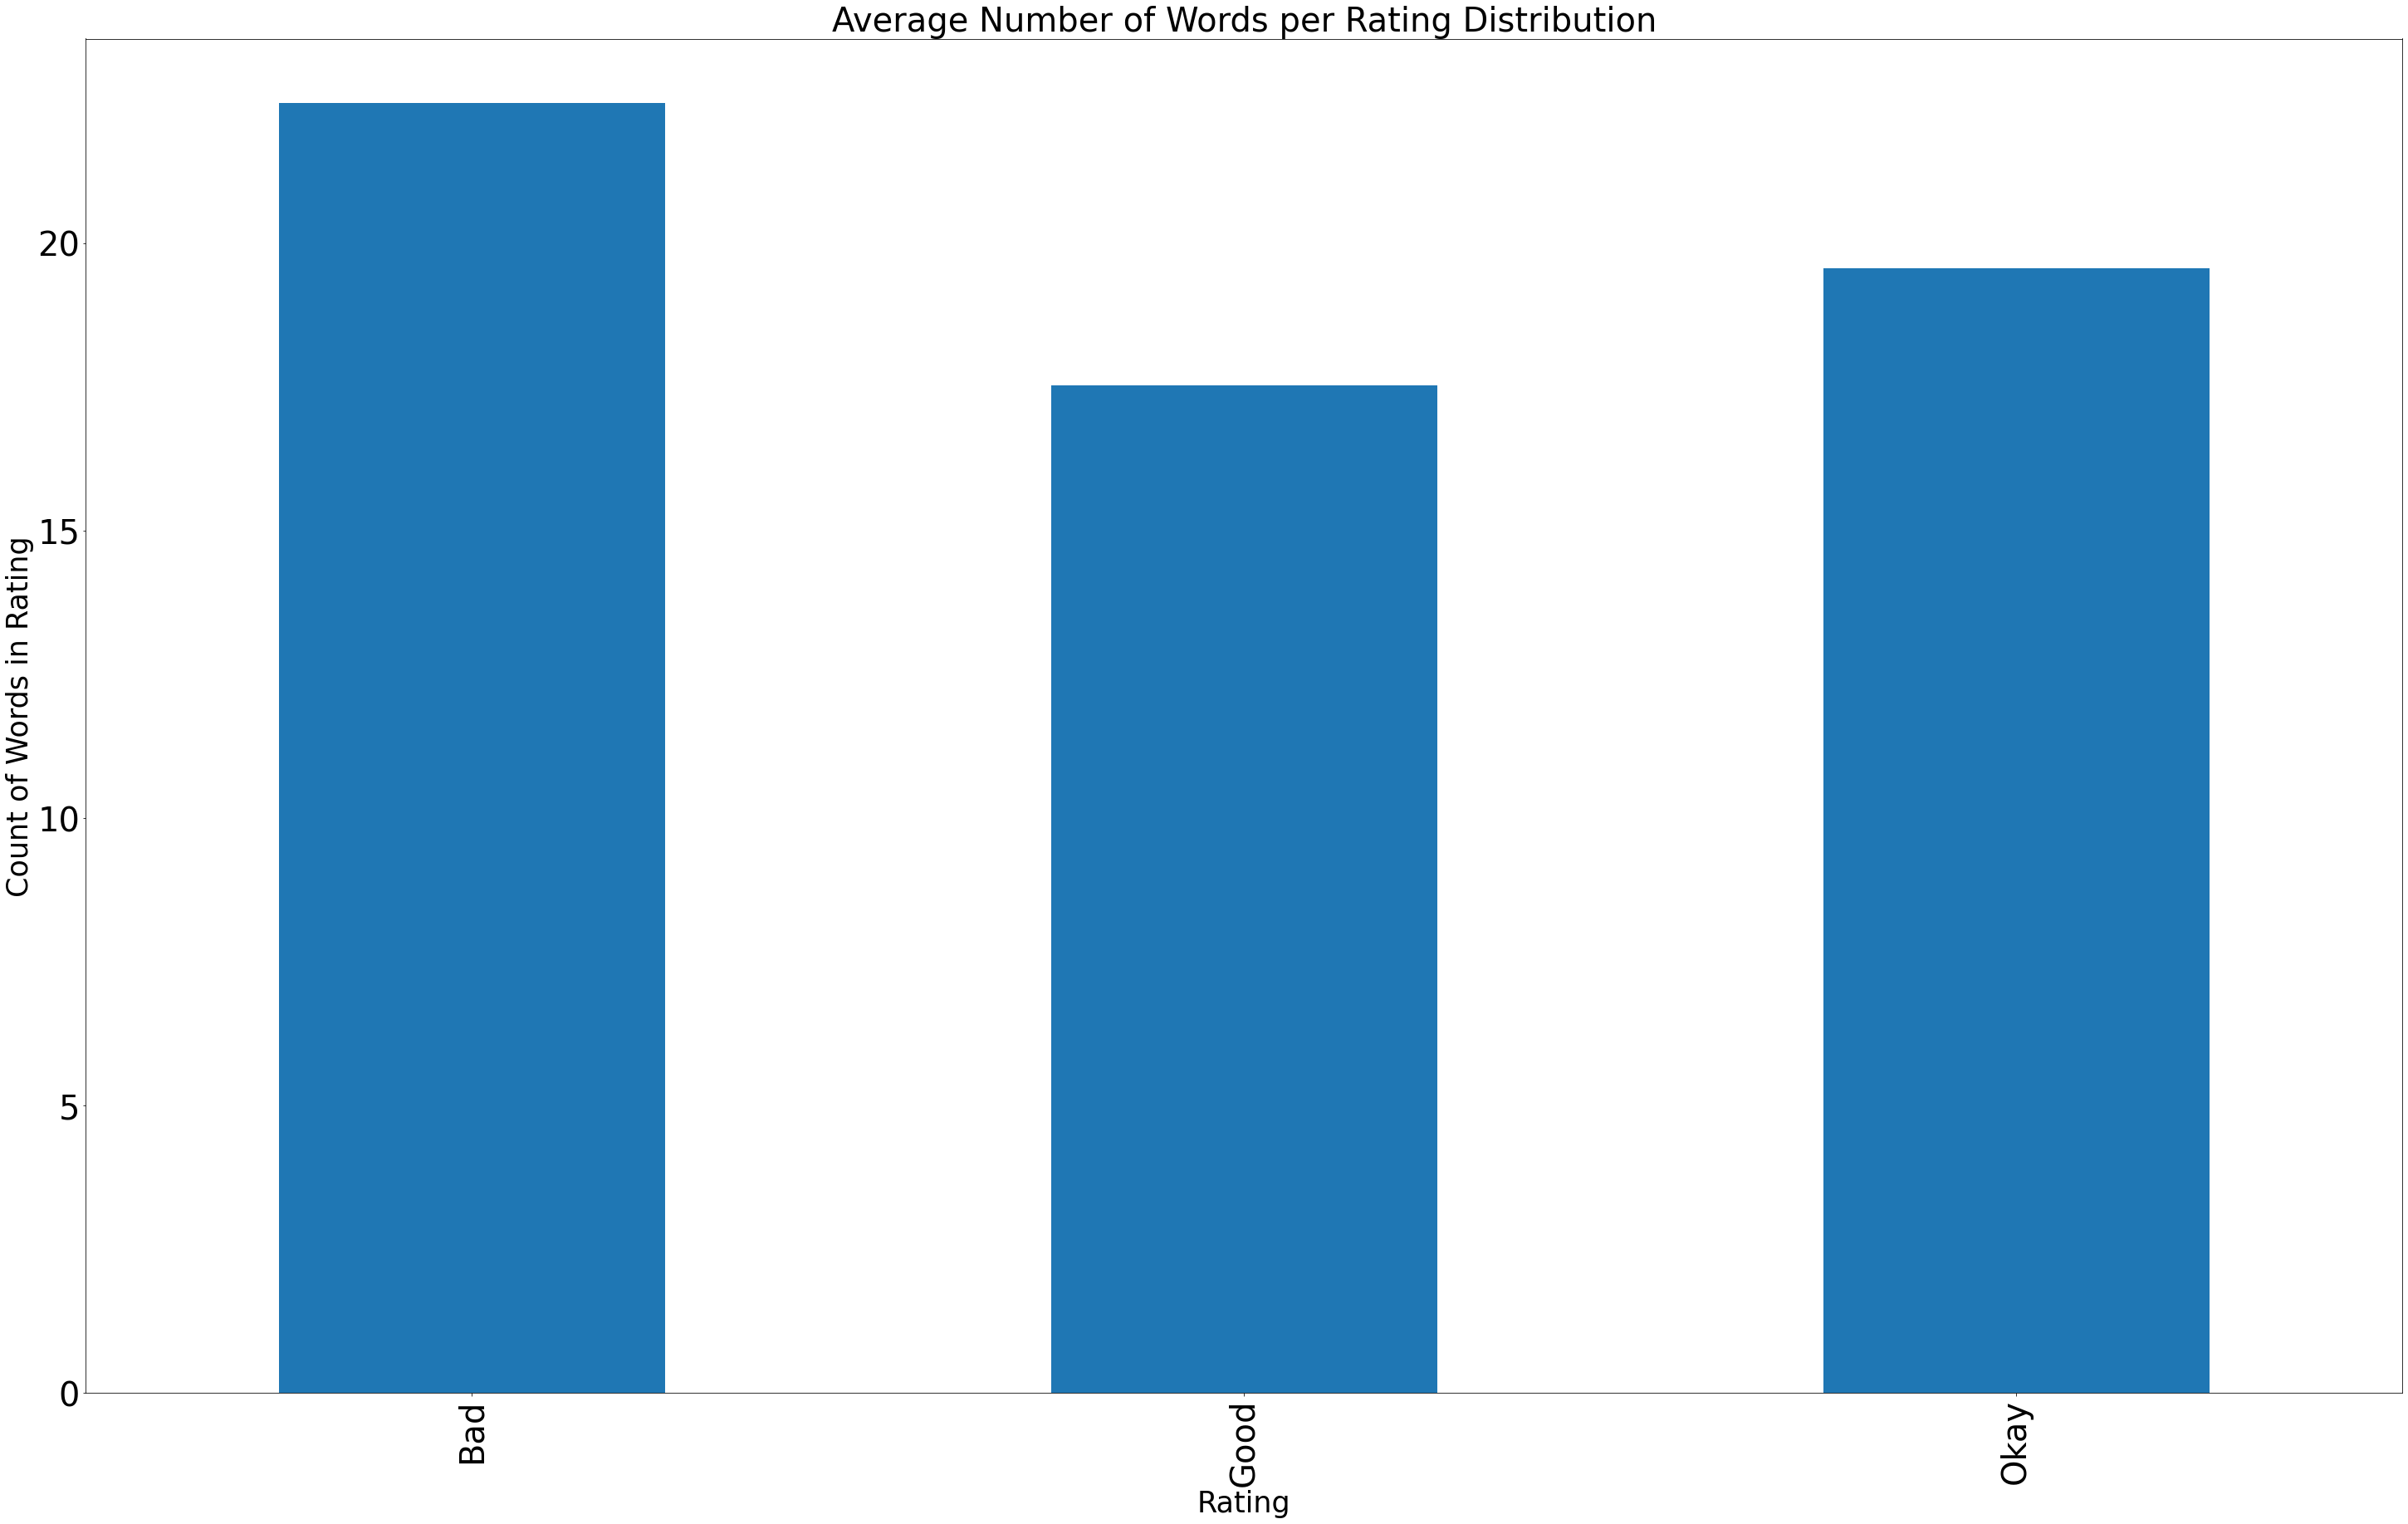

In [207]:
word_avg = df4.groupby('happiness_rating')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Words in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Rating Distribution', fontsize=40)
plt.show()

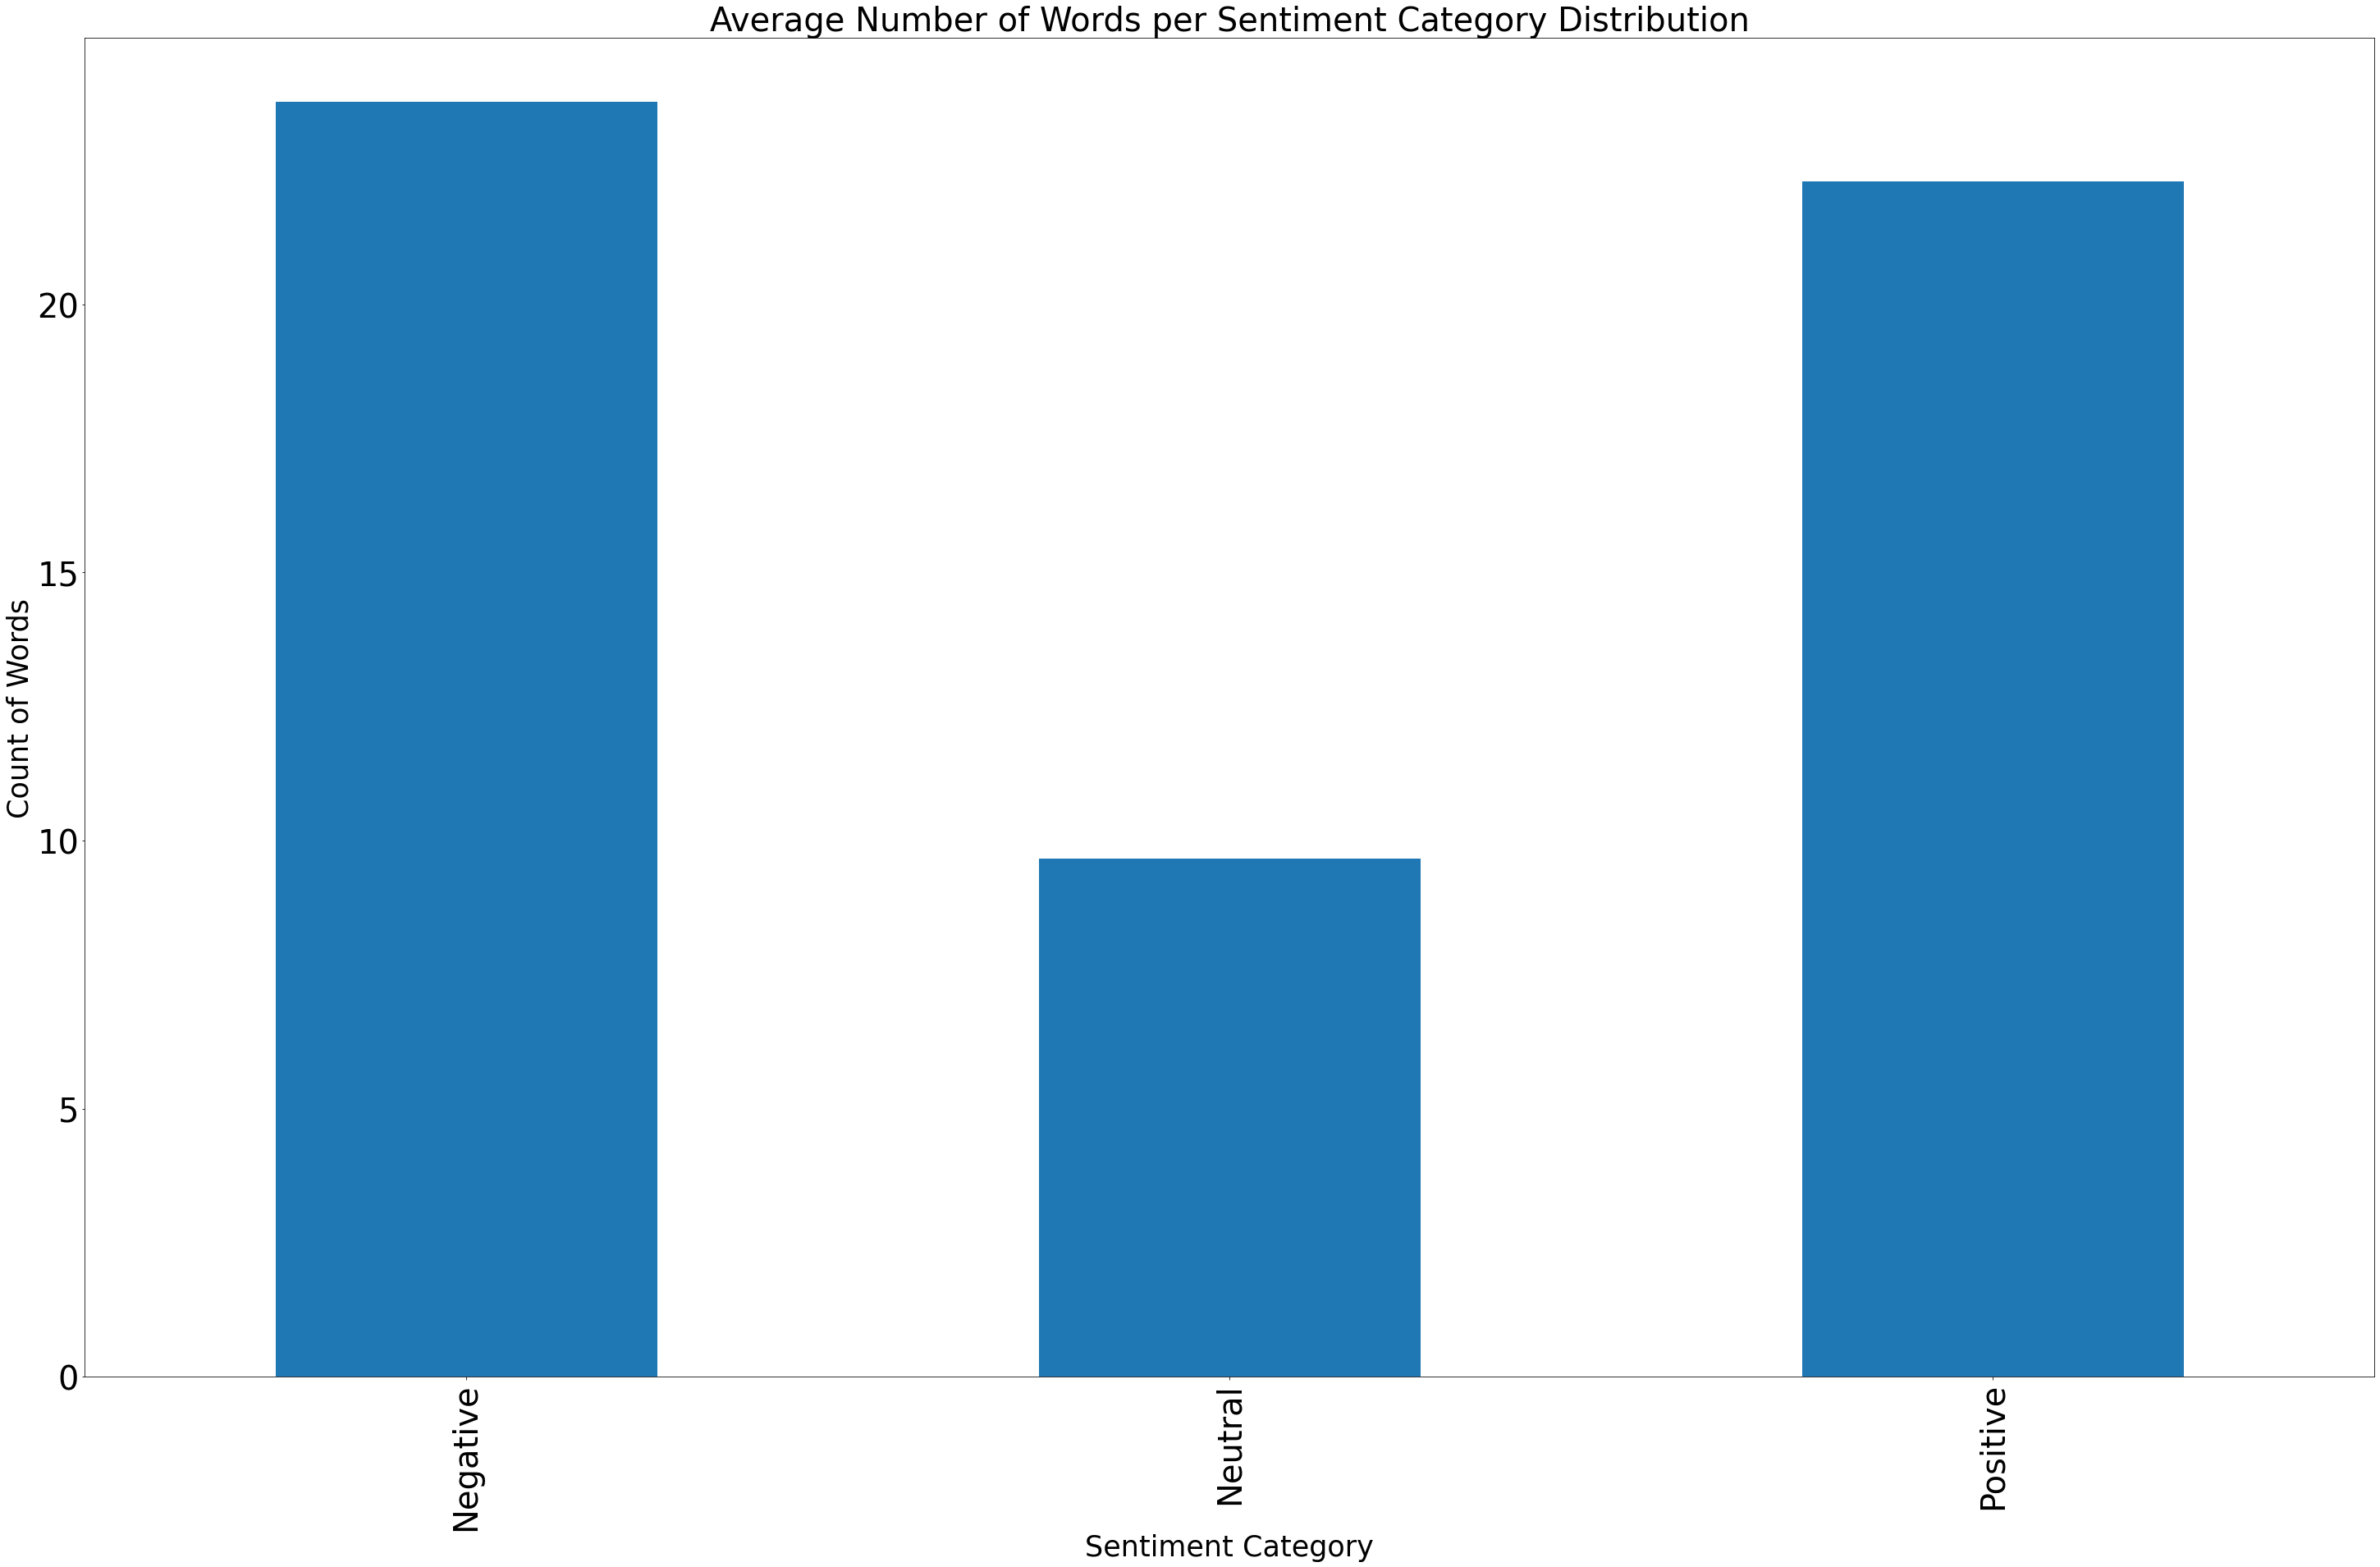

In [208]:
word_avg = df4.groupby('senti_category')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Sentiment Category', fontsize=35)
plt.ylabel('Count of Words', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Sentiment Category Distribution', fontsize=40)
plt.show()

In [ ]:
#df4['rating'] = df4['rating'].str.replace(r" ", '')
#pd.to_numeric(df4['rating'])

<AxesSubplot:>

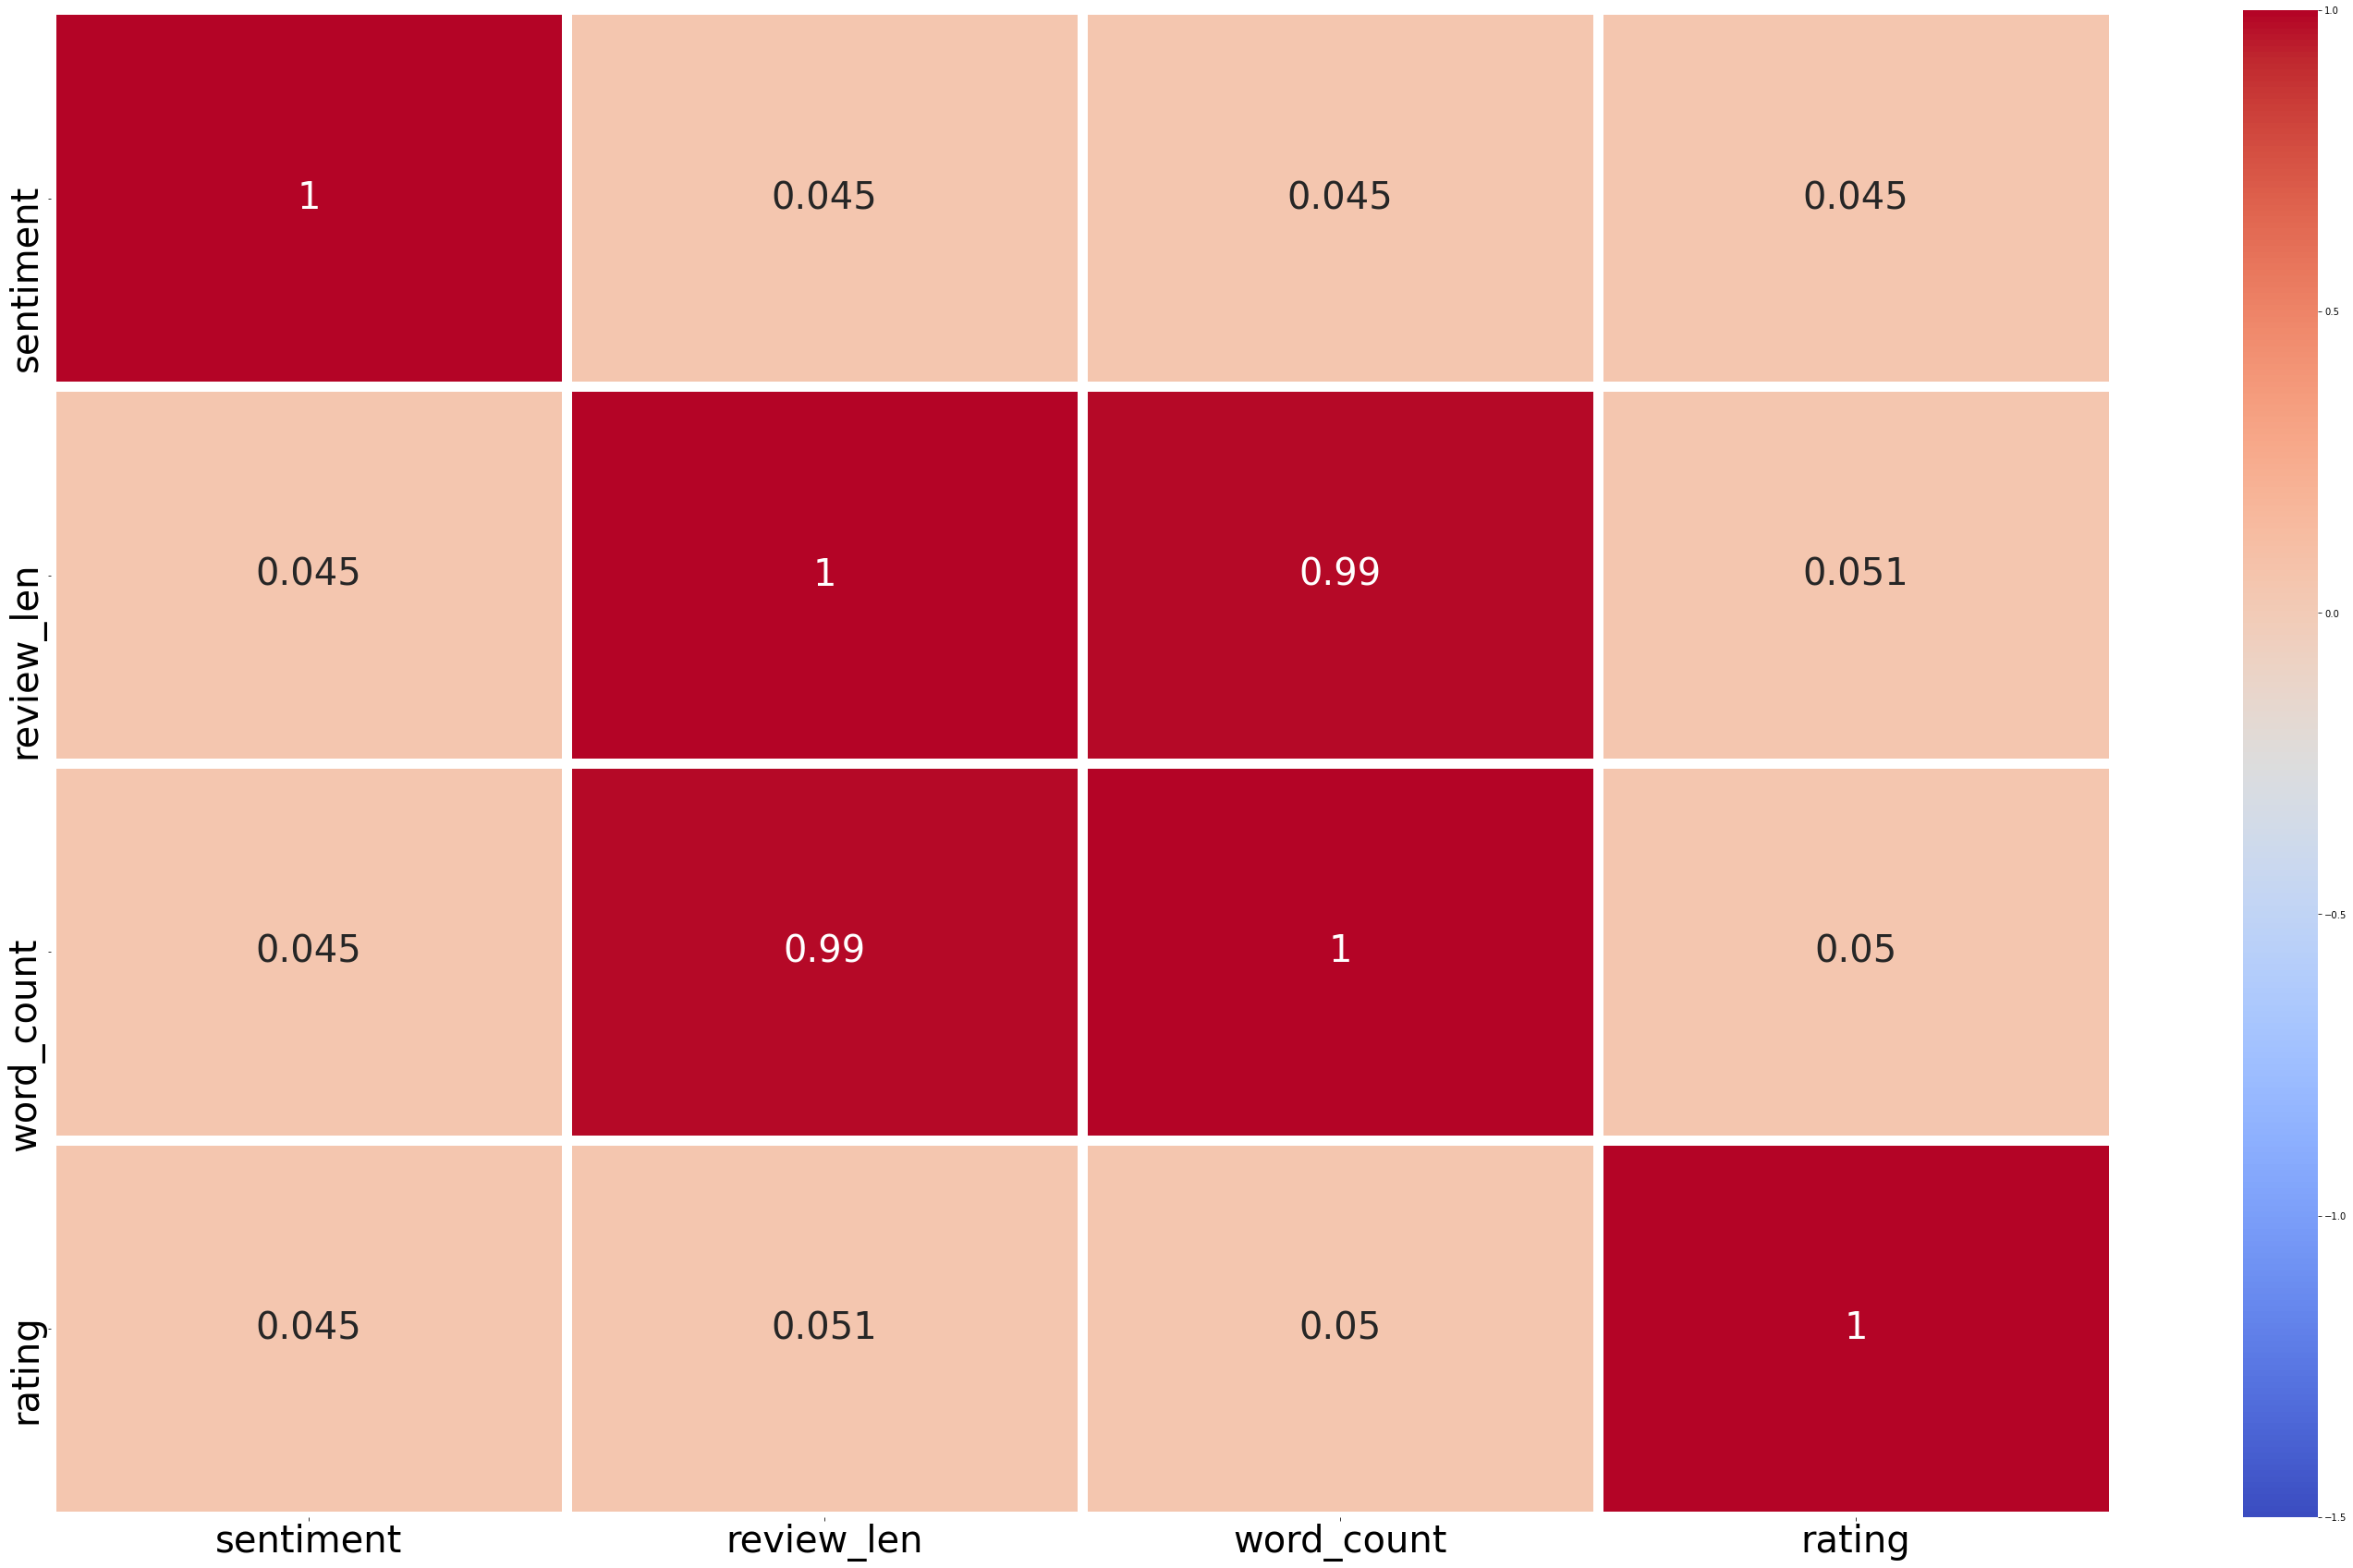

In [209]:
corr = df4[['sentiment', 'review_len', 'word_count','rating']].corr()
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(corr, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5)

## Term Frequency Analysis
### NLTK has a great library named “FreqDist” which allows us to determine the count of the most common terms in our corpus. First, we need to convert our individual lists of tokenized reviews into a comprehensive list of iterable tokens which stores all the reviews together. Finally, we pass FreqDist() the “allwords” object and apply the “most_common(100)” function to obtain the 100 most common words.

In [212]:
words = df3['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist
print(allwords)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



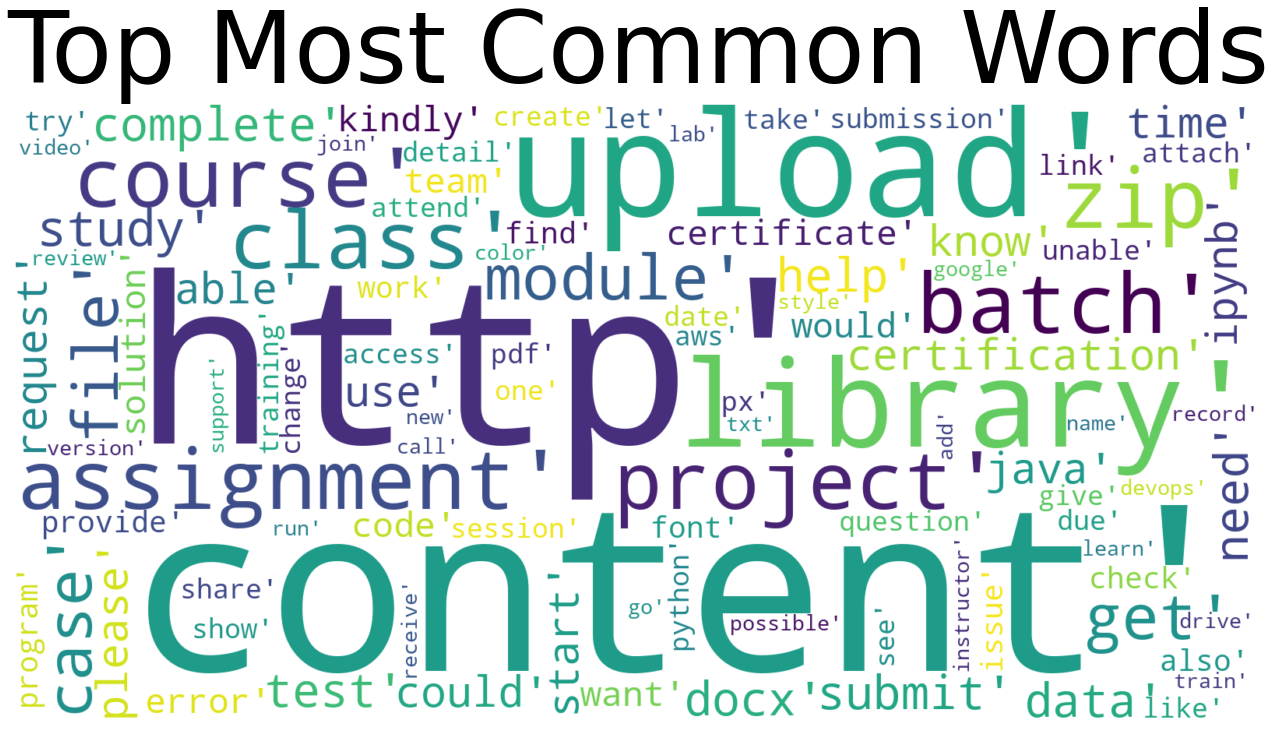

In [213]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

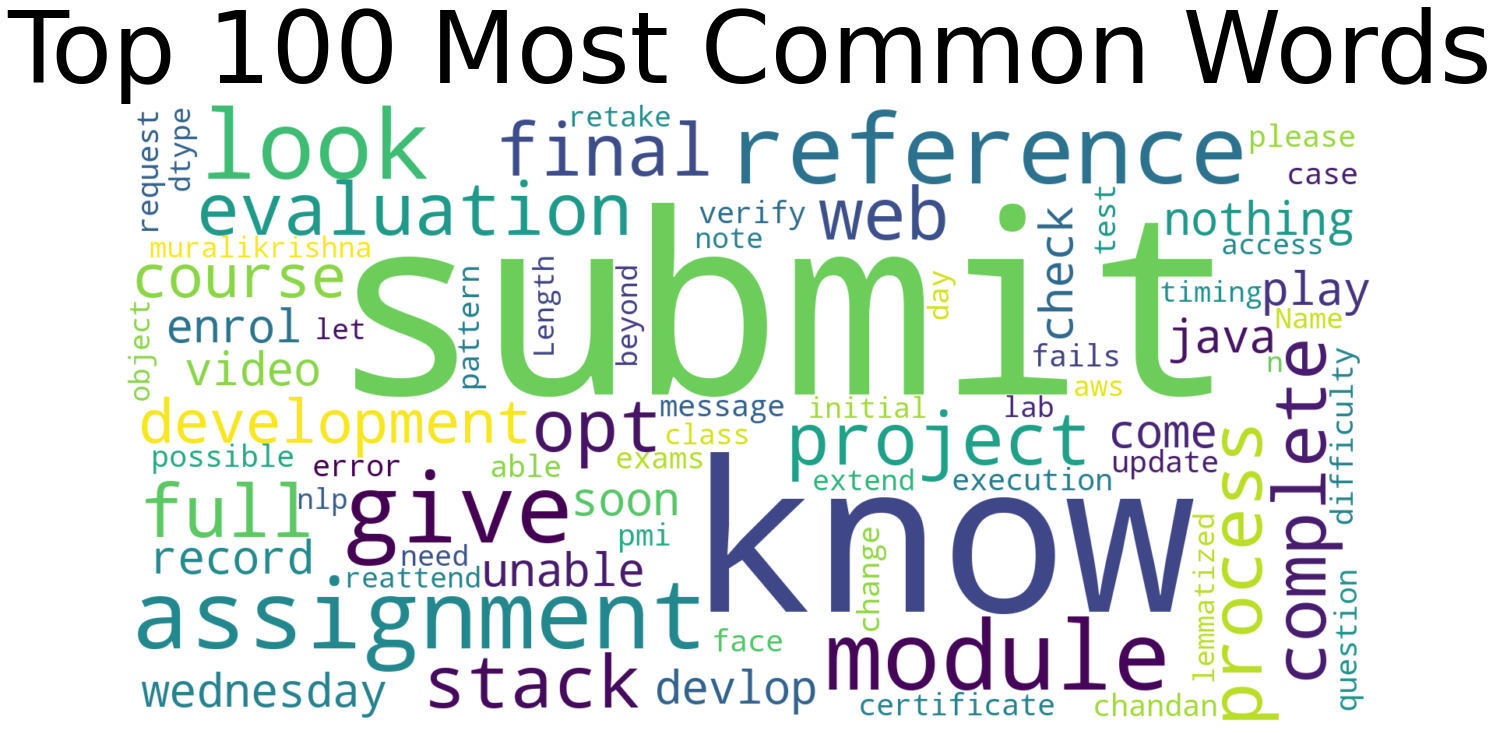

In [214]:
#mostcommon = FreqDist(words).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(words))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

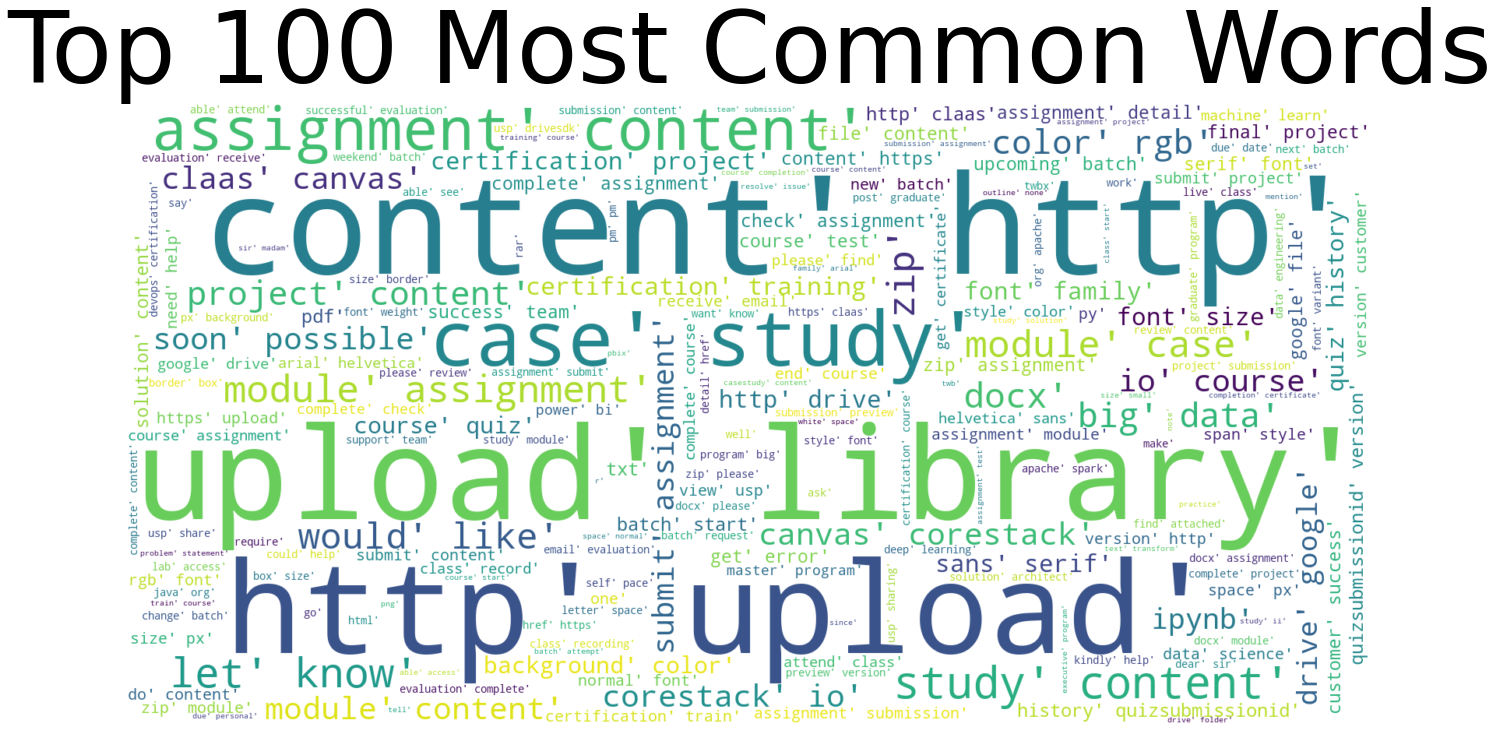

In [215]:
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(allwords))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

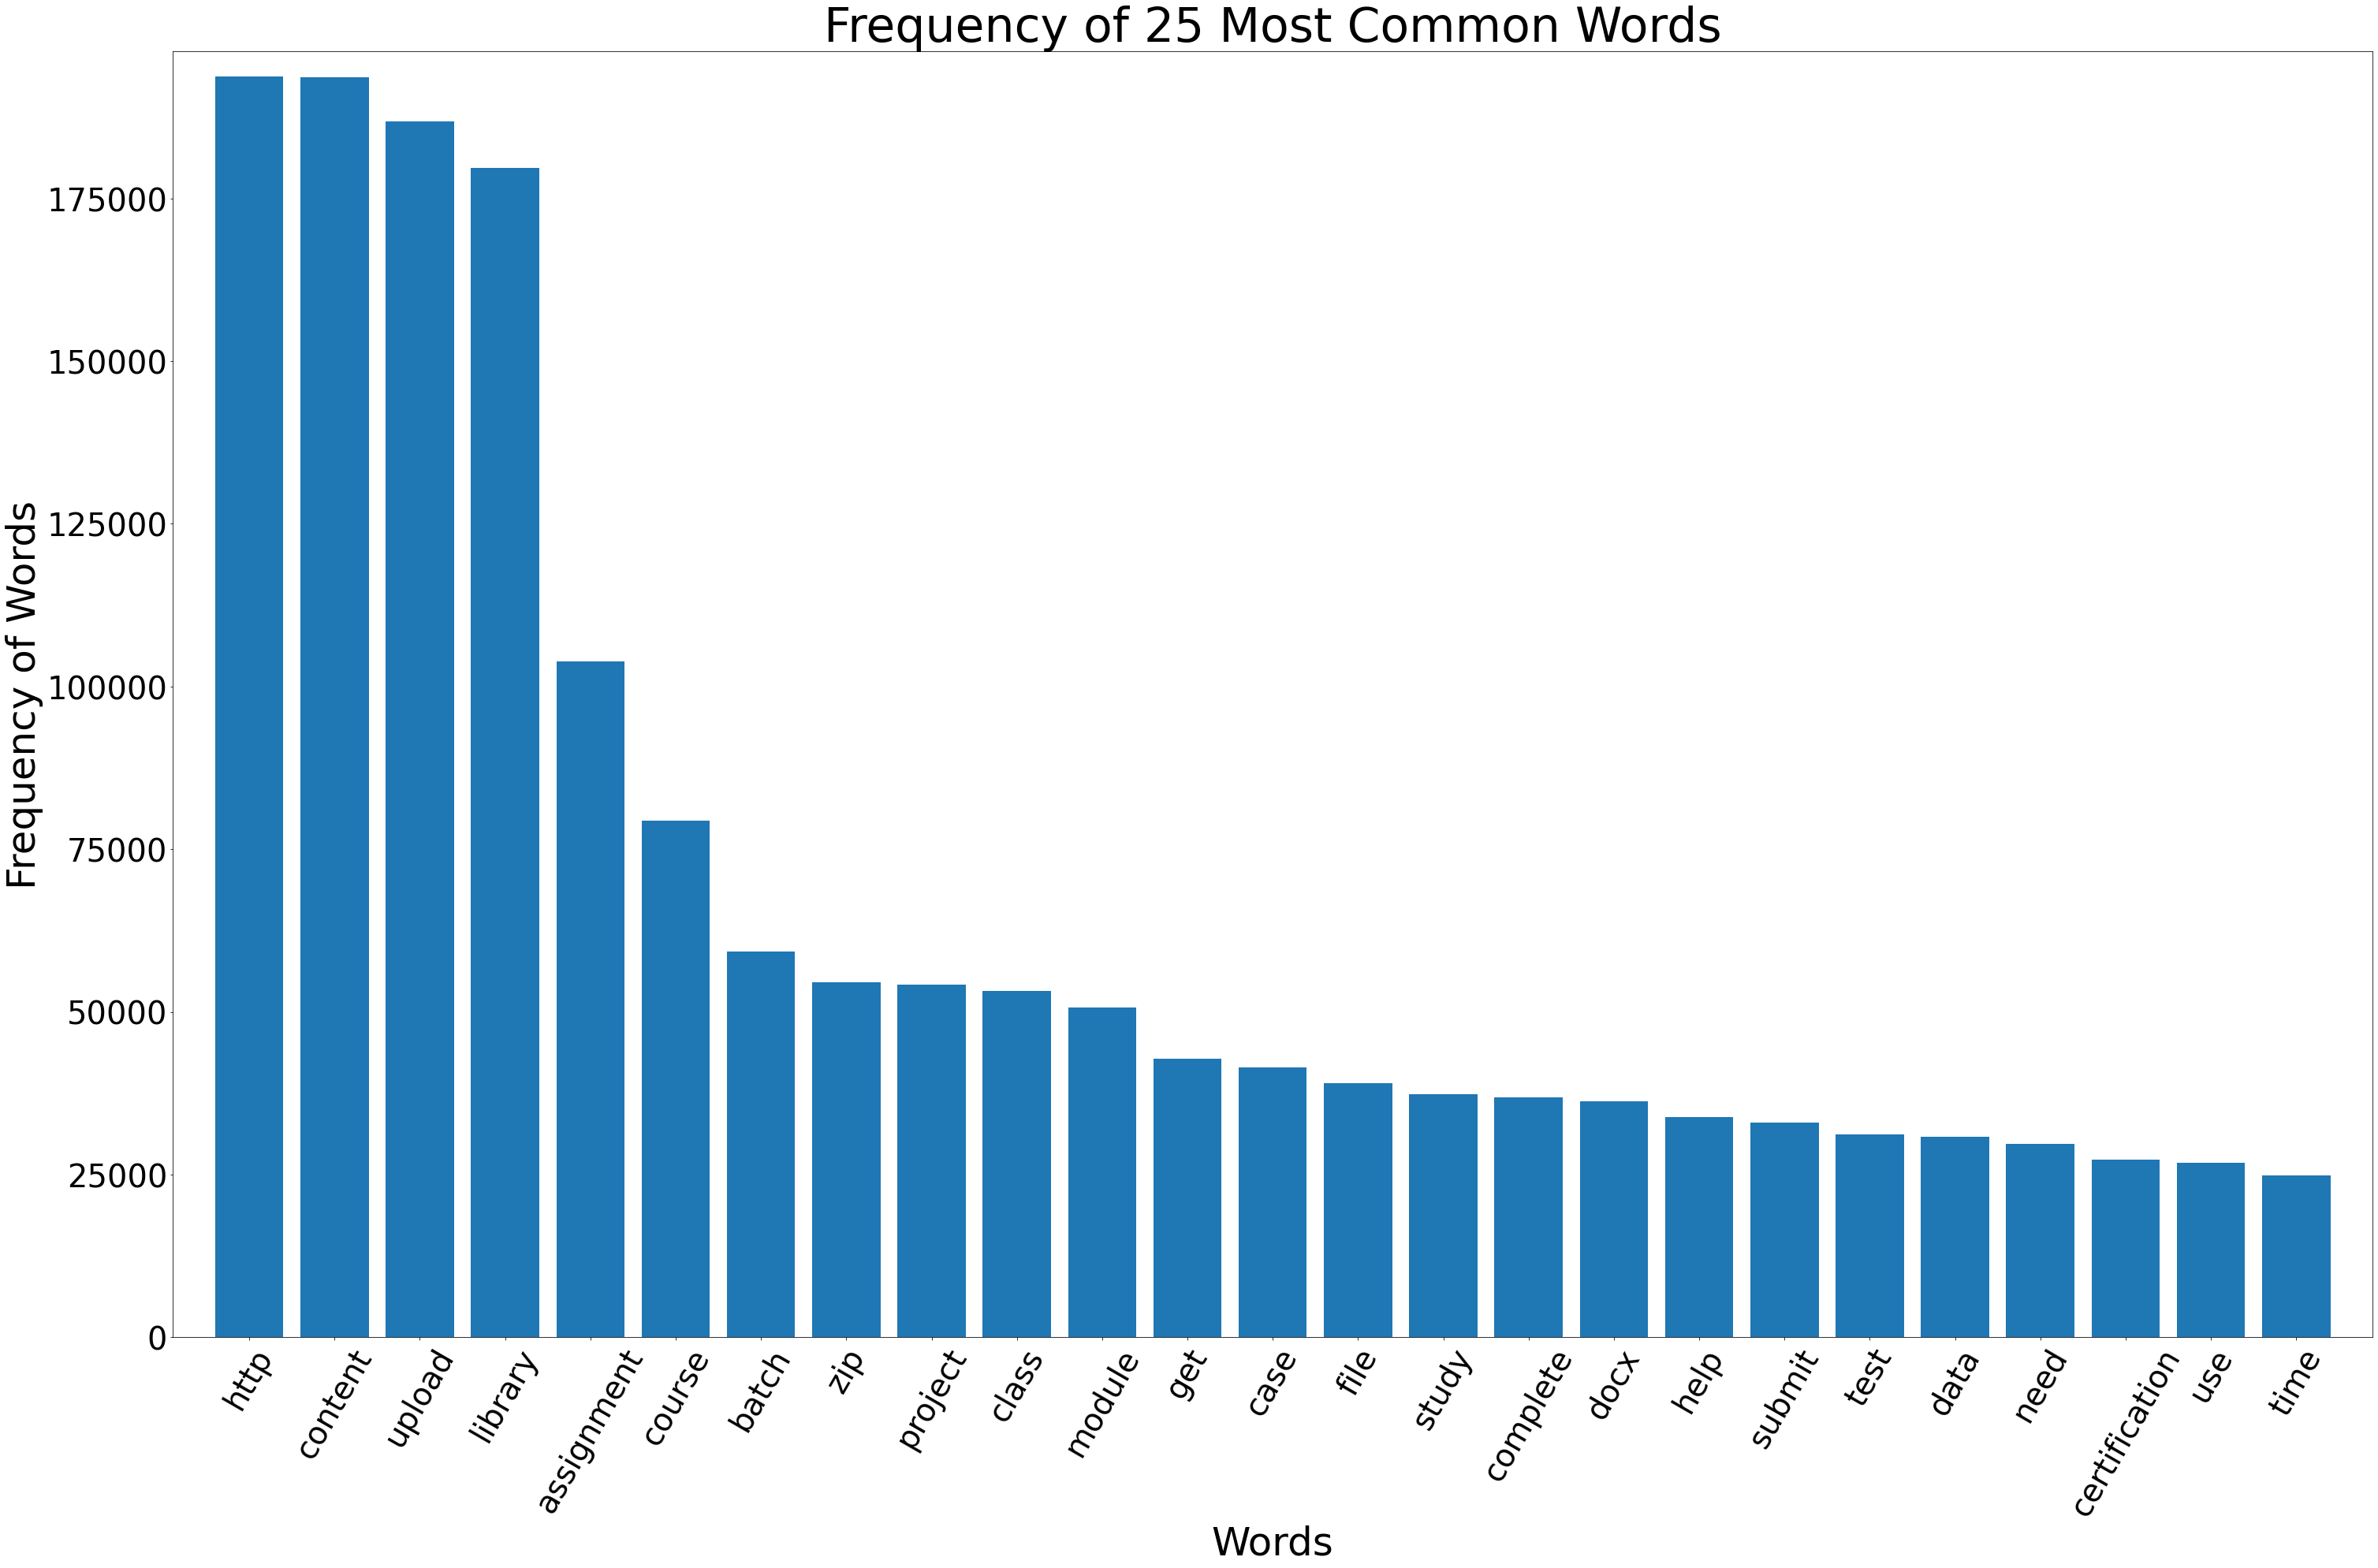

In [216]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

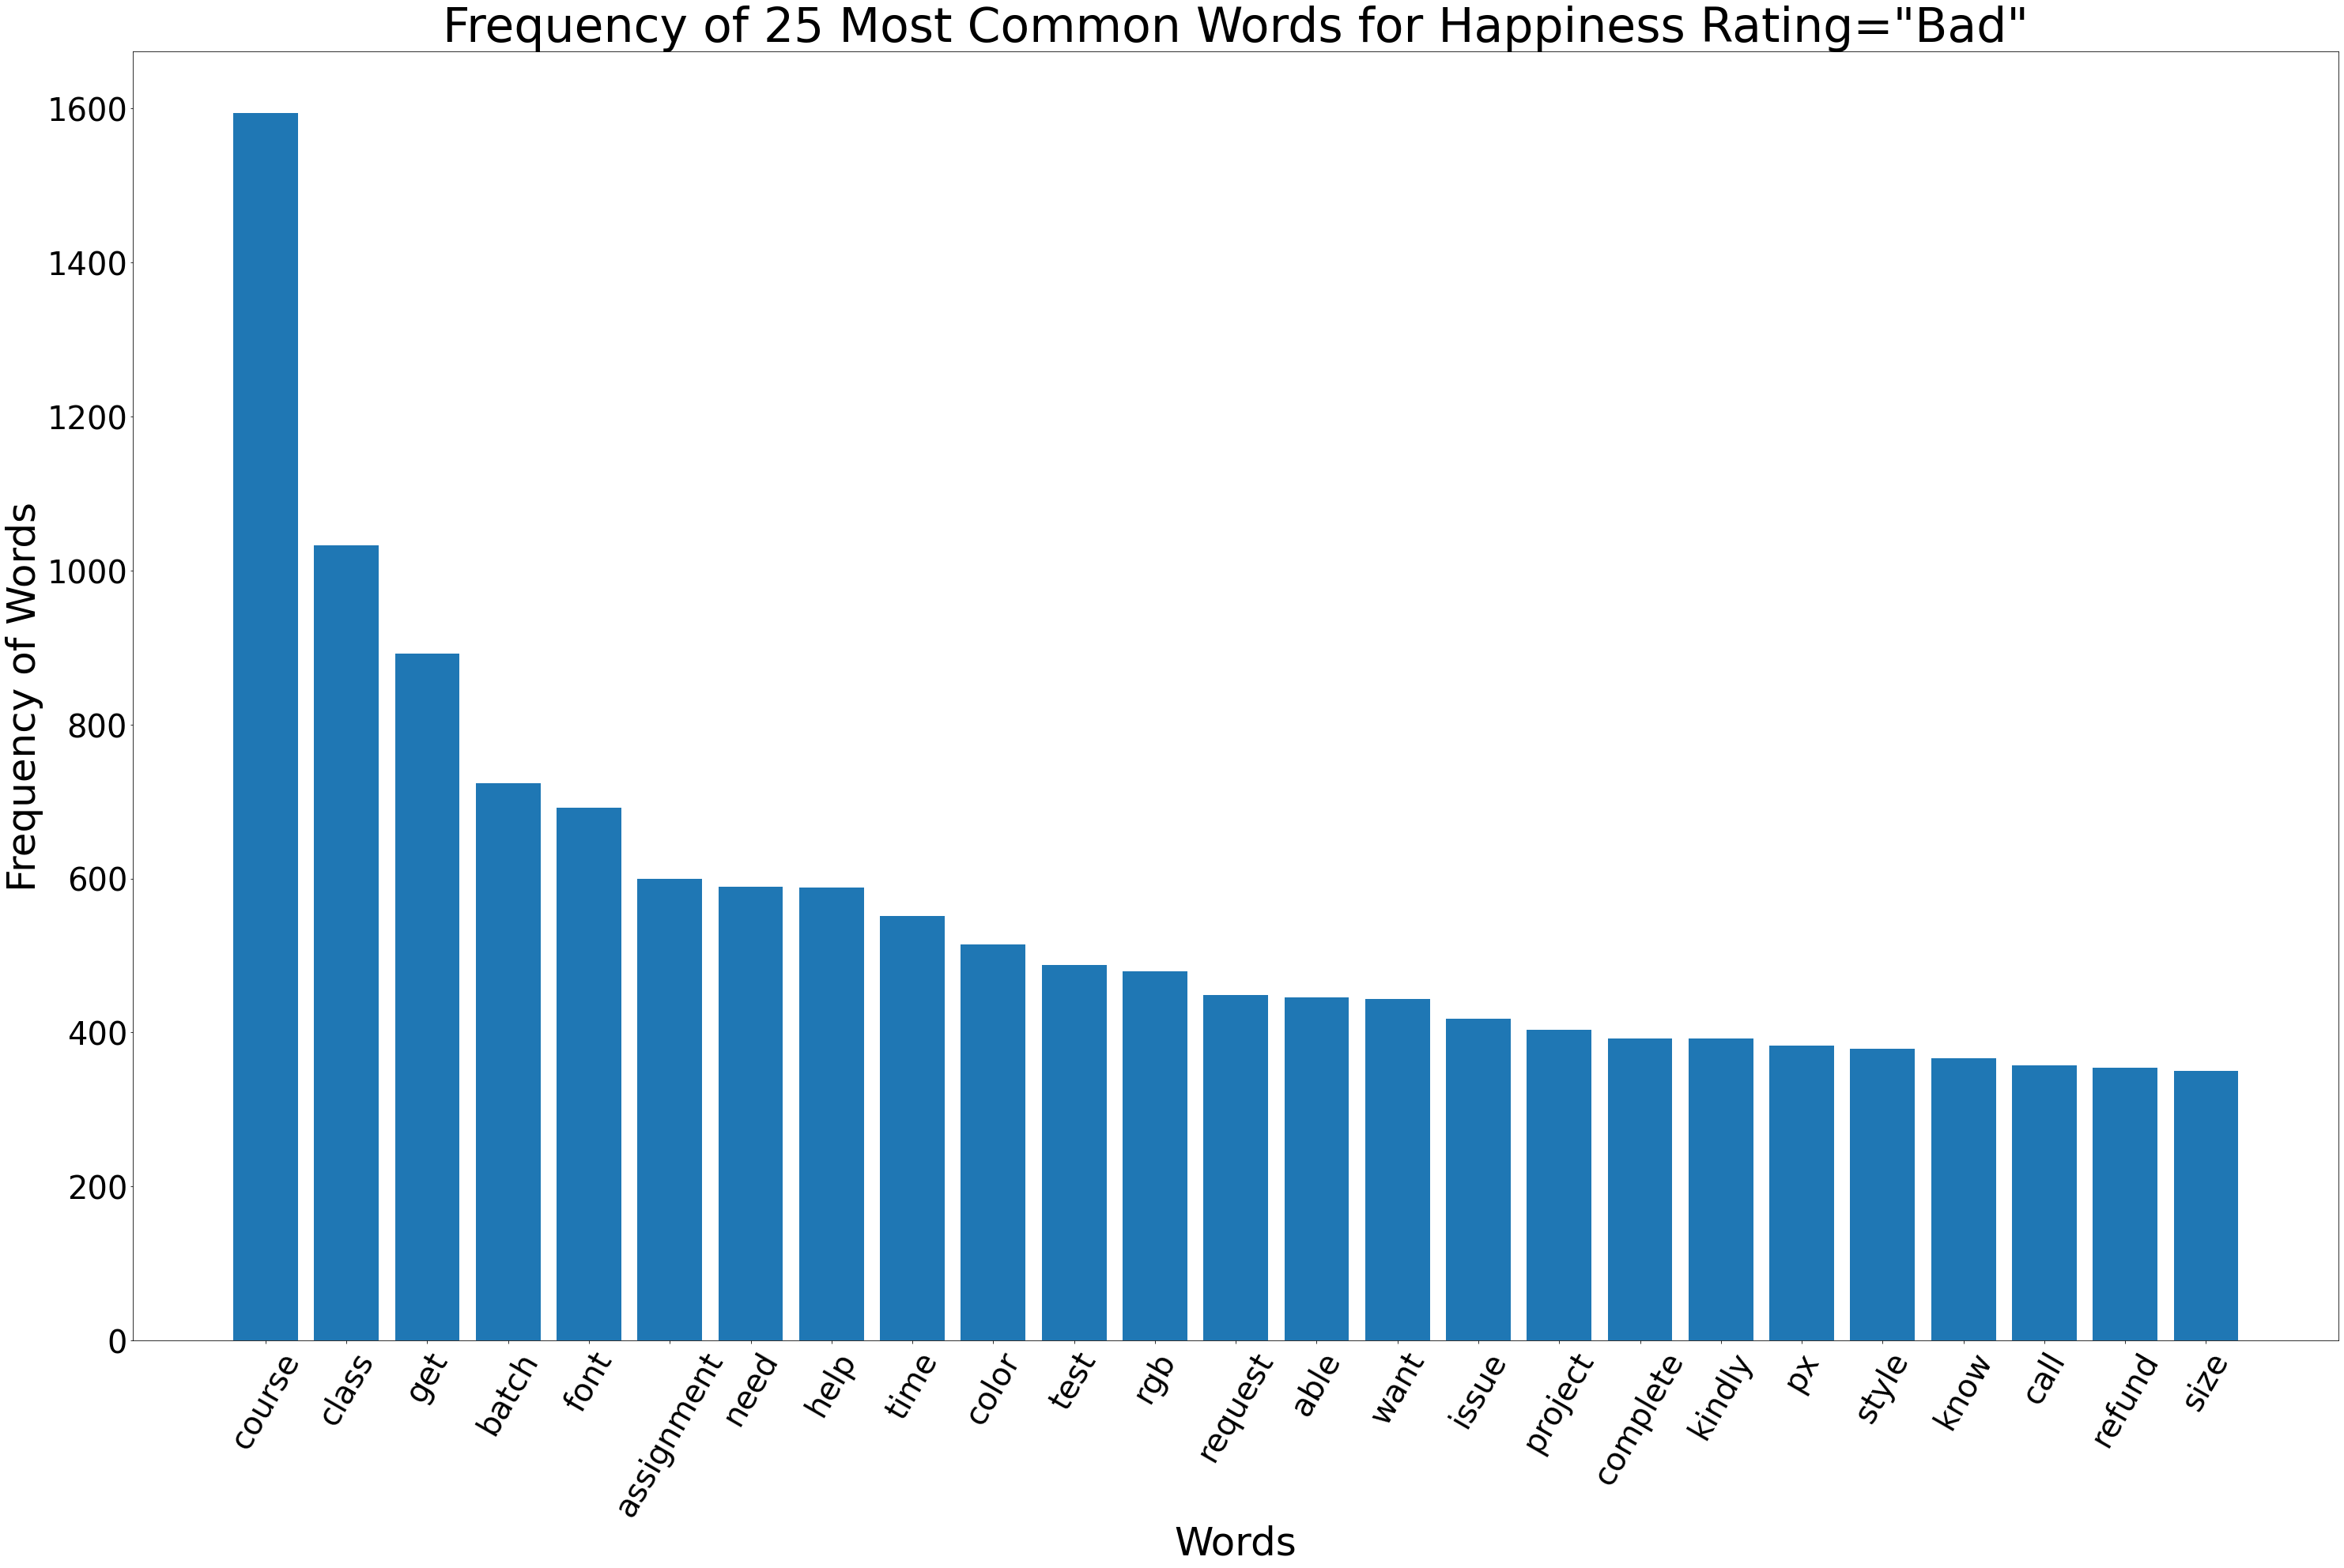

In [217]:
group_by = df3.groupby('happiness_rating')['lemma_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[0]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(50,30))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Happiness Rating="Bad"', fontsize=60)
plt.show()

In [218]:
group_by = df3.groupby('happiness_rating')['lemma_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by

happiness_rating
Bad     [(course, 1594), (class, 1033), (get, 892), (batch, 724), (font, 692), (assignment, 600), (need,...
Good    [(course, 15501), (batch, 12587), (assignment, 11789), (project, 10004), (class, 9336), (get, 92...
Okay    [(course, 530), (class, 487), (get, 481), (assignment, 396), (help, 350), (test, 302), (need, 28...
Name: lemma_str, dtype: object

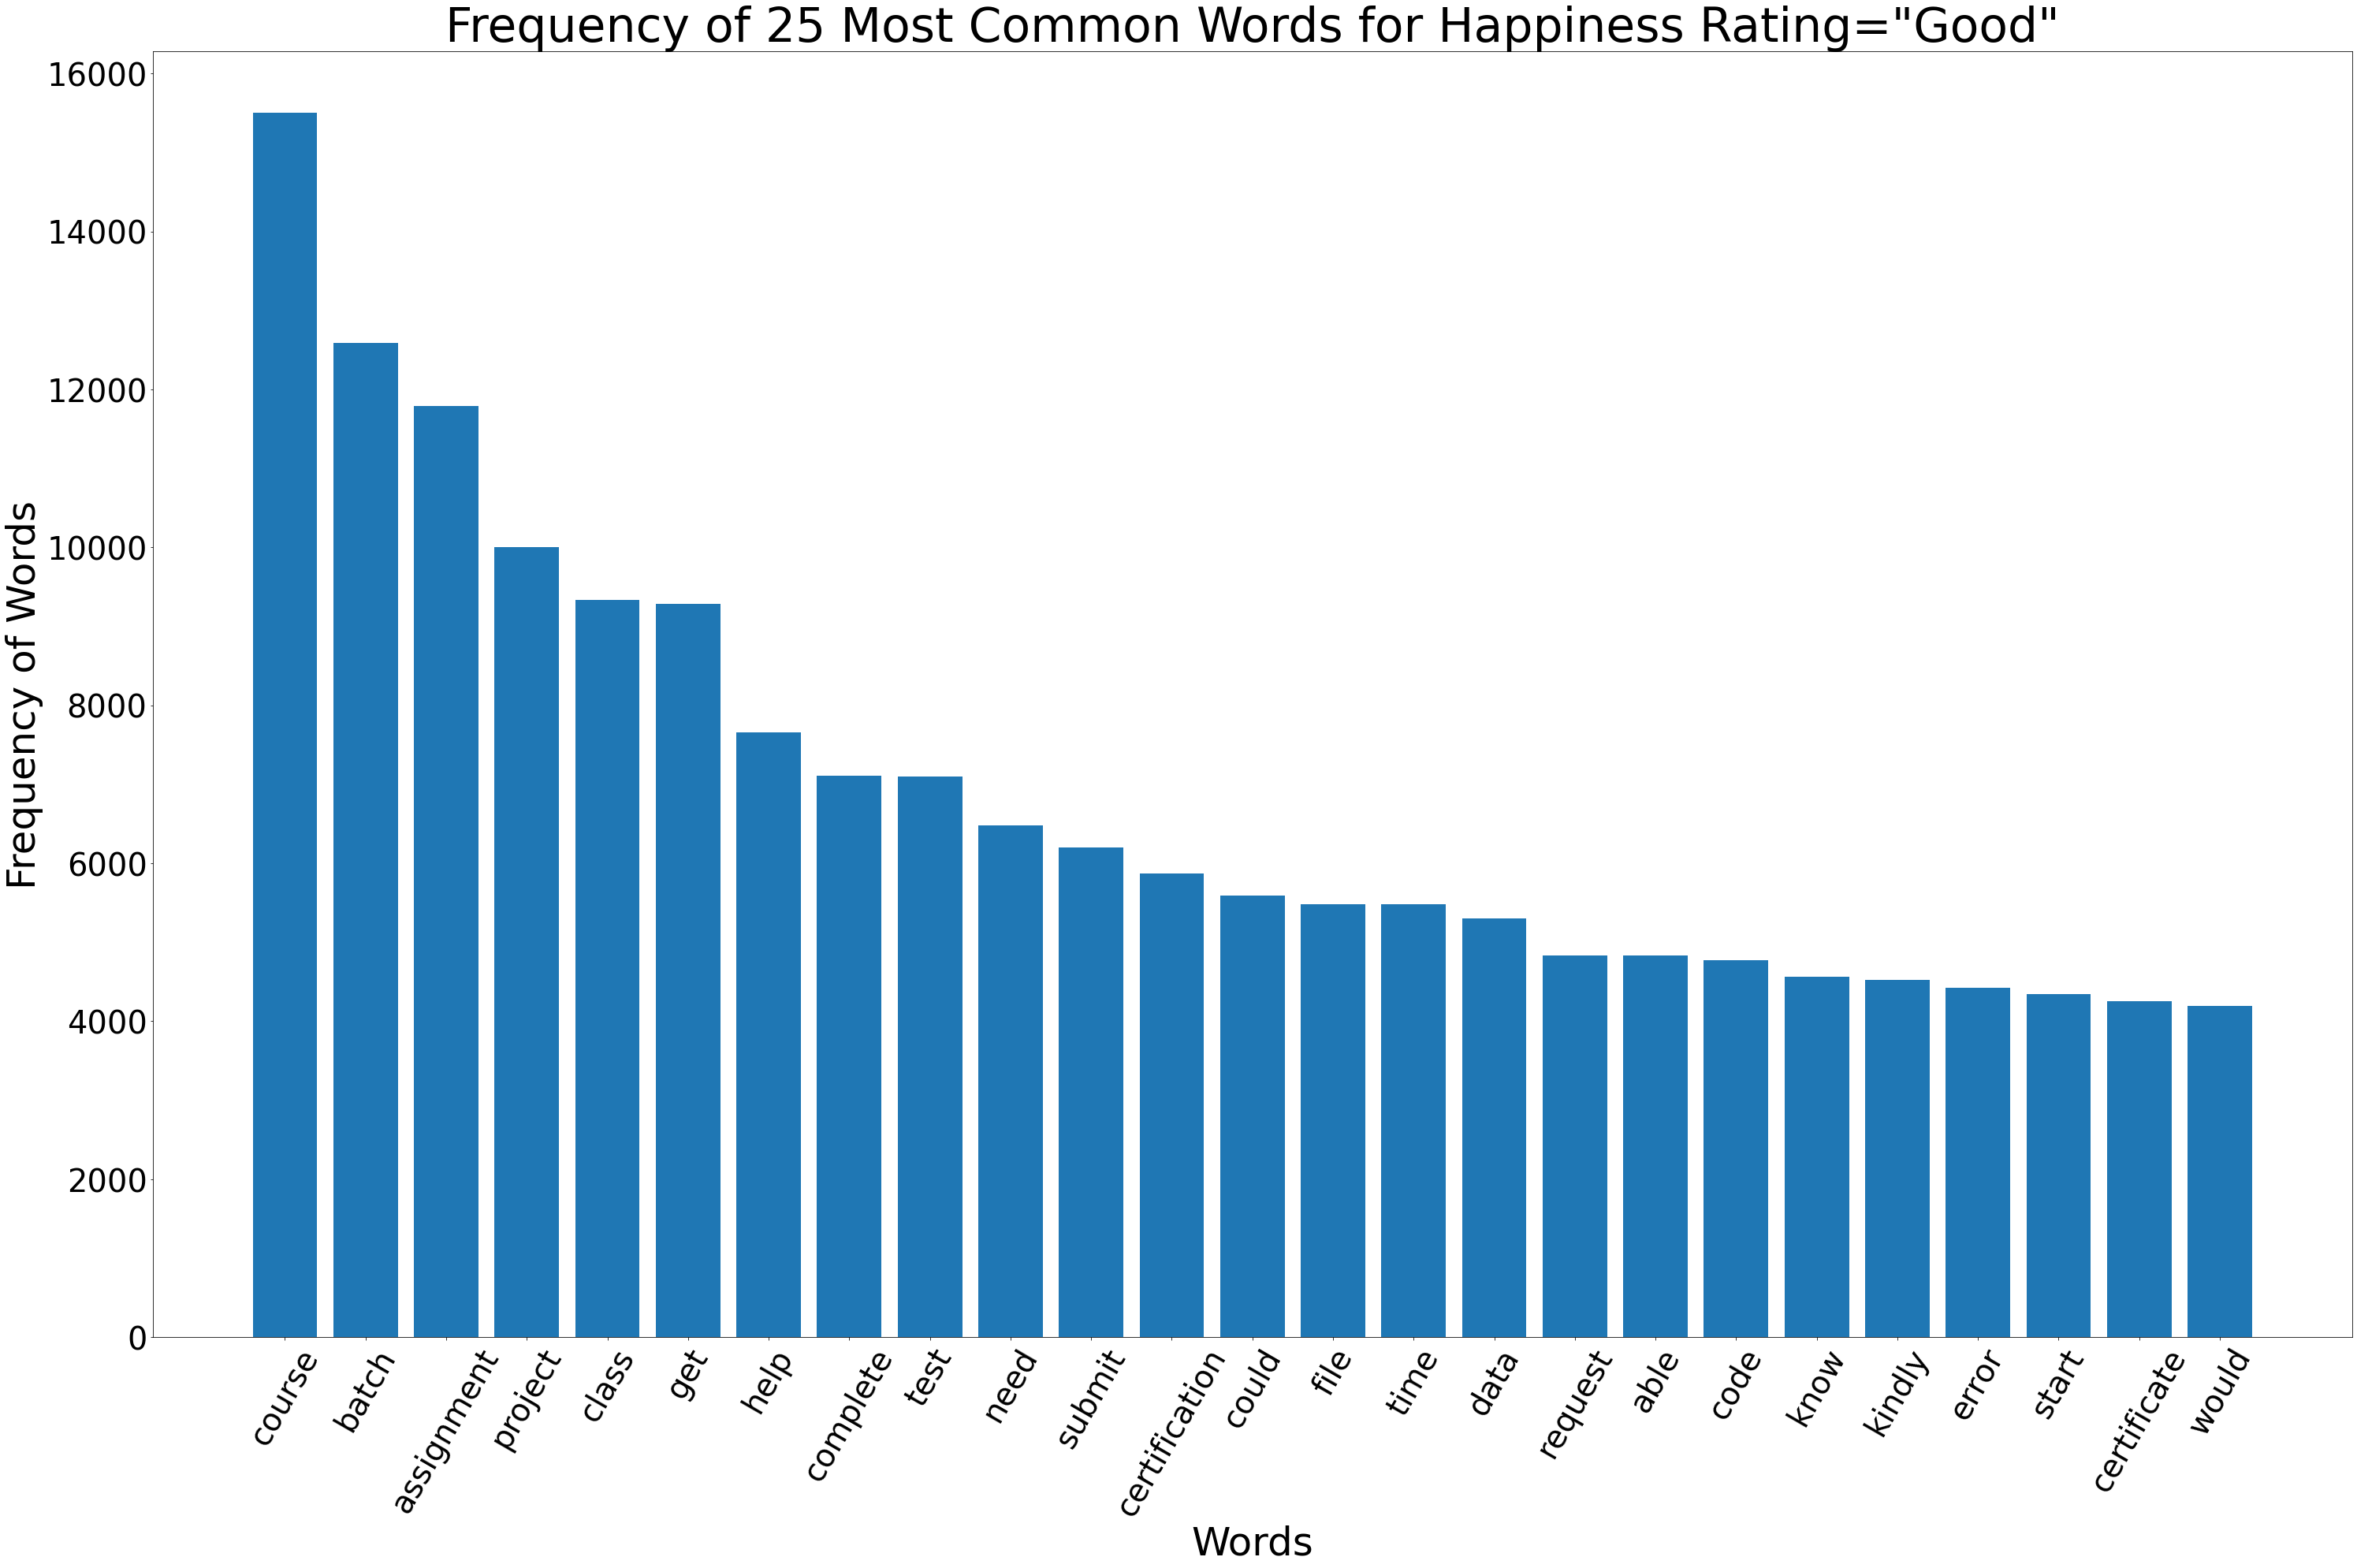

In [219]:
group_by_1 = group_by.iloc[1]
words1 = list(zip(*group_by_1))[0]
freq1 = list(zip(*group_by_1))[1]
plt.figure(figsize=(50,30))
plt.bar(words1, freq1)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Happiness Rating="Good"', fontsize=60)
plt.show()

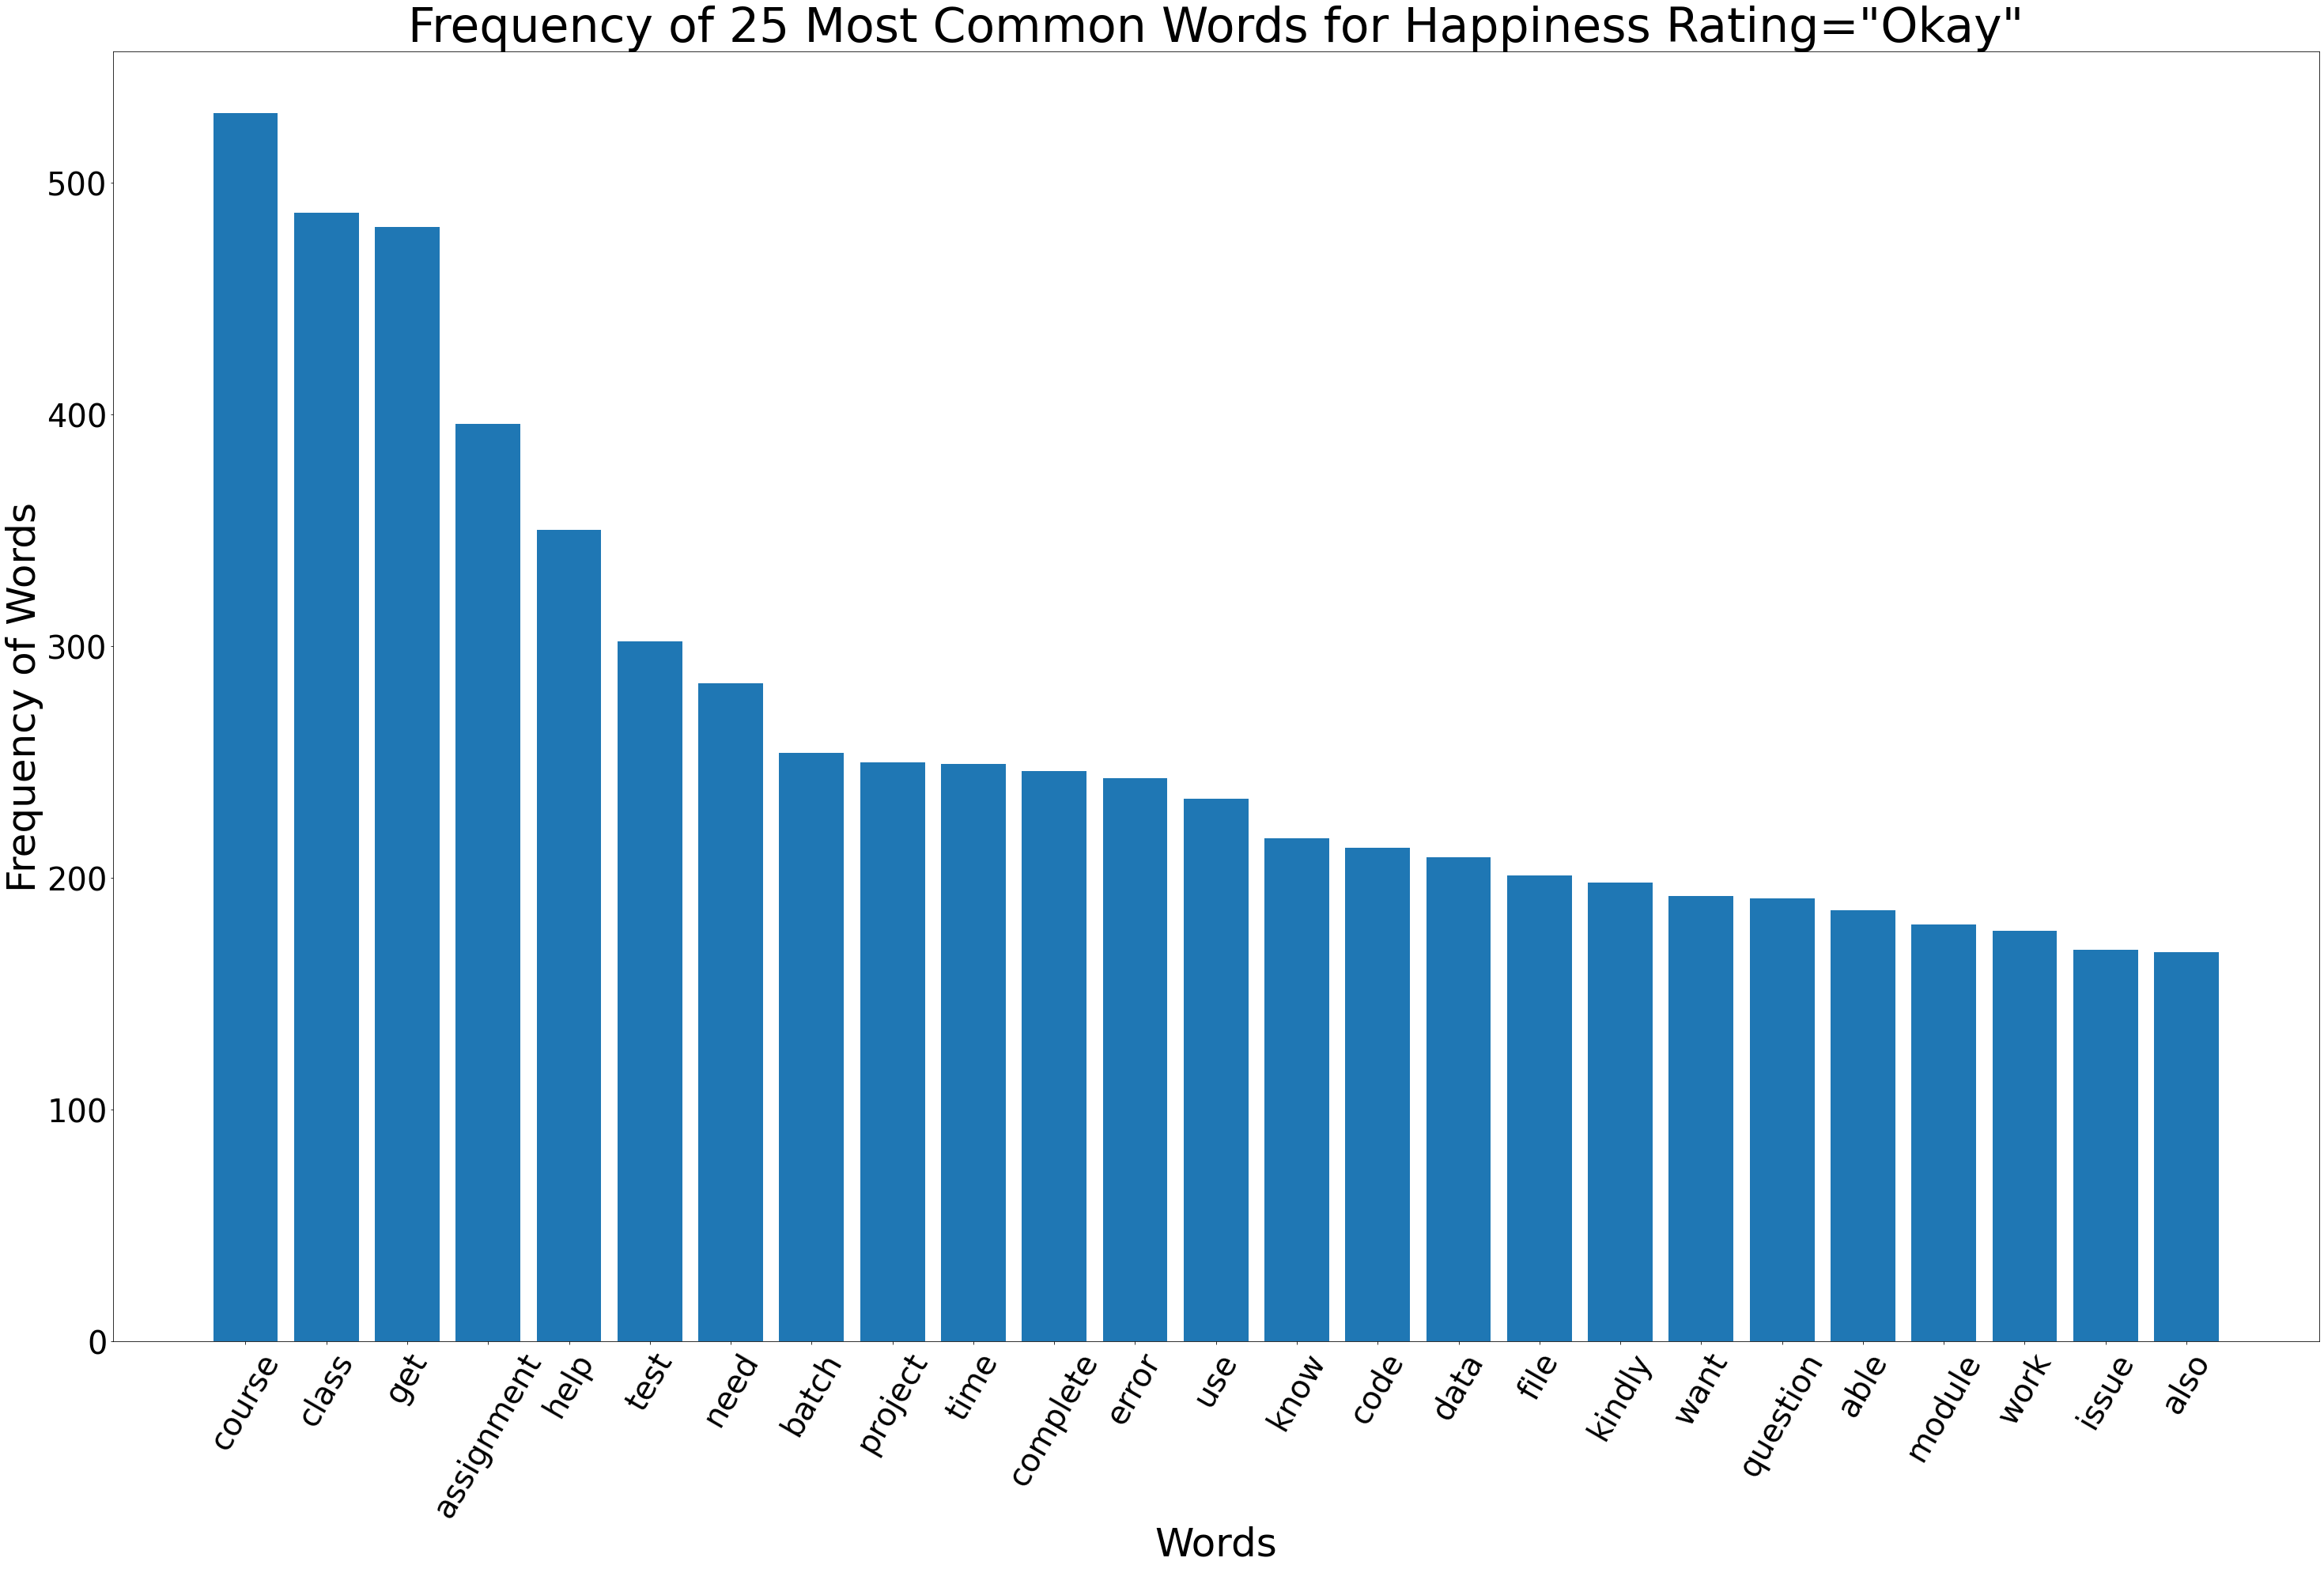

In [220]:
group_by_2 = group_by.iloc[2]
words2 = list(zip(*group_by_2))[0]
freq2 = list(zip(*group_by_2))[1]
plt.figure(figsize=(50,30))
plt.bar(words2, freq2)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Happiness Rating="Okay"', fontsize=60)
plt.show()

In [239]:
df_t = df3
df_t.dropna(subset=["happiness_rating"],inplace=True)
df_t.isna().sum()
df_t

freshdesk_id happiness_rating  \
13              2087             Good   
14              2088              Bad   
62              2141             Good   
72              2152             Good   
77              2157             Good   
...              ...              ...   
424670        444364             Good   
424678        444375             Good   
424679        444376             Good   
424688        444386             Good   
424693        444393             Good   

                                                                                                 lemmatized  \
13      [face, difficulty, submit, question, execution, give, error, message, submit, fails, test, case,...   
14                       [tire, lot, able, figure, proceed, maybe, syntax, group, percentile, clear, guide]   
62      [need, help, step, assignment, build, random, forest, classifier, preferably, perform, step, tog...   
72      [support, seem, bit, difficult, follow, topic, demo, bit, old, course, update, course, last, goo...   
77      [need, pmp, certification, exam, train, bit, early, request, change, devops, certification, trai...   
...                                                                                                     ...   
424670  [let, know, cloud, architect, master, program, batch, go, start, month, iam, look, batch, always...   
424678                                                                       [package, deploy, application]   
424679  [submit, machine, learn, test, kindly, consider, manual, checking, code, machine, learn, test, m...   
424688  [iam, unable, see, big, data, architect, master, progam, course, check, note, register, techmast...   
424693             [data, bind, animation, topic, touch, yet, cover, next, weekend, class, due, date, help]   

                                                                                                  lemma_str  \
13      face difficulty submit question execution give error message submit fails test case let know wro...   
14                                   tire lot able figure proceed maybe syntax group percentile clear guide   
62      need help step assignment build random forest classifier preferably perform step together use pi...   
72      support seem bit difficult follow topic demo bit old course update course last good batch one pr...   
77      need pmp certification exam train bit early request change devops certification train plm mr kum...   
...                                                                                                     ...   
424670  let know cloud architect master program batch go start month iam look batch always say current b...   
424678                                                                           package deploy application   
424679             submit machine learn test kindly consider manual checking code machine learn test module   
424688       iam unable see big data architect master progam course check note register techmasters program   
424693                           data bind animation topic touch yet cover next weekend class due date help   

        sentiment  
13      -0.142857  
14       0.300000  
62      -0.266667  
72       0.075000  
77       0.025000  
...           ...  
424670   0.000000  
424678   0.000000  
424679   0.600000  
424688  -0.250000  
424693  -0.062500  

[58454 rows x 5 columns]

# Topic Modeling
### Finally, let’s apply a few topic modeling algorithms to help derive specific topics or themes for our reviews. Before we have determined the topics for each rating we have to perform one additional processing step. Right now our data/words are still readable to us human beings whereas computers only understand numbers. We need to convert our text into numbers or vectors.

## CountVectorizer
### The CountVectorizer method of vectorizing tokens transposes all the words/tokens into features and then provides a count of occurrence of each word. The result is called a document term matrix, which you can see below.

### First, we create the vectorizer object. Max_df=0.9 will remove words that appear in more than 90% of the reviews. Min_df=25 will remove words that appear in less than 25 reviews. Next, we create the spare matrix as the result of fit_transform(). Finally, we create a list of all the words/features. The result is our document term matrix. Each row represents individual employee reviews and counts of how many times each word/feature occurs in each review.

In [240]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(df_t['lemma_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

aa  aakash  ab  abhinav  abhishek  able  absent  absolutely  accept  \
0       0       0   0        0         0     0       0           0       0   
1       0       0   0        0         0     1       0           0       0   
2       0       0   0        0         0     0       0           0       0   
3       0       0   0        0         0     0       0           0       0   
4       0       0   0        0         0     0       0           0       0   
...    ..     ...  ..      ...       ...   ...     ...         ...     ...   
58449   0       0   0        0         0     0       0           0       0   
58450   0       0   0        0         0     0       0           0       0   
58451   0       0   0        0         0     0       0           0       0   
58452   0       0   0        0         0     0       0           0       0   
58453   0       0   0        0         0     0       0           0       0   

       acceptable  ...  yesterday  yet  yml  youtube  ytest  ytrain  yum  \
0               0  ...          0    0    0        0      0       0    0   
1               0  ...          0    0    0        0      0       0    0   
2               0  ...          0    0    0        0      0       0    0   
3               0  ...          0    0    0        0      0       0    0   
4               0  ...          0    0    0        0      0       0    0   
...           ...  ...        ...  ...  ...      ...    ...     ...  ...   
58449           0  ...          0    0    0        0      0       0    0   
58450           0  ...          0    0    0        0      0       0    0   
58451           0  ...          0    0    0        0      0       0    0   
58452           0  ...          0    0    0        0      0       0    0   
58453           0  ...          0    1    0        0      0       0    0   

       zero  zip  zone  
0         0    0     0  
1         0    0     0  
2         0    0     0  
3         0    0     0  
4         0    0     0  
...     ...  ...   ...  
58449     0    0     0  
58450     0    0     0  
58451     0    0     0  
58452     0    0     0  
58453     0    0     0  

[58454 rows x 2355 columns]

## Latent Dirichlet Allocation (LDA) Topic Modeling

### Now that we have prepared our data for topic modeling, we’ll be using the Latent Dirichlet Allocation (LDA) approach to determine the topics present in our corpus. In our model, we are going to produce 10 individual topics (ie. n_components). Once the model is created let’s create a function to display the identified topics. Each topic will consist of 10 words. The function will have three required parameters; the LDA model, feature names from the document term matrix, and the number of words per topic.

In [241]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
code error get attach link output try issue find help
Topic 1:
know access let module case study lab receive detail lm
Topic 2:
font px name color style rgb size span print value
Topic 3:
batch class would start session like attend record want request
Topic 4:
java org version system spark apache io https git selenium
Topic 5:
test assignment question submit solution learn check show mark code
Topic 6:
project assignment submit http upload content date library extend submission
Topic 7:
please help share error jenkins get use docker install try
Topic 8:
course certification certificate get complete program request training time python
Topic 9:
data file use big create box none explain set csv


## pyLDAvis
### pyLDAvis is an interactive LDA visualization python library. Each circle represents a unique topic, the size of the circle represents the importance of the topic and finally, the distance between each circle represents how similar the topics are to each other. Selecting a topic/circle will reveal a horizontal bar chart displaying the 30 most relevant words for the topic along with the frequency of each word appearing in the topic and the overall corpus.

### The relevance metric helps to distinguish words which are distinct/exclusive to the topic (λλ closer to 0.0) and words which have a high probability of being included in the selected topic (λλ closer to 1.0).

In [242]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3      32.420952   8.115230       1        1  20.452206
8       0.648955  71.707100       2        1  15.087263
5      71.019684   9.971006       3        1  10.163834
6       3.785981  33.185135       4        1   9.264122
1     -42.666500  -9.222070       5        1   8.990161
0      -3.621689 -43.526516       6        1   8.824616
7      -3.632402  -4.171708       7        1   8.710055
9     -36.584400  35.804413       8        1   6.324550
2      44.391380  50.615383       9        1   6.299435
4      40.235809 -31.591665      10        1   5.883757, topic_info=            Term          Freq         Total Category  logprob  loglift
460       course  17270.000000  17270.000000  Default  30.0000  30.0000
1597     project  10560.000000  10560.000000  Default  29.0000  29.0000
204        batch  13056.000000  13056.000000  Default  28.0000  28.0000
148   assignment  12645.000000  12645.000000  Default  27.0000  27.0000
2089        test   7853.000000   7853.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1802         run    897.111604   2536.973406  Topic10  -4.1205   1.7934
1950      source    429.436075    608.185660  Topic10  -4.8572   2.4850
255        build    436.295663    818.618436  Topic10  -4.8413   2.2037
697        error    618.842035   5062.534042  Topic10  -4.4918   0.7312
790         file    560.834035   6263.875257  Topic10  -4.5902   0.4198

[522 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
5         1  0.380222   able
5         2  0.051366   able
5         4  0.101430   able
5         5  0.204348   able
5         6  0.126741   able
...     ...       ...    ...
2331      9  0.149691  write
2343      8  0.999016   year
2346      2  0.396155    yet
2346      5  0.603497    yet
2353      4  0.998977    zip

[694 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 6, 7, 2, 1, 8, 10, 3, 5])

## TF-IDF

### LDA isn’t the only approach to topic modeling. Let’s try another method named the Non-Negative Matrix Factorization (NMF) approach and see if our topics can be slightly more defined. Instead of using the simple CountVectorizer method to vectorize our words/tokens, we’ll use the TF-IDF (Term Frequency — Inverse Document Frequency) method. The TF-IDF method helps to bring down the weight/impact of high-frequency words.

### Much like the CountVectorizer method we first create the vectorizer object. Max_df=0.9 will remove words that appear in more than 90% of the reviews. Min_df=25 will remove words that appear in less than 25 reviews. Next, we create the spare matrix as the result of fit_transform(). Finally, we create a list of all the words/features.

In [243]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df_t['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

aa  aakash   ab  abhinav  abhishek     able  absent  absolutely  \
0      0.0     0.0  0.0      0.0       0.0  0.00000     0.0         0.0   
1      0.0     0.0  0.0      0.0       0.0  0.16534     0.0         0.0   
2      0.0     0.0  0.0      0.0       0.0  0.00000     0.0         0.0   
3      0.0     0.0  0.0      0.0       0.0  0.00000     0.0         0.0   
4      0.0     0.0  0.0      0.0       0.0  0.00000     0.0         0.0   
...    ...     ...  ...      ...       ...      ...     ...         ...   
58449  0.0     0.0  0.0      0.0       0.0  0.00000     0.0         0.0   
58450  0.0     0.0  0.0      0.0       0.0  0.00000     0.0         0.0   
58451  0.0     0.0  0.0      0.0       0.0  0.00000     0.0         0.0   
58452  0.0     0.0  0.0      0.0       0.0  0.00000     0.0         0.0   
58453  0.0     0.0  0.0      0.0       0.0  0.00000     0.0         0.0   

       accept  acceptable  ...  yesterday       yet  yml  youtube  ytest  \
0         0.0         0.0  ...        0.0  0.000000  0.0      0.0    0.0   
1         0.0         0.0  ...        0.0  0.000000  0.0      0.0    0.0   
2         0.0         0.0  ...        0.0  0.000000  0.0      0.0    0.0   
3         0.0         0.0  ...        0.0  0.000000  0.0      0.0    0.0   
4         0.0         0.0  ...        0.0  0.000000  0.0      0.0    0.0   
...       ...         ...  ...        ...       ...  ...      ...    ...   
58449     0.0         0.0  ...        0.0  0.000000  0.0      0.0    0.0   
58450     0.0         0.0  ...        0.0  0.000000  0.0      0.0    0.0   
58451     0.0         0.0  ...        0.0  0.000000  0.0      0.0    0.0   
58452     0.0         0.0  ...        0.0  0.000000  0.0      0.0    0.0   
58453     0.0         0.0  ...        0.0  0.276765  0.0      0.0    0.0   

       ytrain  yum  zero  zip  zone  
0         0.0  0.0   0.0  0.0   0.0  
1         0.0  0.0   0.0  0.0   0.0  
2         0.0  0.0   0.0  0.0   0.0  
3         0.0  0.0   0.0  0.0   0.0  
4         0.0  0.0   0.0  0.0   0.0  
...       ...  ...   ...  ...   ...  
58449     0.0  0.0   0.0  0.0   0.0  
58450     0.0  0.0   0.0  0.0   0.0  
58451     0.0  0.0   0.0  0.0   0.0  
58452     0.0  0.0   0.0  0.0   0.0  
58453     0.0  0.0   0.0  0.0   0.0  

[58454 rows x 2355 columns]

In [244]:
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
assignment submit module complete review solution quiz show case still
Topic 1:
upload library content http ipynb zip file docx mid pdf
Topic 2:
batch request upcoming start change enroll shift next new weekend
Topic 3:
course certification training devops train complete aws want would python
Topic 4:
certificate get complete completion receive name workshop download generate know
Topic 5:
project submit extend date submission complete due time work need
Topic 6:
class record recording attend video session join today live see
Topic 7:
help need error get file access lab code case study
Topic 8:
please provide share call lab access help detail evaluate add
Topic 9:
test code question evaluate end mark learn machine kindly manually


### Let’s add both the LDA and NMF topics into our dataframe for further analysis. Let’s also remap the integer topics into our subjectively derived topic labels.

In [245]:
nmf_topic_values = nmf.transform(tfidf)
df_t['nmf_topics'] = nmf_topic_values.argmax(axis=1)
lda_topic_values = lda_model.transform(tf)
df_t['lda_topics'] = lda_topic_values.argmax(axis=1)
lda_remap = {0: 'Coding Usage Error', 1: 'Lab Access', 
             2: 'Unknown - not related', 3: 'Class Recording', 4: 'Java Course Related', 
             5: 'Test Solution Related', 6: 'Project Submission Date Extension', 7: 'Software Installation Help', 
             8: 'Course Certification', 9: 'Course Data File'}
df_t['lda_topics'] = df_t['lda_topics'].map(lda_remap)
nmf_remap = {0: 'Assignment Complete Review Pending', 1: 'Upload Content', 2: 'Batch Shift Enrollment', 3: 'Course Material: Python', 
             4: 'Course Certification', 5: 'Project Submission Date Extension', 6: 'Class Recording', 7: 'Case Study Code', 
             8: 'Lab Access', 9: 'Project Evaluation'}
df_t['nmf_topics'] = df_t['nmf_topics'].map(nmf_remap)

In [260]:
df_t.to_csv('qa_sentiment_analysis_LDA_NMF_Topics.csv')

### Let’s split our data and examine the topics for the negative reviews based on Happiness ratings of Good and Bad. It is very difficult to obtain an accurate perspective on the topics for negative reviews due to the skewness of our dataset (ie. the relatively small amount of negative reviews).

### Since we have many more positive reviews the topics derived via NMF will be much more accurate.

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
        16000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

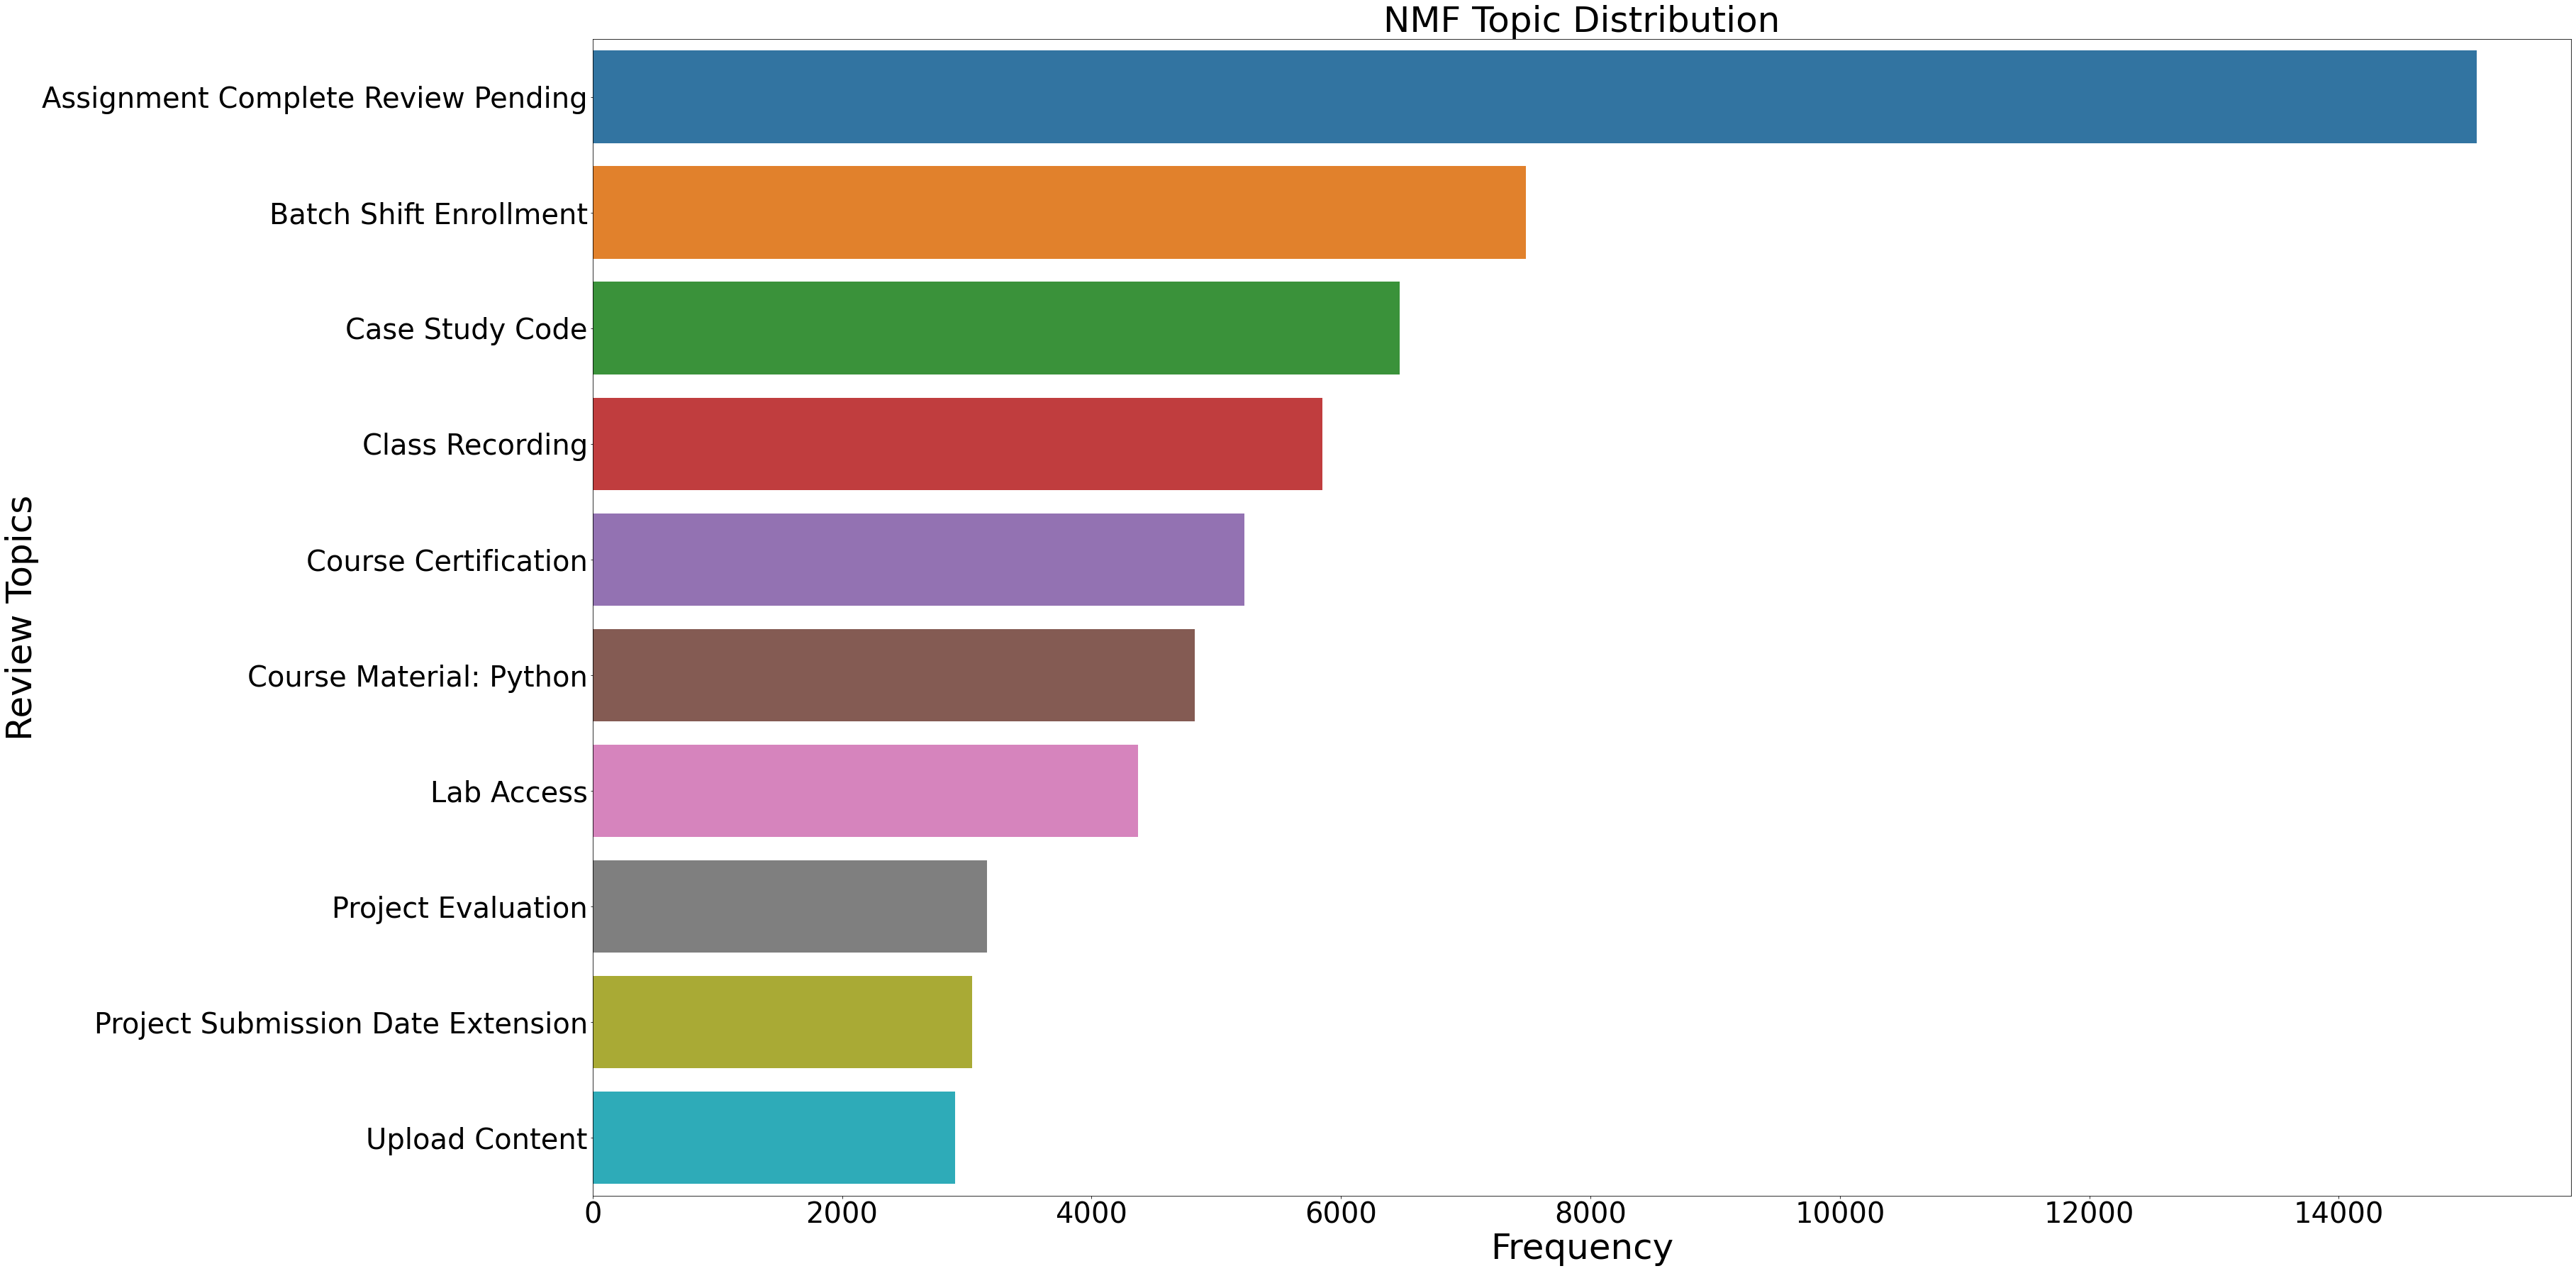

In [246]:
nmf_x = df_t['nmf_topics'].value_counts()
nmf_y = nmf_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_x, nmf_y.index)
plt.title("NMF Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

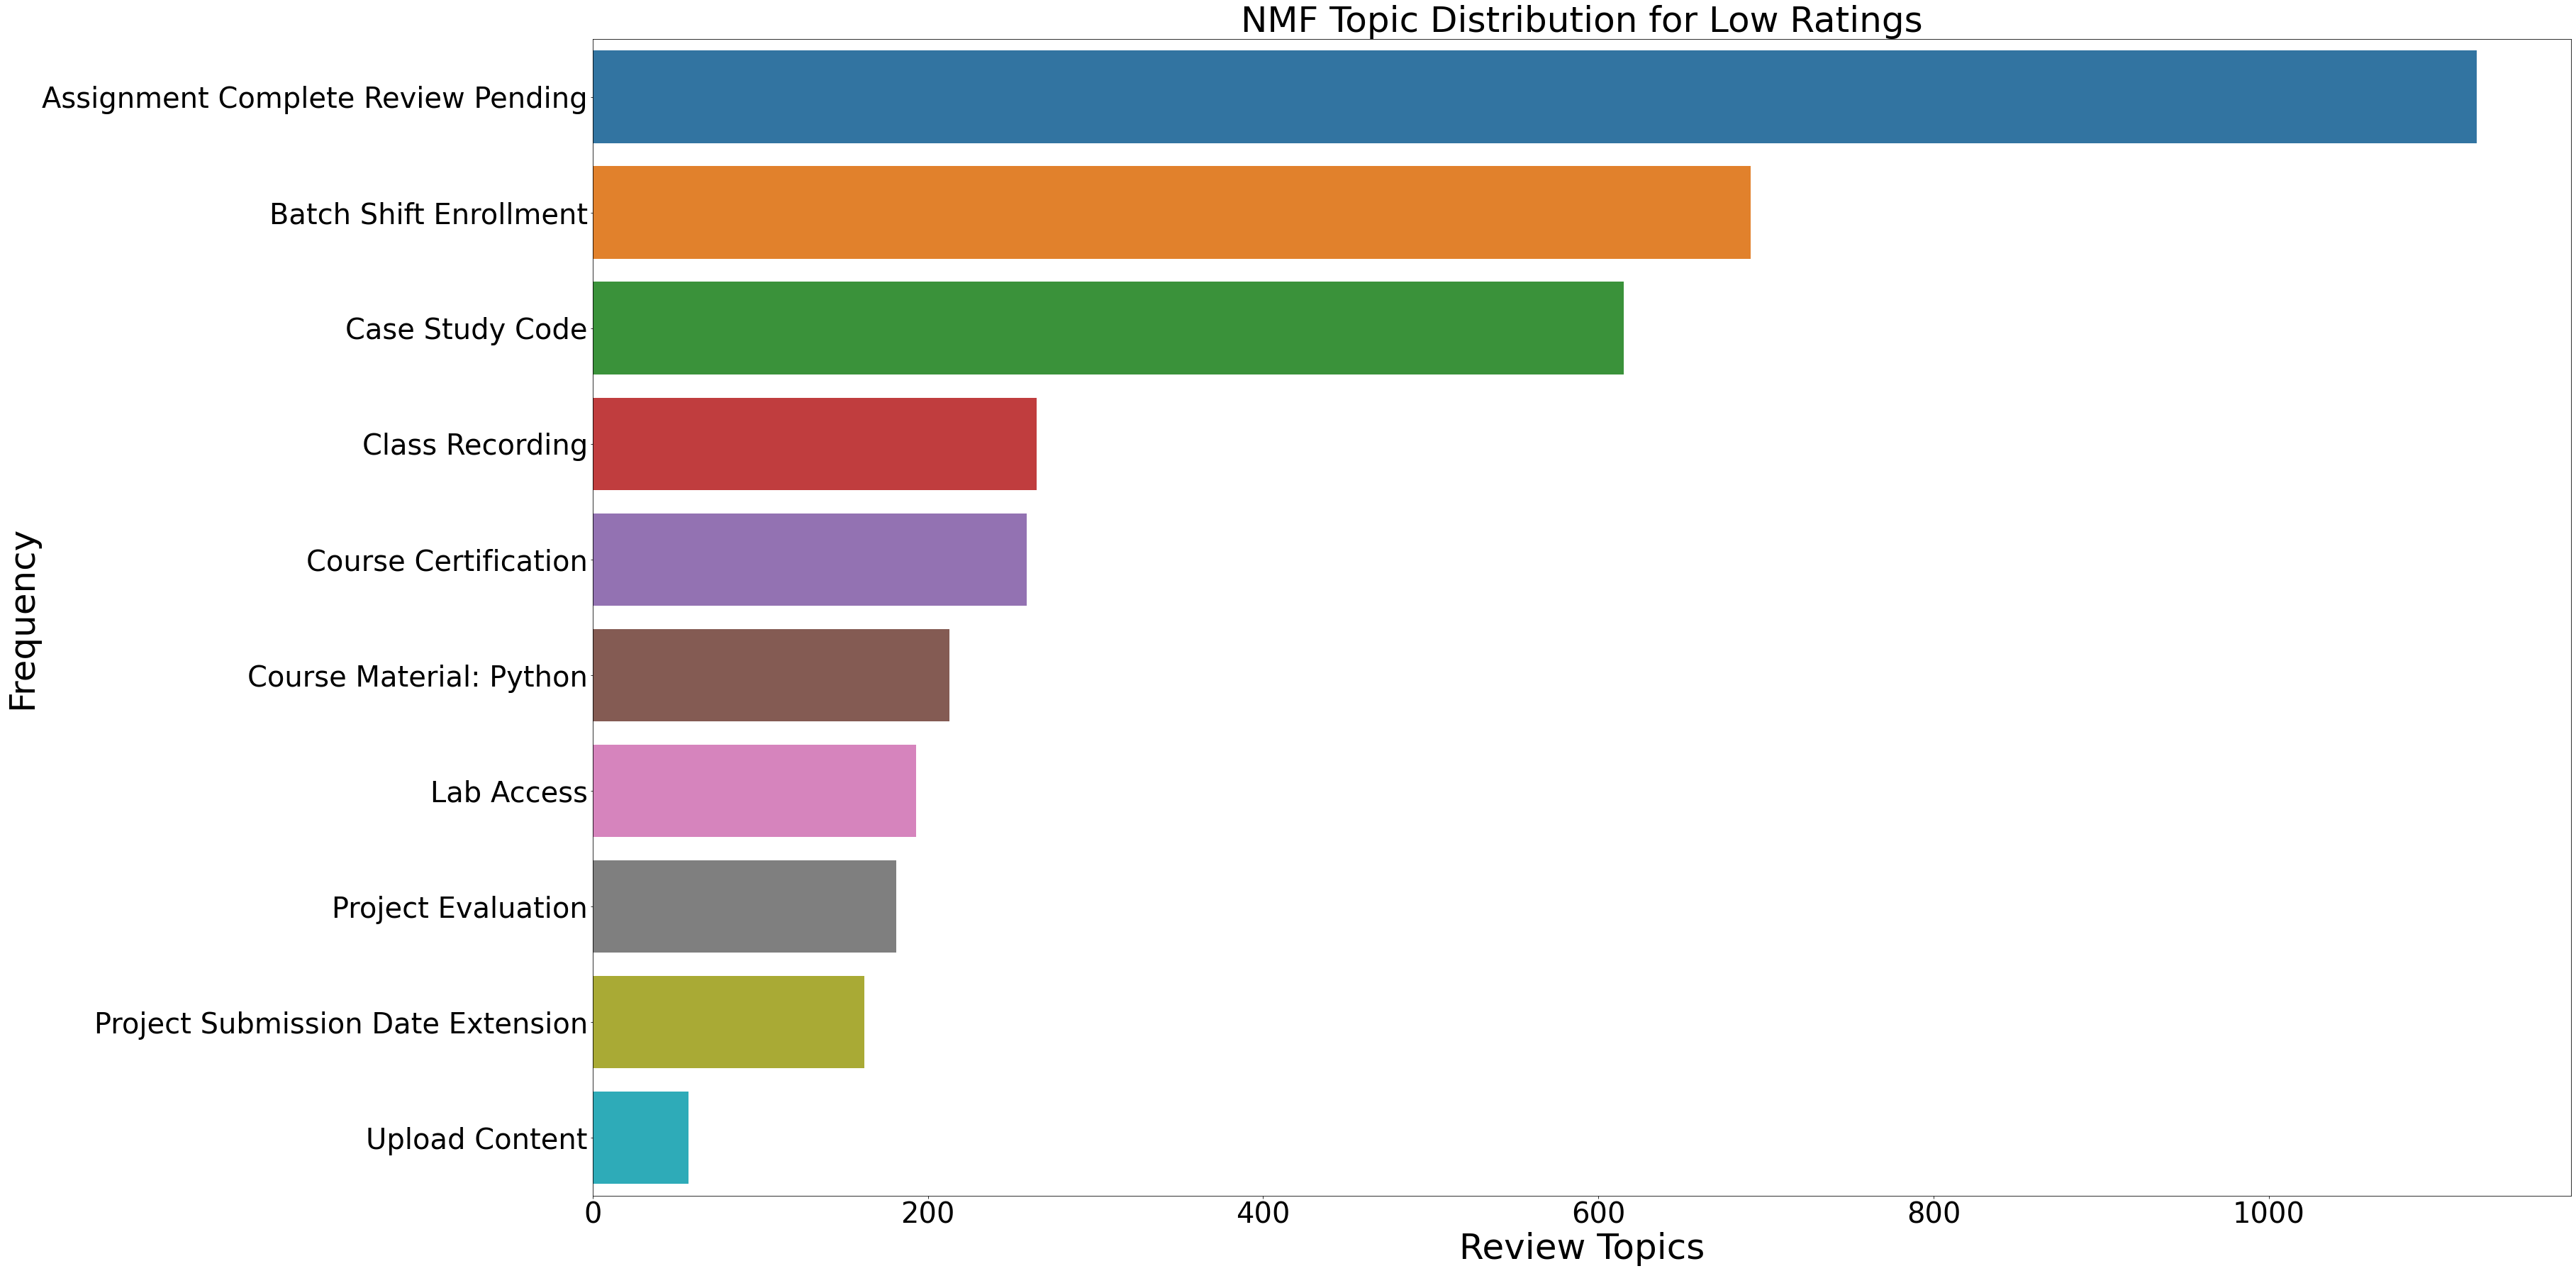

In [247]:
df_low_ratings = df_t.loc[(df_t['happiness_rating']=="Bad")]
nmf_low_x = df_low_ratings['nmf_topics'].value_counts()
nmf_low_y = nmf_low_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_low_x, nmf_low_y.index)
plt.title("NMF Topic Distribution for Low Ratings", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

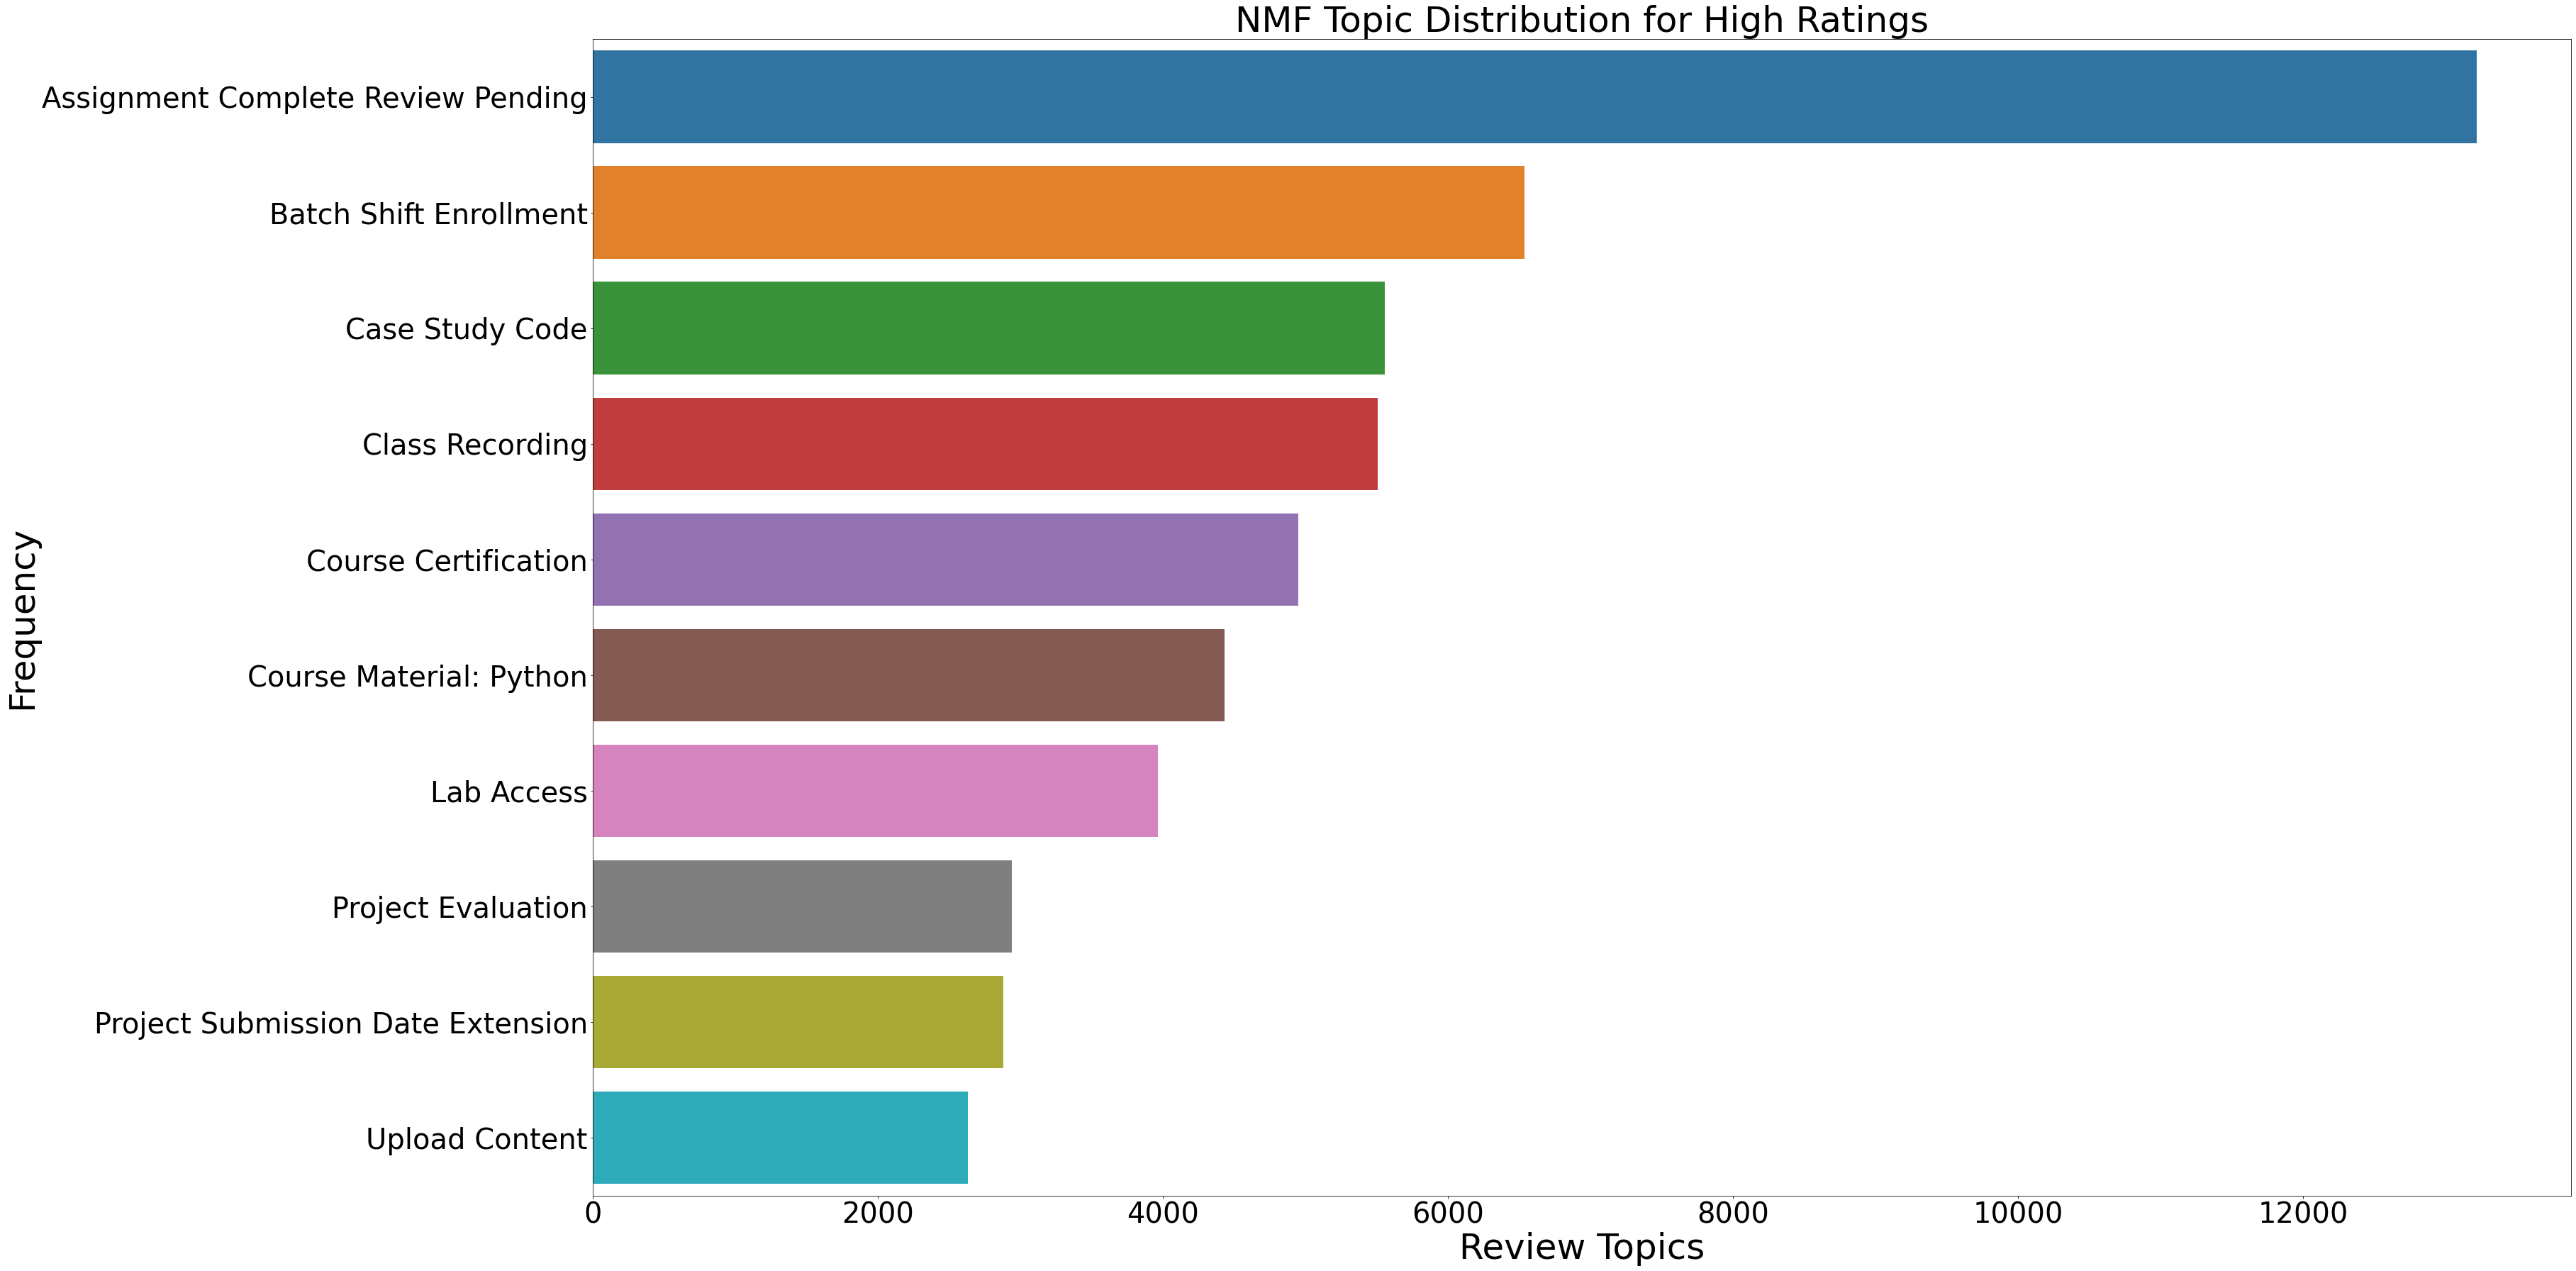

In [248]:
df_high_ratings = df_t.loc[(df_t['happiness_rating']=="Good")]
nmf_high_x = df_high_ratings['nmf_topics'].value_counts()
nmf_high_y = nmf_high_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_high_x, nmf_high_y.index)
plt.title("NMF Topic Distribution for High Ratings", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)

## Batch Processing

### First 20k data

In [221]:
df_20k = df3.iloc[:20000]
df_20k

freshdesk_id happiness_rating  \
3              2076              NaN   
6              2079              NaN   
9              2082              NaN   
11             2084              NaN   
13             2087             Good   
...             ...              ...   
20608         22816             Good   
20609         22817              NaN   
20610         22818              NaN   
20611         22819              NaN   
20612         22820              NaN   

                                                                                                lemmatized  \
3                                                  [submit, final, project, evaluation, process, complete]   
6      [opt, full, stack, web, development, course, wednesday, enrol, come, know, nothing, java, devlop...   
9                                     [unable, play, record, video, could, check, soon, possible, chandan]   
11                                         [assignment, get, verify, able, get, certificate, look, please]   
13     [face, difficulty, submit, question, execution, give, error, message, submit, fails, test, case,...   
...                                                                                                    ...   
20608                                              [necessary, install, python, already, instal, anaconda]   
20609                 [module, introduction, selenium, component, content, http, upload, library, fh, zip]   
20610                           [unable, share, download, able, see, certificate, lm, could, advice, step]   
20611                                    [module, case, study, content, http, upload, library, fwgz, docx]   
20612                                  [module, case, study, content, http, upload, library, fezcpv, docx]   

                                                                                                 lemma_str  \
3                                                         submit final project evaluation process complete   
6      opt full stack web development course wednesday enrol come know nothing java devloping side thin...   
9                                               unable play record video could check soon possible chandan   
11                                                  assignment get verify able get certificate look please   
13     face difficulty submit question execution give error message submit fails test case let know wro...   
...                                                                                                    ...   
20608                                                     necessary install python already instal anaconda   
20609                            module introduction selenium component content http upload library fh zip   
20610                                      unable share download able see certificate lm could advice step   
20611                                              module case study content http upload library fwgz docx   
20612                                            module case study content http upload library fezcpv docx   

       sentiment  
3       0.050000  
6       0.412500  
9      -0.250000  
11      0.500000  
13     -0.142857  
...          ...  
20608   0.000000  
20609   0.000000  
20610   0.000000  
20611   0.000000  
20612   0.000000  

[20000 rows x 5 columns]

In [222]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(df_20k['lemma_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

able  accept  access  accord  accordingly  account  action  activate  \
0         0       0       0       0            0        0       0         0   
1         0       0       0       0            0        0       0         0   
2         0       0       0       0            0        0       0         0   
3         1       0       0       0            0        0       0         0   
4         0       0       0       0            0        0       0         0   
...     ...     ...     ...     ...          ...      ...     ...       ...   
19995     0       0       0       0            0        0       0         0   
19996     0       0       0       0            0        0       0         0   
19997     1       0       0       0            0        0       0         0   
19998     0       0       0       0            0        0       0         0   
19999     0       0       0       0            0        0       0         0   

       actual  actually  ...  would  write  wrong  xlsx  xml  year  yes  \
0           0         0  ...      0      0      0     0    0     0    0   
1           0         0  ...      0      0      0     0    0     0    0   
2           0         0  ...      0      0      0     0    0     0    0   
3           0         0  ...      0      0      0     0    0     0    0   
4           0         0  ...      0      0      1     0    0     0    0   
...       ...       ...  ...    ...    ...    ...   ...  ...   ...  ...   
19995       0         0  ...      0      0      0     0    0     0    0   
19996       0         0  ...      0      0      0     0    0     0    0   
19997       0         0  ...      0      0      0     0    0     0    0   
19998       0         0  ...      0      0      0     0    0     0    0   
19999       0         0  ...      0      0      0     0    0     0    0   

       yesterday  yet  zip  
0              0    0    0  
1              0    0    0  
2              0    0    0  
3              0    0    0  
4              0    0    0  
...          ...  ...  ...  
19995          0    0    0  
19996          0    0    1  
19997          0    0    0  
19998          0    0    0  
19999          0    0    0  

[20000 rows x 872 columns]

In [223]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
use file data code create command import output write name
Topic 1:
solution assignment please view find record link download rar see
Topic 2:
content http upload library docx module assignment zip txt ipynb
Topic 3:
class batch know start want let session would course like
Topic 4:
project complete time certification course need could video new due
Topic 5:
course one data also get kindly provide master program ask
Topic 6:
get test help error team question try work support code
Topic 7:
case study module assignment submit review unix still mysql show
Topic 8:
file google pdf drive usp drivesdk table attach database create
Topic 9:
java question answer program look ticket org doc mark extend


In [224]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  29.262003
6       0.648955  71.707100       2        1  11.130957
3      71.019684   9.971006       3        1  10.619984
0       3.785981  33.185135       4        1   9.195596
4     -42.666500  -9.222070       5        1   8.560336
5      -3.621689 -43.526516       6        1   8.361326
7      -3.632402  -4.171708       7        1   7.218293
1     -36.584400  35.804413       8        1   5.604209
9      44.391380  50.615383       9        1   5.466756
8      40.235809 -31.591665      10        1   4.580541, topic_info=        Term          Freq         Total Category  logprob  loglift
148  content  11305.000000  11305.000000  Default  30.0000  30.0000
337     http  10972.000000  10972.000000  Default  29.0000  29.0000
817   upload  10735.000000  10735.000000  Default  28.0000  28.0000
410  library  10541.000000  10541.000000  Default  27.0000  27.0000
377     java   3039.000000   3039.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
163   create    253.655710    834.636238  Topic10  -3.6313   1.8923
575  present     67.857138     98.221142  Topic10  -4.9498   2.7135
480    mysql     86.613441    353.105601  Topic10  -4.7058   1.6780
338    https     70.912488    345.356724  Topic10  -4.9058   1.5002
486  network     57.505675    117.044666  Topic10  -5.1154   2.3727

[479 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         5  0.536107    able
0         6  0.256182    able
0         8  0.206195    able
2         2  0.361015  access
2         3  0.416972  access
...     ...       ...     ...
866       1  0.424285     xml
866       9  0.573270     xml
870       3  0.392183     yet
870       7  0.601008     yet
871       1  0.999224     zip

[556 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 4, 1, 5, 6, 8, 2, 10, 9])

In [226]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df_20k['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

able  accept  access  accord  accordingly  account  action  \
0      0.000000     0.0     0.0     0.0          0.0      0.0     0.0   
1      0.000000     0.0     0.0     0.0          0.0      0.0     0.0   
2      0.000000     0.0     0.0     0.0          0.0      0.0     0.0   
3      0.323326     0.0     0.0     0.0          0.0      0.0     0.0   
4      0.000000     0.0     0.0     0.0          0.0      0.0     0.0   
...         ...     ...     ...     ...          ...      ...     ...   
19995  0.000000     0.0     0.0     0.0          0.0      0.0     0.0   
19996  0.000000     0.0     0.0     0.0          0.0      0.0     0.0   
19997  0.289992     0.0     0.0     0.0          0.0      0.0     0.0   
19998  0.000000     0.0     0.0     0.0          0.0      0.0     0.0   
19999  0.000000     0.0     0.0     0.0          0.0      0.0     0.0   

       activate  actual  actually  ...  would  write     wrong  xlsx  xml  \
0           0.0     0.0       0.0  ...    0.0    0.0  0.000000   0.0  0.0   
1           0.0     0.0       0.0  ...    0.0    0.0  0.000000   0.0  0.0   
2           0.0     0.0       0.0  ...    0.0    0.0  0.000000   0.0  0.0   
3           0.0     0.0       0.0  ...    0.0    0.0  0.000000   0.0  0.0   
4           0.0     0.0       0.0  ...    0.0    0.0  0.096959   0.0  0.0   
...         ...     ...       ...  ...    ...    ...       ...   ...  ...   
19995       0.0     0.0       0.0  ...    0.0    0.0  0.000000   0.0  0.0   
19996       0.0     0.0       0.0  ...    0.0    0.0  0.000000   0.0  0.0   
19997       0.0     0.0       0.0  ...    0.0    0.0  0.000000   0.0  0.0   
19998       0.0     0.0       0.0  ...    0.0    0.0  0.000000   0.0  0.0   
19999       0.0     0.0       0.0  ...    0.0    0.0  0.000000   0.0  0.0   

       year  yes  yesterday  yet       zip  
0       0.0  0.0        0.0  0.0  0.000000  
1       0.0  0.0        0.0  0.0  0.000000  
2       0.0  0.0        0.0  0.0  0.000000  
3       0.0  0.0        0.0  0.0  0.000000  
4       0.0  0.0        0.0  0.0  0.000000  
...     ...  ...        ...  ...       ...  
19995   0.0  0.0        0.0  0.0  0.000000  
19996   0.0  0.0        0.0  0.0  0.278526  
19997   0.0  0.0        0.0  0.0  0.000000  
19998   0.0  0.0        0.0  0.0  0.000000  
19999   0.0  0.0        0.0  0.0  0.000000  

[20000 rows x 872 columns]

In [227]:
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
docx library upload http content module mod sql solution code
Topic 1:
case study module py solution http content library upload ii
Topic 2:
pdf do library upload http content py attach br submission
Topic 3:
assignment submit module unix review complete http content mysql still
Topic 4:
drive google file usp view drivesdk content http module solution
Topic 5:
txt library upload http content module unix solution br mod
Topic 6:
java library upload http content module casestudy do solution code
Topic 7:
zip upload library http content module file complete br attach
Topic 8:
batch course class get complete project please request certification help
Topic 9:
ipynb library upload http content please review py project notebook


In [228]:
nmf_topic_values = nmf.transform(tfidf)
df_20k['nmf_topics'] = nmf_topic_values.argmax(axis=1)
lda_topic_values = lda_model.transform(tf)
df_20k['lda_topics'] = lda_topic_values.argmax(axis=1)
lda_remap = {0: 'Coding Usage', 1: 'Assignment Solution', 
             2: 'Course Materials', 3: 'Class Batch Session', 4: 'Project Completion and Course Certification', 
             5: 'Course Content', 6: 'Test Help', 7: 'Assignment Submission', 8: 'Course Content: G-Drive issue', 9: 'Java Question Answer'}
df_20k['lda_topics'] = df_20k['lda_topics'].map(lda_remap)
nmf_remap = {0: 'Content Related', 1: 'Case Study Solution', 2: 'Project Submission', 3: 'Assignment Submission Related', 
             4: 'Course Content: G-Drive issue', 5: 'Module Solution', 6: 'Case Study Code Solution', 7: 'Course Content', 
             8: 'Certification Related', 9: 'Project Review Related'}
df_20k['nmf_topics'] = df_20k['nmf_topics'].map(nmf_remap)

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

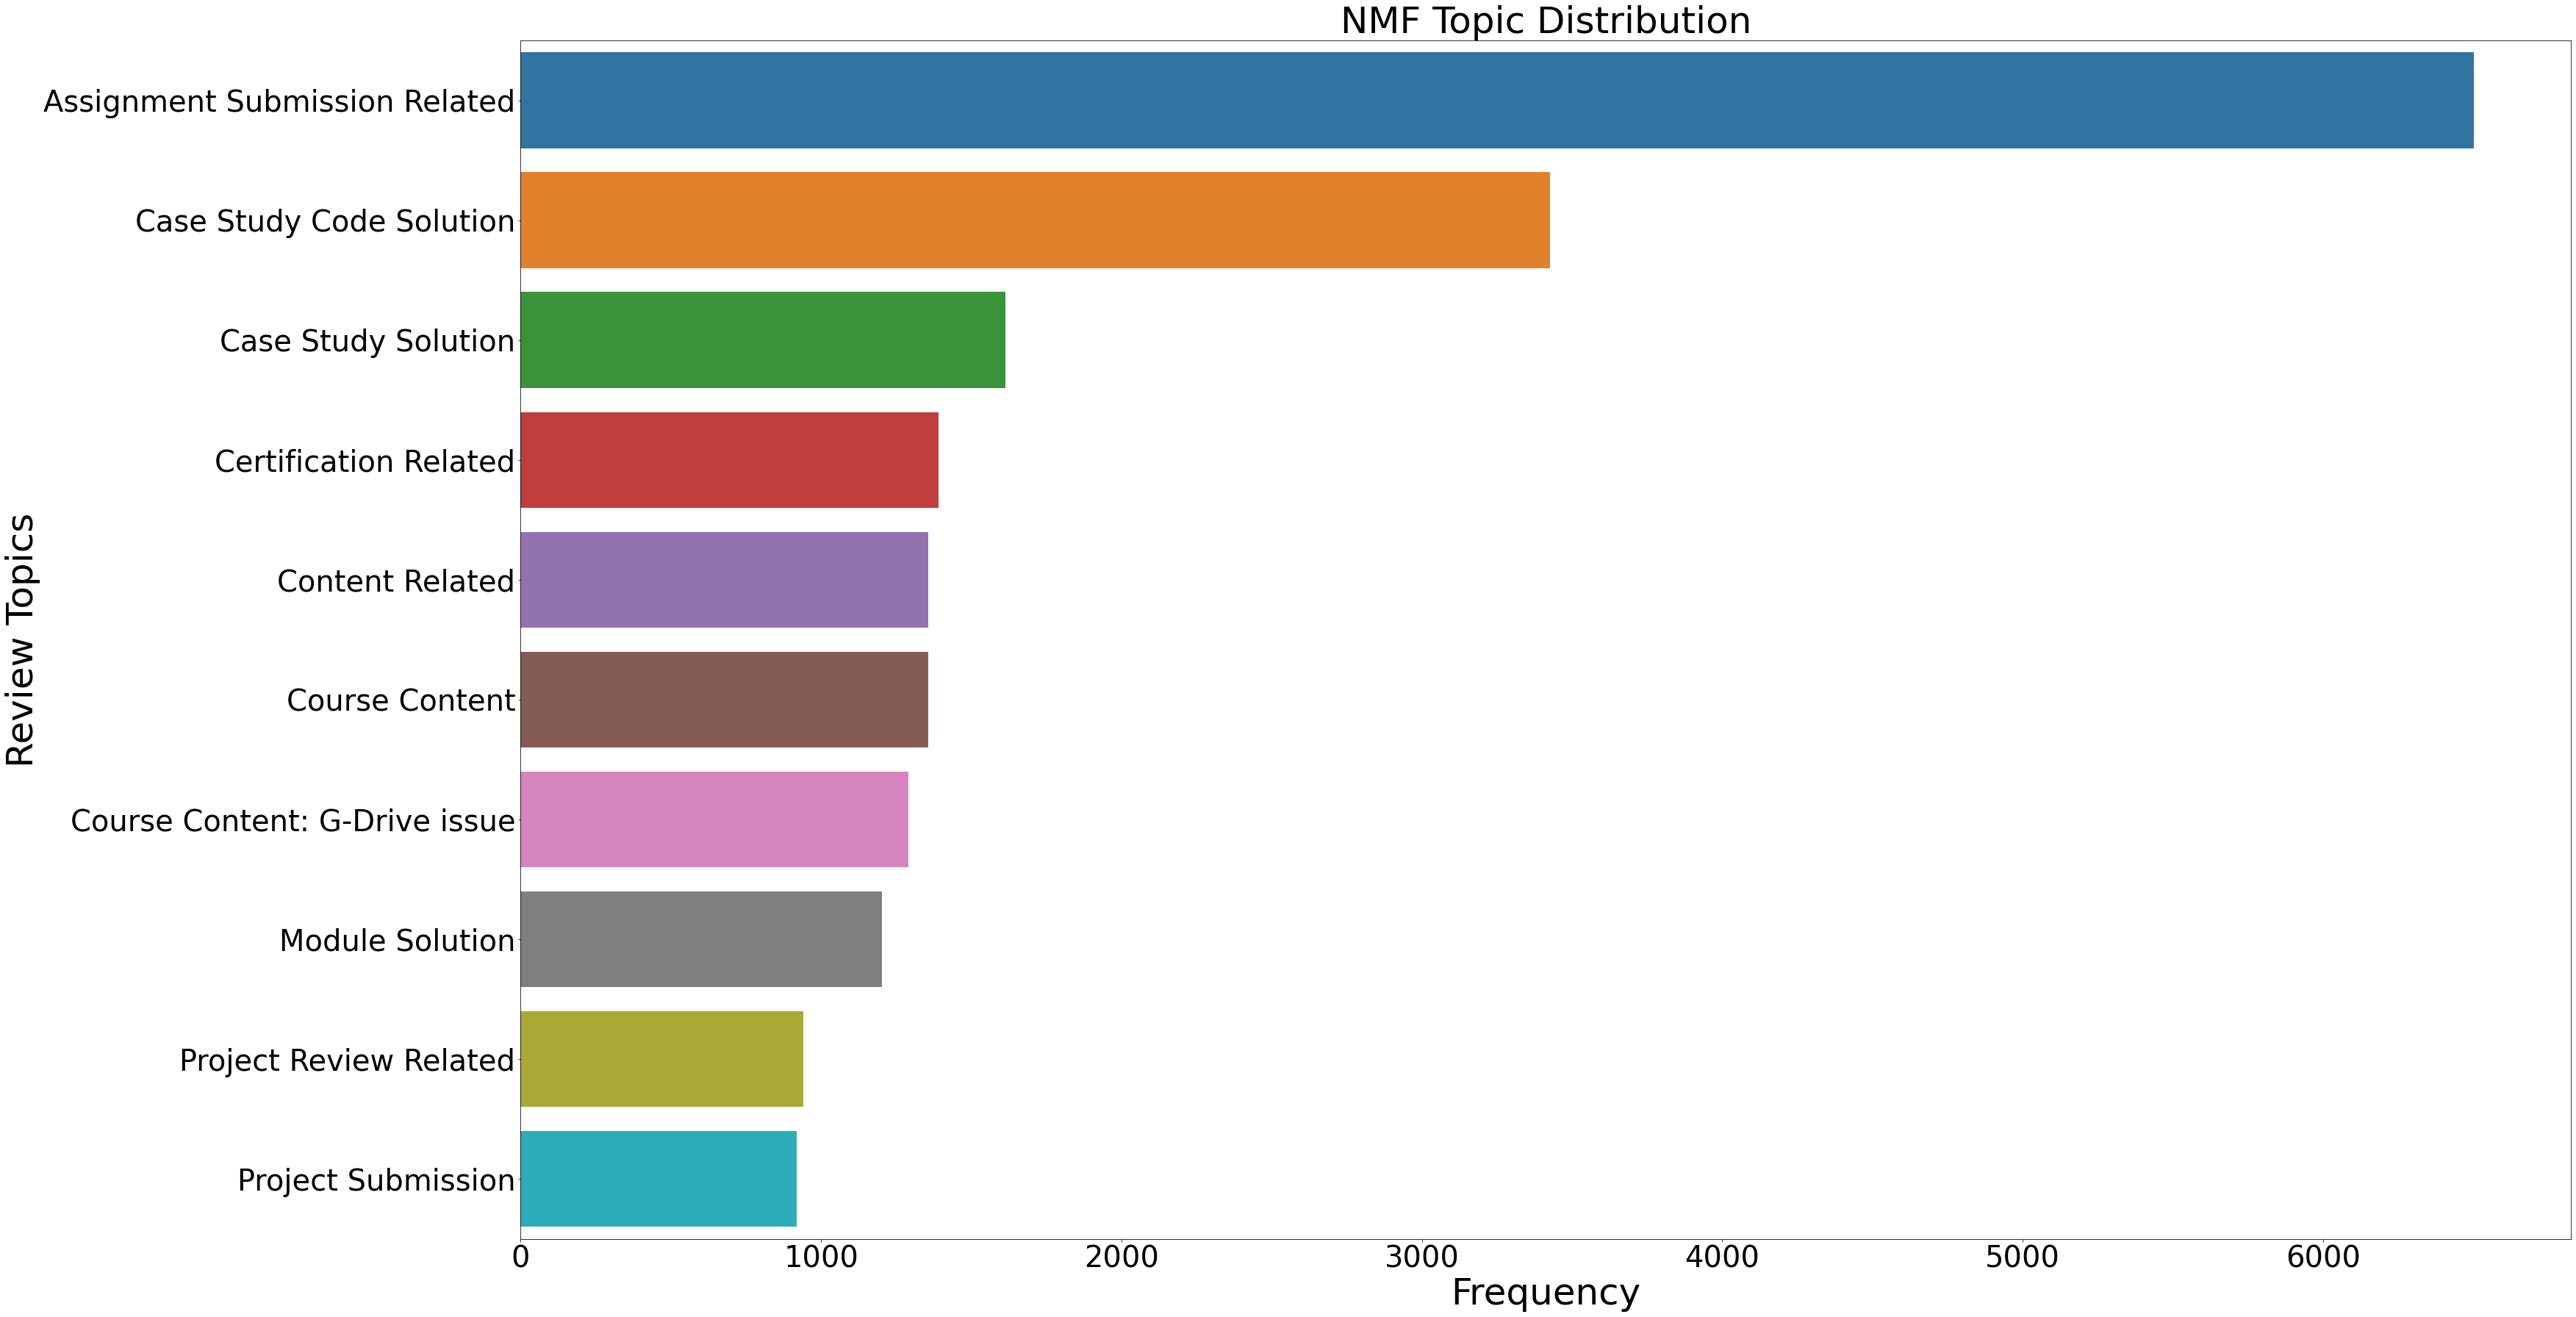

In [229]:
nmf_x = df_20k['nmf_topics'].value_counts()
nmf_y = nmf_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_x, nmf_y.index)
plt.title("NMF Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

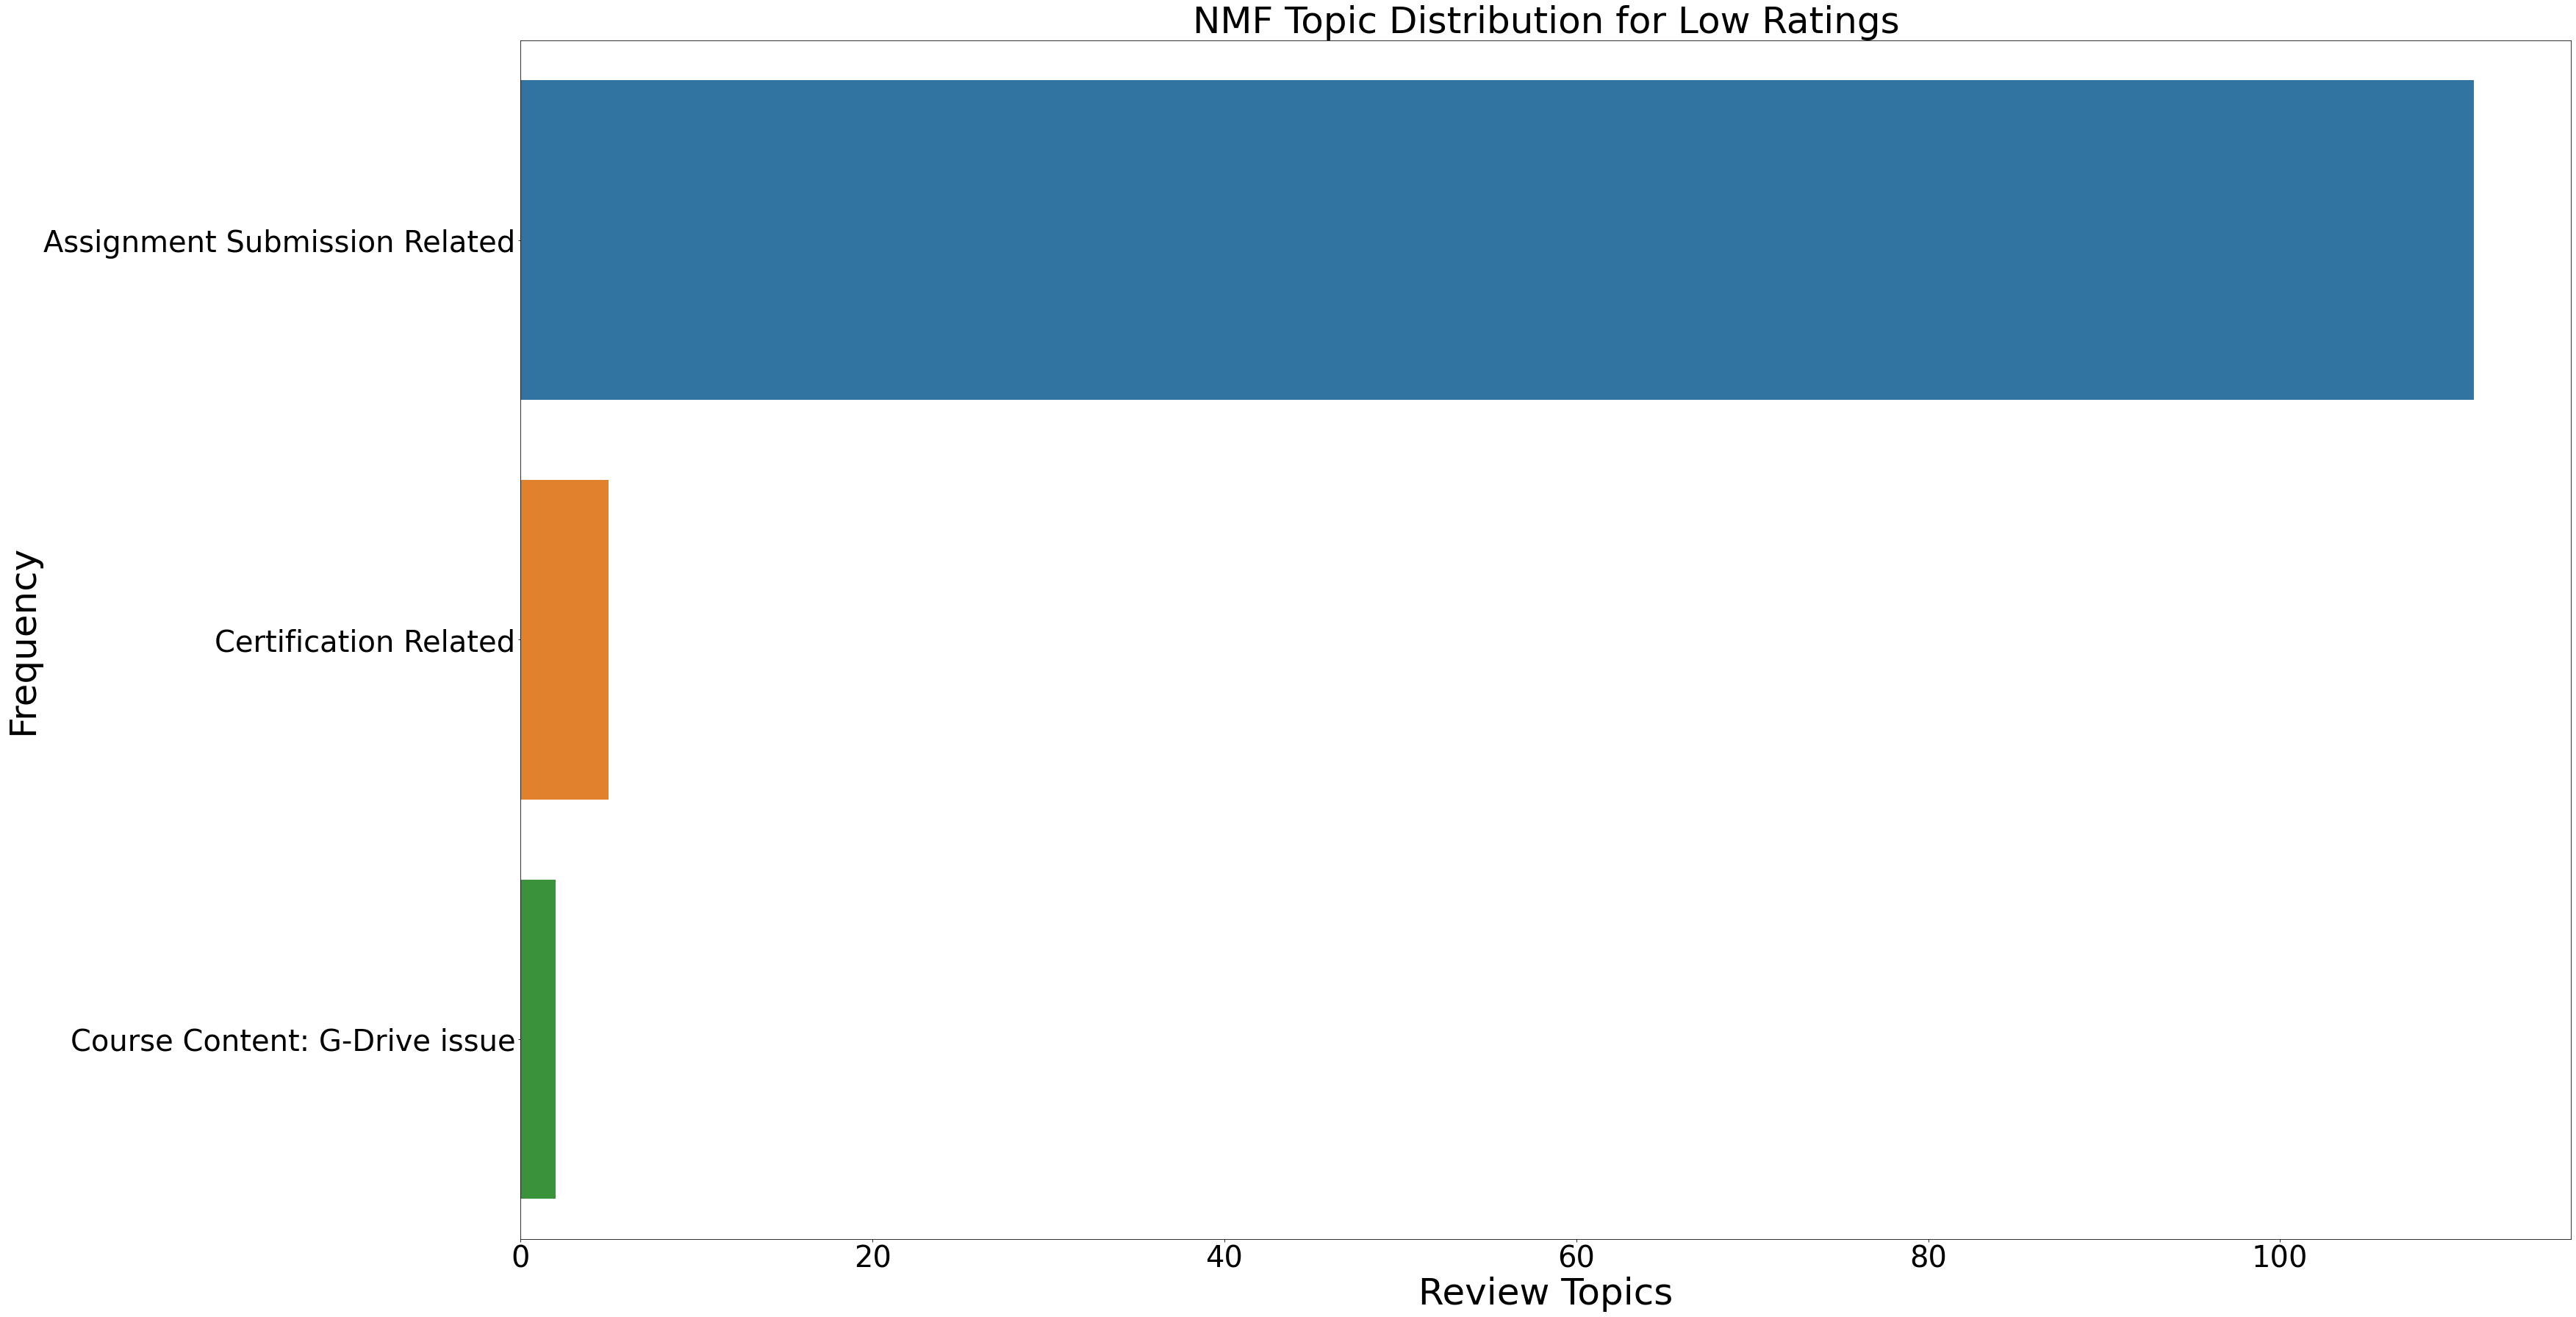

In [231]:
df_low_ratings = df_20k.loc[(df_20k['happiness_rating']=="Bad")]
nmf_low_x = df_low_ratings['nmf_topics'].value_counts()
nmf_low_y = nmf_low_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_low_x, nmf_low_y.index)
plt.title("NMF Topic Distribution for Low Ratings", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)

(array([  0., 100., 200., 300., 400., 500., 600., 700., 800., 900.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

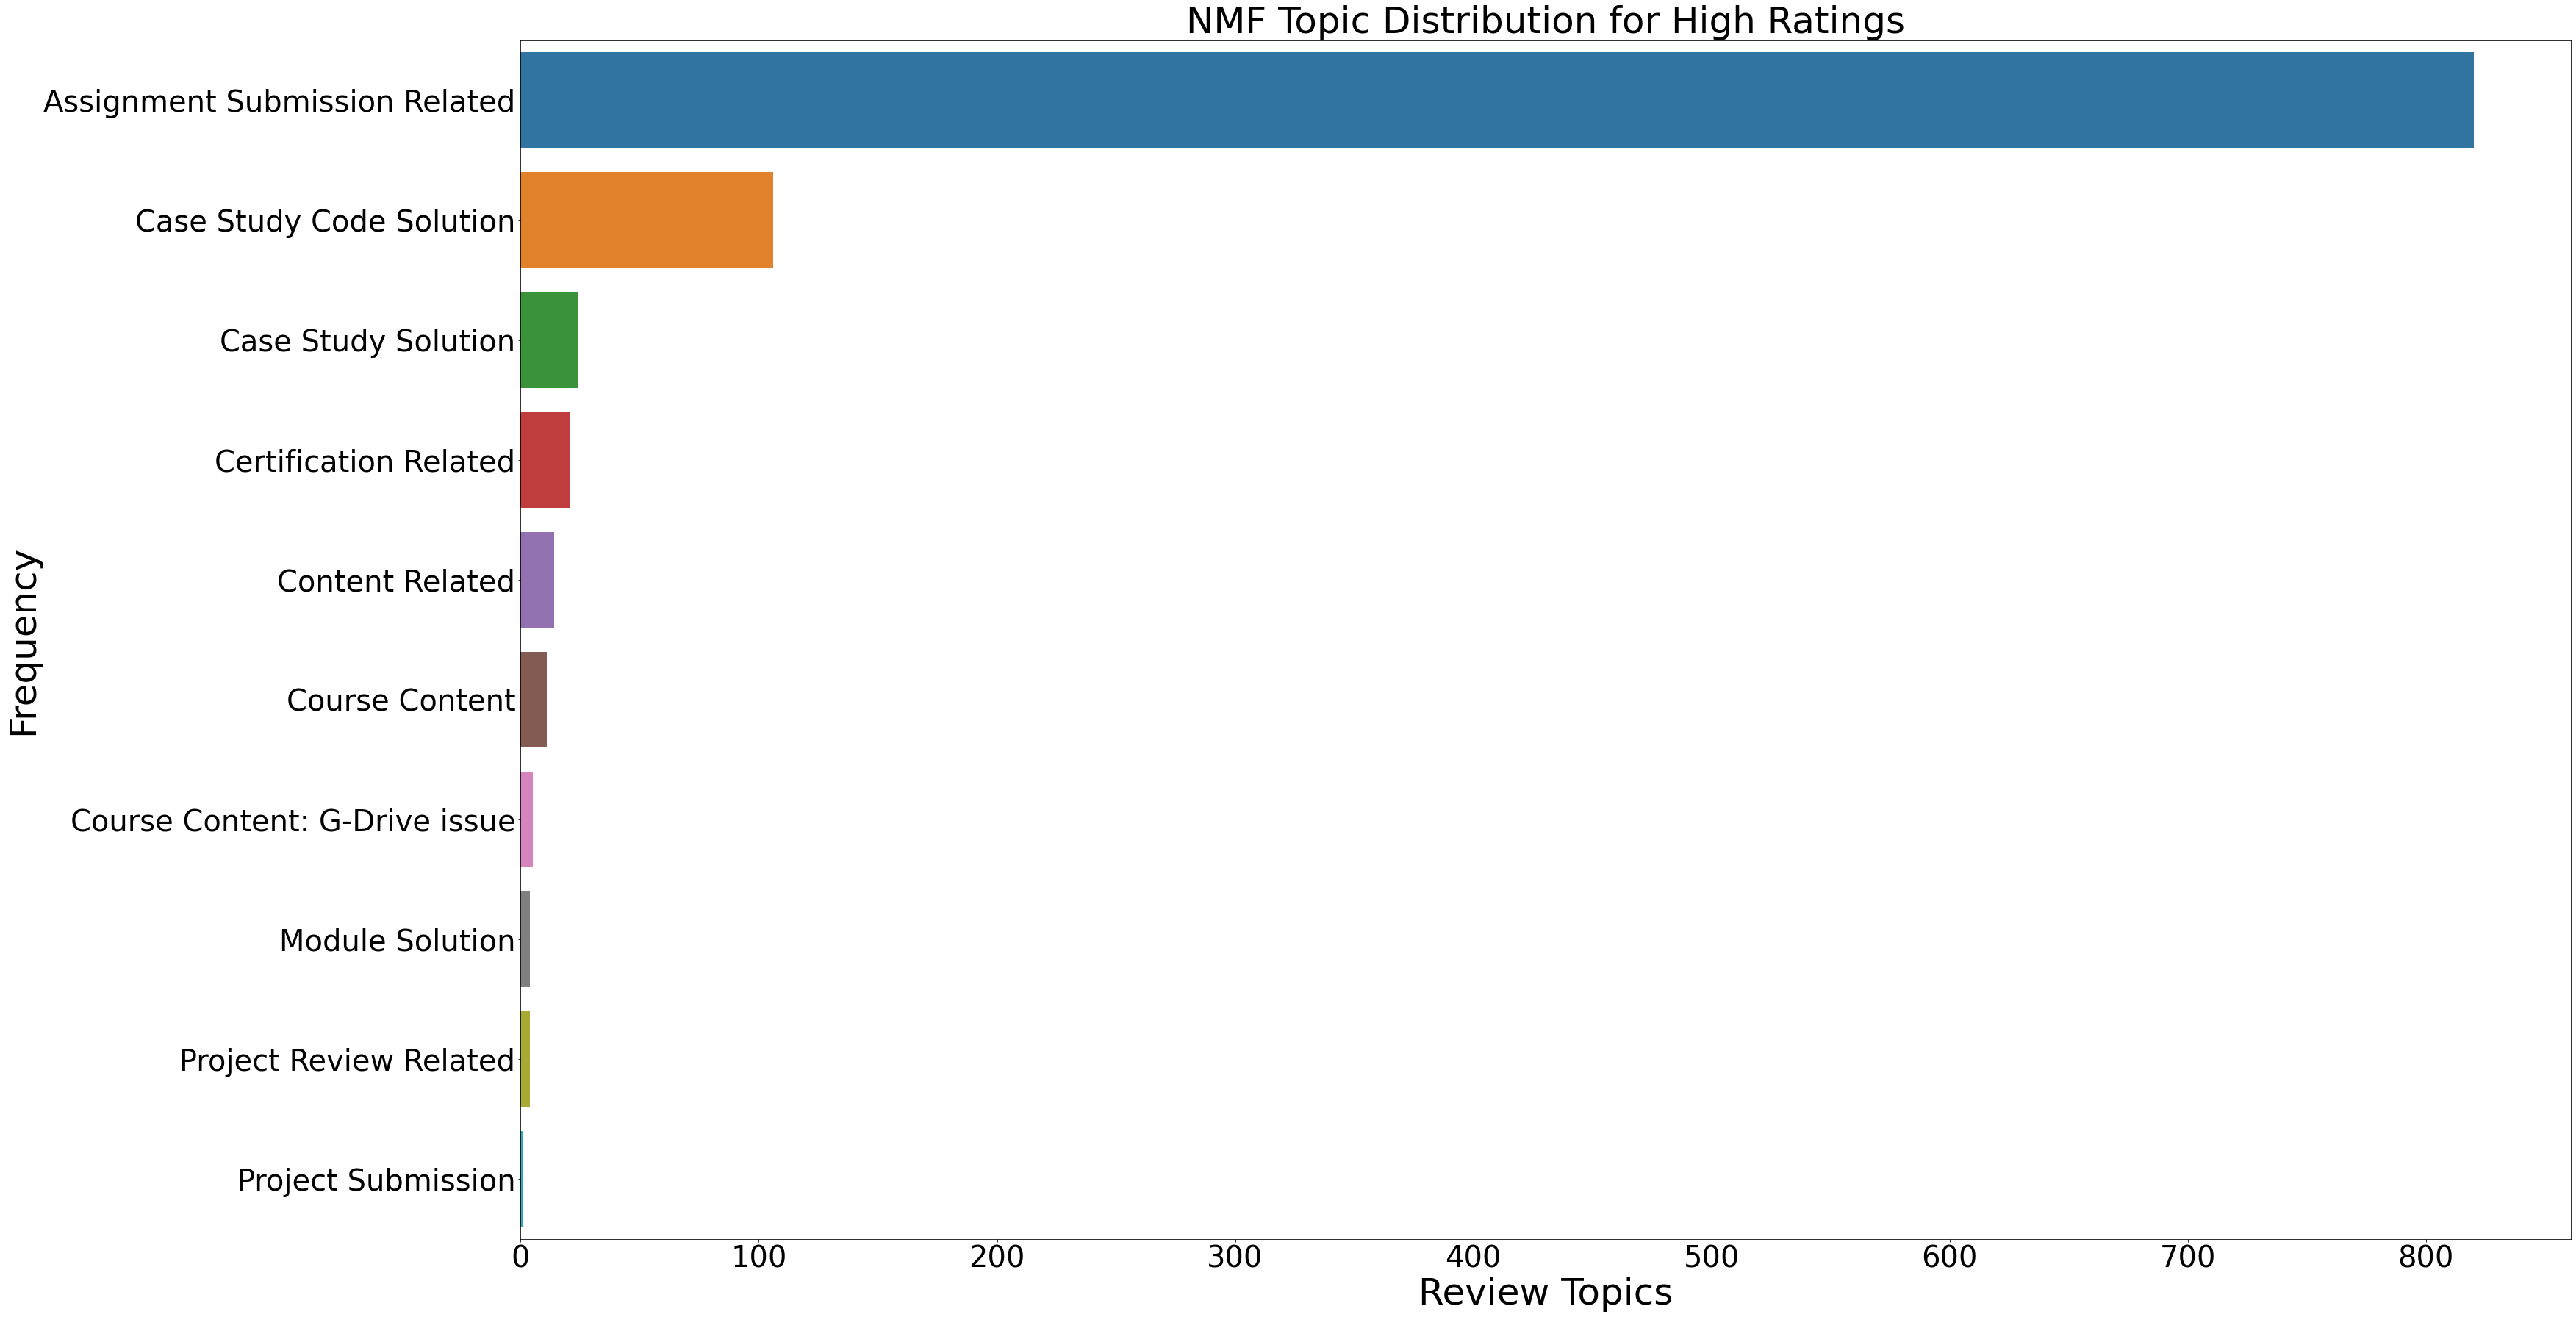

In [232]:
df_high_ratings = df_20k.loc[(df_20k['happiness_rating']=="Good")]
nmf_high_x = df_high_ratings['nmf_topics'].value_counts()
nmf_high_y = nmf_high_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_high_x, nmf_high_y.index)
plt.title("NMF Topic Distribution for High Ratings", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)

### Next 20k data

In [233]:
df_40k = df3.iloc[20001:40000]
df_40k

freshdesk_id happiness_rating  \
20614         22822              NaN   
20615         22823              NaN   
20616         22824              NaN   
20617         22825              NaN   
20618         22826              NaN   
...             ...              ...   
41362         43656              NaN   
41363         43657              NaN   
41364         43658              NaN   
41365         43659              NaN   
41366         43660              NaN   

                                                                                                lemmatized  \
20614                                 [wait, selenium, module, content, http, upload, library, fklon, zip]   
20615                                                                    [ill, get, certification, course]   
20616                                                [module, content, http, upload, library, fxiqs, docx]   
20617                                                [module, content, http, upload, library, fbyro, docx]   
20618                                               [module, content, http, upload, library, fqvhpq, docx]   
...                                                                                                    ...   
41362  [last, class, module, trainer, tell, error, cucumber, runner, file, cnnot, execute, text, kindly...   
41363  [insert, value, db, hibernate, get, error, call, org, hibernate, service, spi, serviceexception,...   
41364               [due, date, assignment, show, active, since, yesterday, pls, make, live, also, submit]   
41365                                                                       [kindly, help, resolve, error]   
41366  [try, submit, assignment, upload, file, one, error, come, error, occur, reload, page, try, also,...   

                                                                                                 lemma_str  \
20614                                           wait selenium module content http upload library fklon zip   
20615                                                                         ill get certification course   
20616                                                        module content http upload library fxiqs docx   
20617                                                        module content http upload library fbyro docx   
20618                                                       module content http upload library fqvhpq docx   
...                                                                                                    ...   
41362  last class module trainer tell error cucumber runner file cnnot execute text kindly provide info...   
41363  insert value db hibernate get error call org hibernate service spi serviceexception unable creat...   
41364                            due date assignment show active since yesterday pls make live also submit   
41365                                                                            kindly help resolve error   
41366  try submit assignment upload file one error come error occur reload page try also try refresh pa...   

       sentiment  
20614   0.000000  
20615  -0.500000  
20616   0.000000  
20617   0.000000  
20618   0.000000  
...          ...  
41362   0.300000  
41363   0.138889  
41364  -0.040657  
41365   0.600000  
41366   0.250000  

[19999 rows x 5 columns]

In [250]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(df_40k['lemma_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

able  accept  access  accord  accordingly  account  accuracy  action  \
0         0       0       0       0            0        0         0       0   
1         0       0       0       0            0        0         0       0   
2         0       0       0       0            0        0         0       0   
3         0       0       0       0            0        0         0       0   
4         0       0       0       0            0        0         0       0   
...     ...     ...     ...     ...          ...      ...       ...     ...   
19994     0       0       0       0            0        0         0       0   
19995     1       0       0       0            0        0         0       0   
19996     0       0       0       0            0        0         0       0   
19997     0       0       0       0            0        0         0       0   
19998     0       0       0       0            0        0         0       0   

       activate  active  ...  write  wrong  xlsx  xml  year  yes  yesterday  \
0             0       0  ...      0      0     0    0     0    0          0   
1             0       0  ...      0      0     0    0     0    0          0   
2             0       0  ...      0      0     0    0     0    0          0   
3             0       0  ...      0      0     0    0     0    0          0   
4             0       0  ...      0      0     0    0     0    0          0   
...         ...     ...  ...    ...    ...   ...  ...   ...  ...        ...   
19994         0       0  ...      0      0     0    0     0    0          0   
19995         0       0  ...      0      0     0    2     0    0          0   
19996         0       1  ...      0      0     0    0     0    0          1   
19997         0       0  ...      0      0     0    0     0    0          0   
19998         0       0  ...      0      0     0    0     0    0          0   

       yet  youtube  zip  
0        0        0    1  
1        0        0    0  
2        0        0    0  
3        0        0    0  
4        0        0    0  
...    ...      ...  ...  
19994    0        0    0  
19995    0        0    0  
19996    0        0    0  
19997    0        0    0  
19998    0        0    0  

[19999 rows x 995 columns]

In [251]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
content http upload library assignment zip docx module txt please
Topic 1:
attach unable able machine import vm create table access get
Topic 2:
project submit review do submission solution final twb html verify
Topic 3:
file google drive share font view step color rgb data
Topic 4:
use java file error run create org user command apache
Topic 5:
work find know class video add please let record also
Topic 6:
ipynb complete show test certificate access lab answer email evaluate
Topic 7:
content http case upload library study module py twbx java
Topic 8:
course batch class certification start time would like training request
Topic 9:
assignment get help code question issue need give call error


In [252]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
8      32.420952   8.115230       1        1  20.577620
0       0.648955  71.707100       2        1  17.801980
9      71.019684   9.971006       3        1  13.774062
7       3.785981  33.185135       4        1   9.293725
4     -42.666500  -9.222070       5        1   9.273750
5      -3.621689 -43.526516       6        1   8.988565
3      -3.632402  -4.171708       7        1   5.917181
6     -36.584400  35.804413       8        1   5.517899
1      44.391380  50.615383       9        1   4.873453
2      40.235809 -31.591665      10        1   3.981766, topic_info=        Term          Freq         Total Category  logprob  loglift
176  content  10192.000000  10192.000000  Default  30.0000  30.0000
390     http   9940.000000   9940.000000  Default  29.0000  29.0000
936   upload   9847.000000   9847.000000  Default  28.0000  28.0000
473  library   9504.000000   9504.000000  Default  27.0000  27.0000
669  project   2618.000000   2618.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
491     long     36.794860     86.423046  Topic10  -5.5153   2.3695
840    still     86.955323    426.857707  Topic10  -4.6553   1.6324
105       br     41.267976    138.434670  Topic10  -5.4006   2.0131
450   kindly     59.406321    807.105123  Topic10  -5.0363   0.6144
458     last     46.260872    431.012141  Topic10  -5.2864   0.9916

[450 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         1  0.507284         able
0         9  0.491243         able
2         8  0.684821       access
2         9  0.314876       access
4         8  0.980457  accordingly
...     ...       ...          ...
985       3  0.997300        write
987       2  0.756381         xlsx
987       5  0.226914         xlsx
992       1  0.994466          yet
994       2  0.999576          zip

[526 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 10, 8, 5, 6, 4, 7, 2, 3])

In [253]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df_40k['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

able  accept  access  accord  accordingly  account  accuracy  \
0      0.000000     0.0     0.0     0.0          0.0      0.0       0.0   
1      0.000000     0.0     0.0     0.0          0.0      0.0       0.0   
2      0.000000     0.0     0.0     0.0          0.0      0.0       0.0   
3      0.000000     0.0     0.0     0.0          0.0      0.0       0.0   
4      0.000000     0.0     0.0     0.0          0.0      0.0       0.0   
...         ...     ...     ...     ...          ...      ...       ...   
19994  0.000000     0.0     0.0     0.0          0.0      0.0       0.0   
19995  0.092072     0.0     0.0     0.0          0.0      0.0       0.0   
19996  0.000000     0.0     0.0     0.0          0.0      0.0       0.0   
19997  0.000000     0.0     0.0     0.0          0.0      0.0       0.0   
19998  0.000000     0.0     0.0     0.0          0.0      0.0       0.0   

       action  activate    active  ...  write  wrong  xlsx       xml  year  \
0         0.0       0.0  0.000000  ...    0.0    0.0   0.0  0.000000   0.0   
1         0.0       0.0  0.000000  ...    0.0    0.0   0.0  0.000000   0.0   
2         0.0       0.0  0.000000  ...    0.0    0.0   0.0  0.000000   0.0   
3         0.0       0.0  0.000000  ...    0.0    0.0   0.0  0.000000   0.0   
4         0.0       0.0  0.000000  ...    0.0    0.0   0.0  0.000000   0.0   
...       ...       ...       ...  ...    ...    ...   ...       ...   ...   
19994     0.0       0.0  0.000000  ...    0.0    0.0   0.0  0.000000   0.0   
19995     0.0       0.0  0.000000  ...    0.0    0.0   0.0  0.294219   0.0   
19996     0.0       0.0  0.399729  ...    0.0    0.0   0.0  0.000000   0.0   
19997     0.0       0.0  0.000000  ...    0.0    0.0   0.0  0.000000   0.0   
19998     0.0       0.0  0.000000  ...    0.0    0.0   0.0  0.000000   0.0   

       yes  yesterday  yet  youtube       zip  
0      0.0   0.000000  0.0      0.0  0.329128  
1      0.0   0.000000  0.0      0.0  0.000000  
2      0.0   0.000000  0.0      0.0  0.000000  
3      0.0   0.000000  0.0      0.0  0.000000  
4      0.0   0.000000  0.0      0.0  0.000000  
...    ...        ...  ...      ...       ...  
19994  0.0   0.000000  0.0      0.0  0.000000  
19995  0.0   0.000000  0.0      0.0  0.000000  
19996  0.0   0.354195  0.0      0.0  0.000000  
19997  0.0   0.000000  0.0      0.0  0.000000  
19998  0.0   0.000000  0.0      0.0  0.000000  

[19999 rows x 995 columns]

In [254]:
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
zip library upload http content project java file complete please
Topic 1:
case study py solution ii content upload library http twb
Topic 2:
docx library upload http content project please complete solution review
Topic 3:
ipynb library upload http content please review casestudy mod submit
Topic 4:
batch course project class certification complete get request help submit
Topic 5:
assignment submit pdf http content upload library complete html attach
Topic 6:
txt library upload http content do java py text pdf
Topic 7:
module rar content library http upload java casestudy twb answer
Topic 8:
file drive google usp view share drivesdk content http id
Topic 9:
twbx upload library http content pdf java review solution twb


In [255]:
nmf_topic_values = nmf.transform(tfidf)
df_40k['nmf_topics'] = nmf_topic_values.argmax(axis=1)
lda_topic_values = lda_model.transform(tf)
df_40k['lda_topics'] = lda_topic_values.argmax(axis=1)
lda_remap = {0: 'Assignment Content Upload', 1: 'Coding Usage', 
             2: 'Project Submission', 3: 'Course Content: G-Drive issue', 4: 'Coding Usage', 
             5: 'Class Recording', 6: 'Lab Access Help', 7: 'Course Content', 8: 'Course Certification Related', 9: 'Assignment Solution'}
df_40k['lda_topics'] = df_40k['lda_topics'].map(lda_remap)
nmf_remap = {0: 'Project Submission', 1: 'Case Study Solution', 2: 'Project Review', 3: 'Case Study', 
             4: 'Certification Project', 5: 'Assignment Submission', 6: 'Uploaded Content', 7: 'Case Study Solution', 
             8: 'Course Content: G-Drive issue', 9: 'Java Question Answer'}
df_40k['nmf_topics'] = df_40k['nmf_topics'].map(nmf_remap)

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.,
        9000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

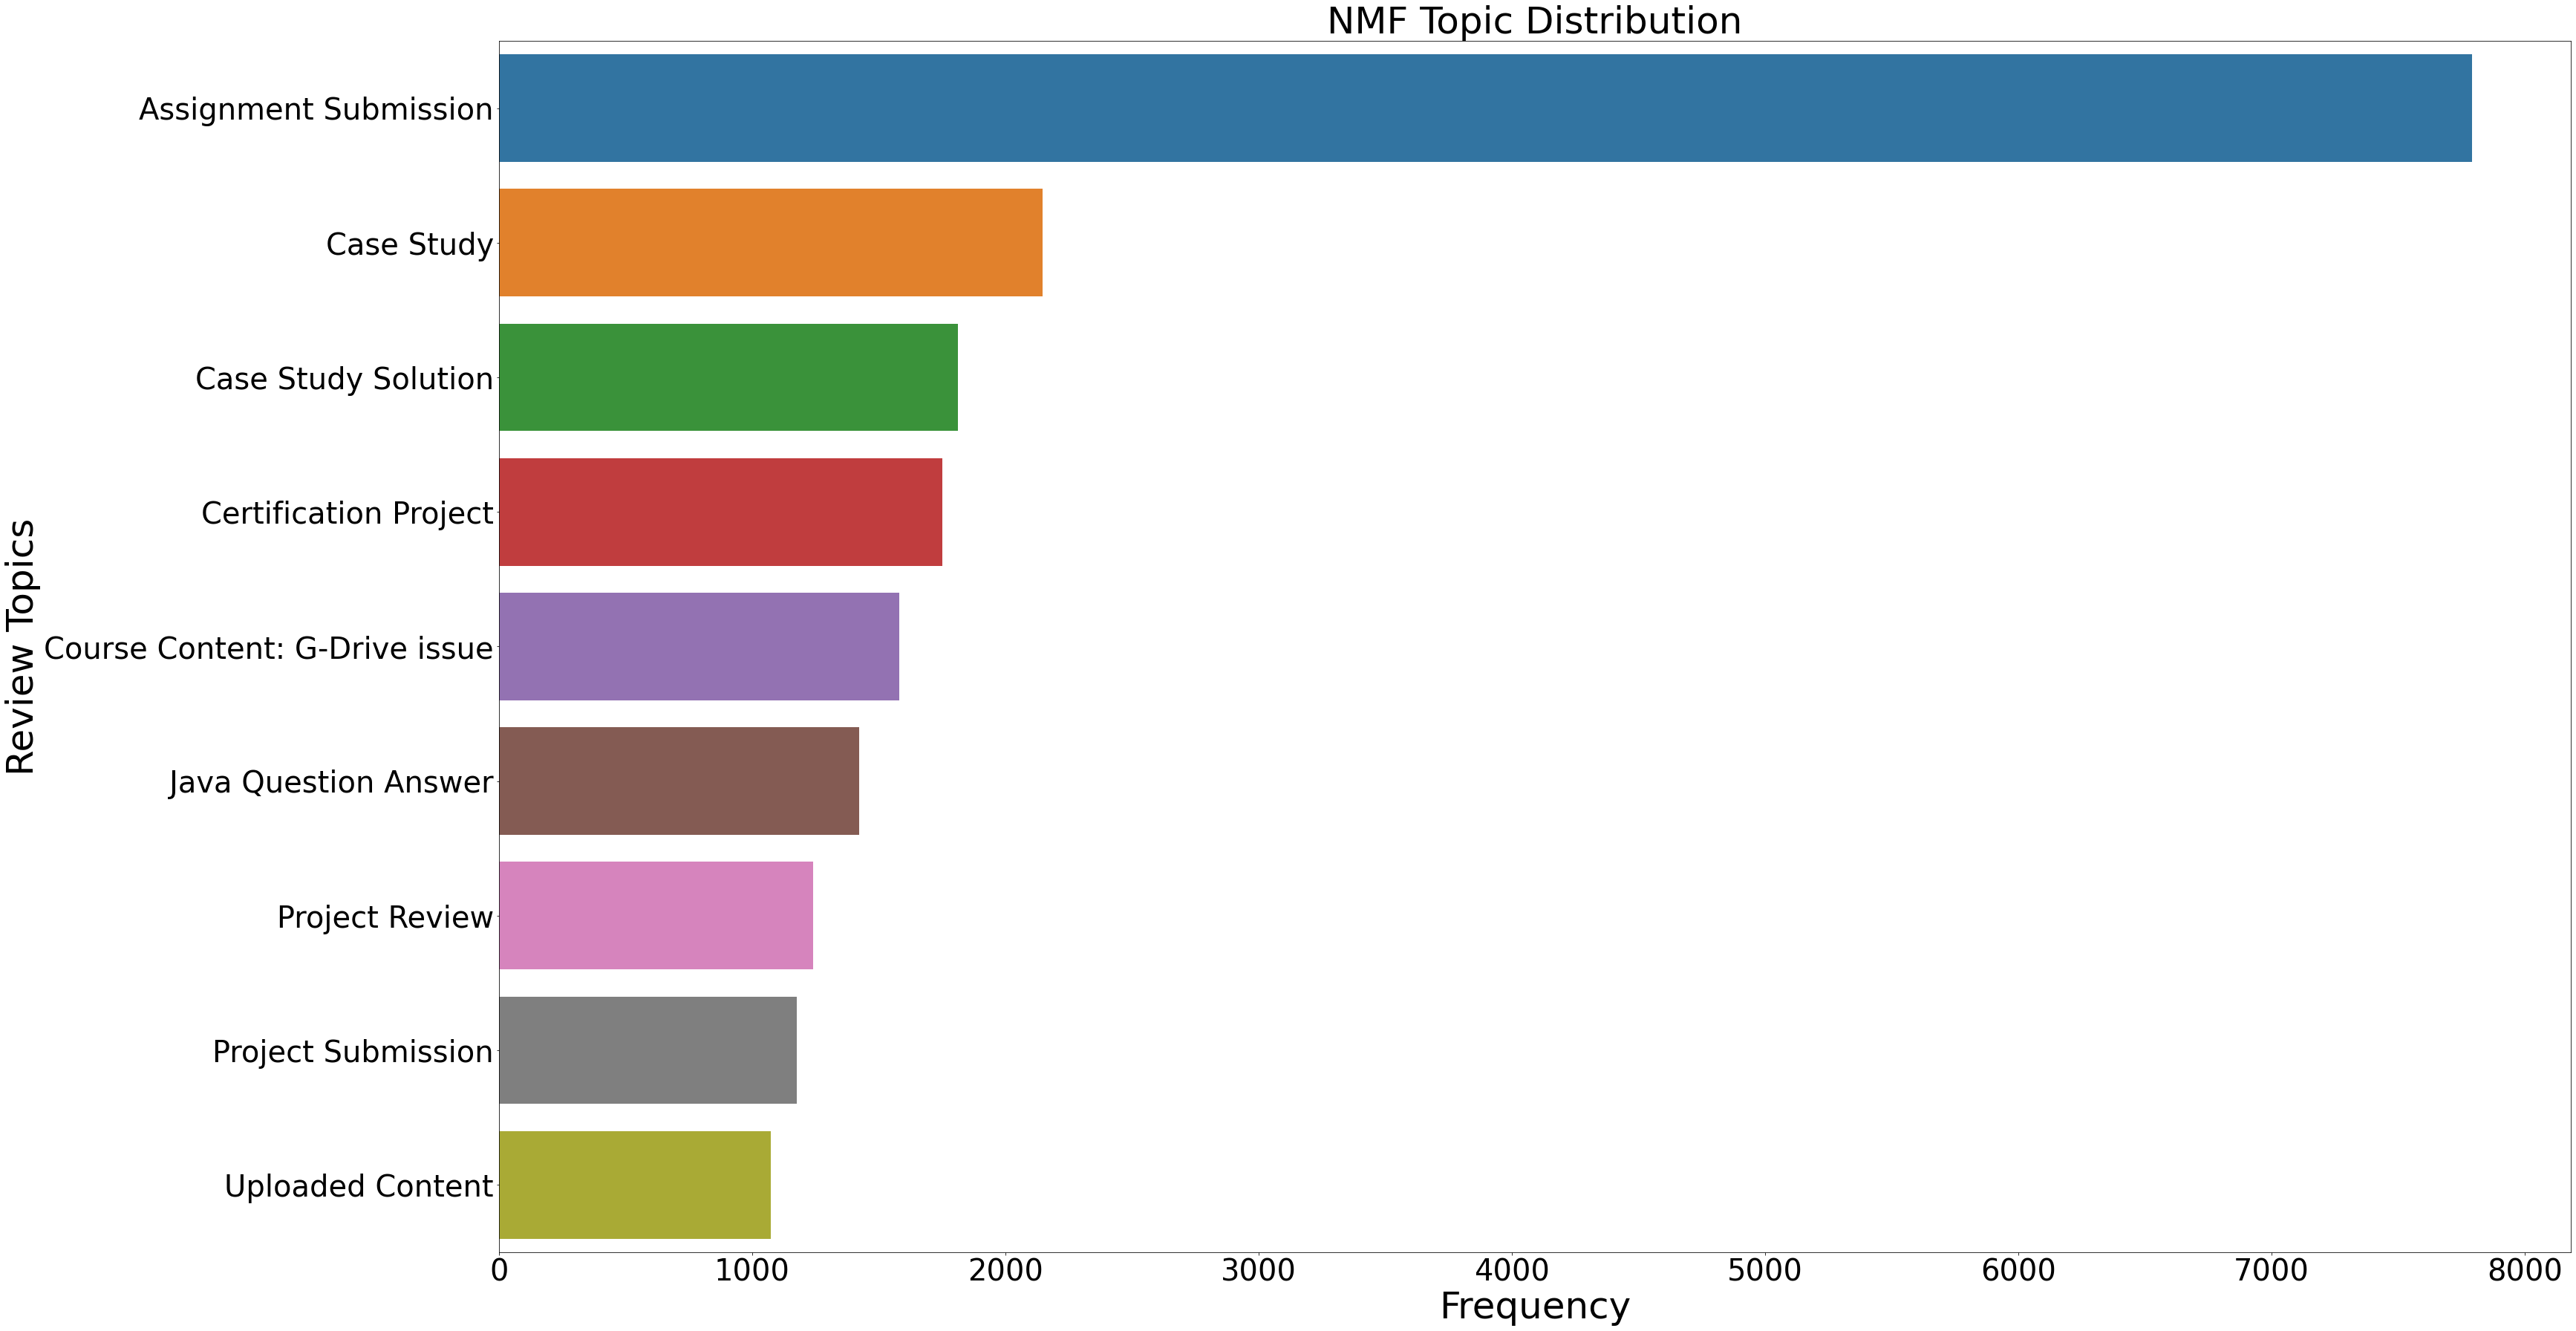

In [256]:
nmf_x = df_40k['nmf_topics'].value_counts()
nmf_y = nmf_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_x, nmf_y.index)
plt.title("NMF Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

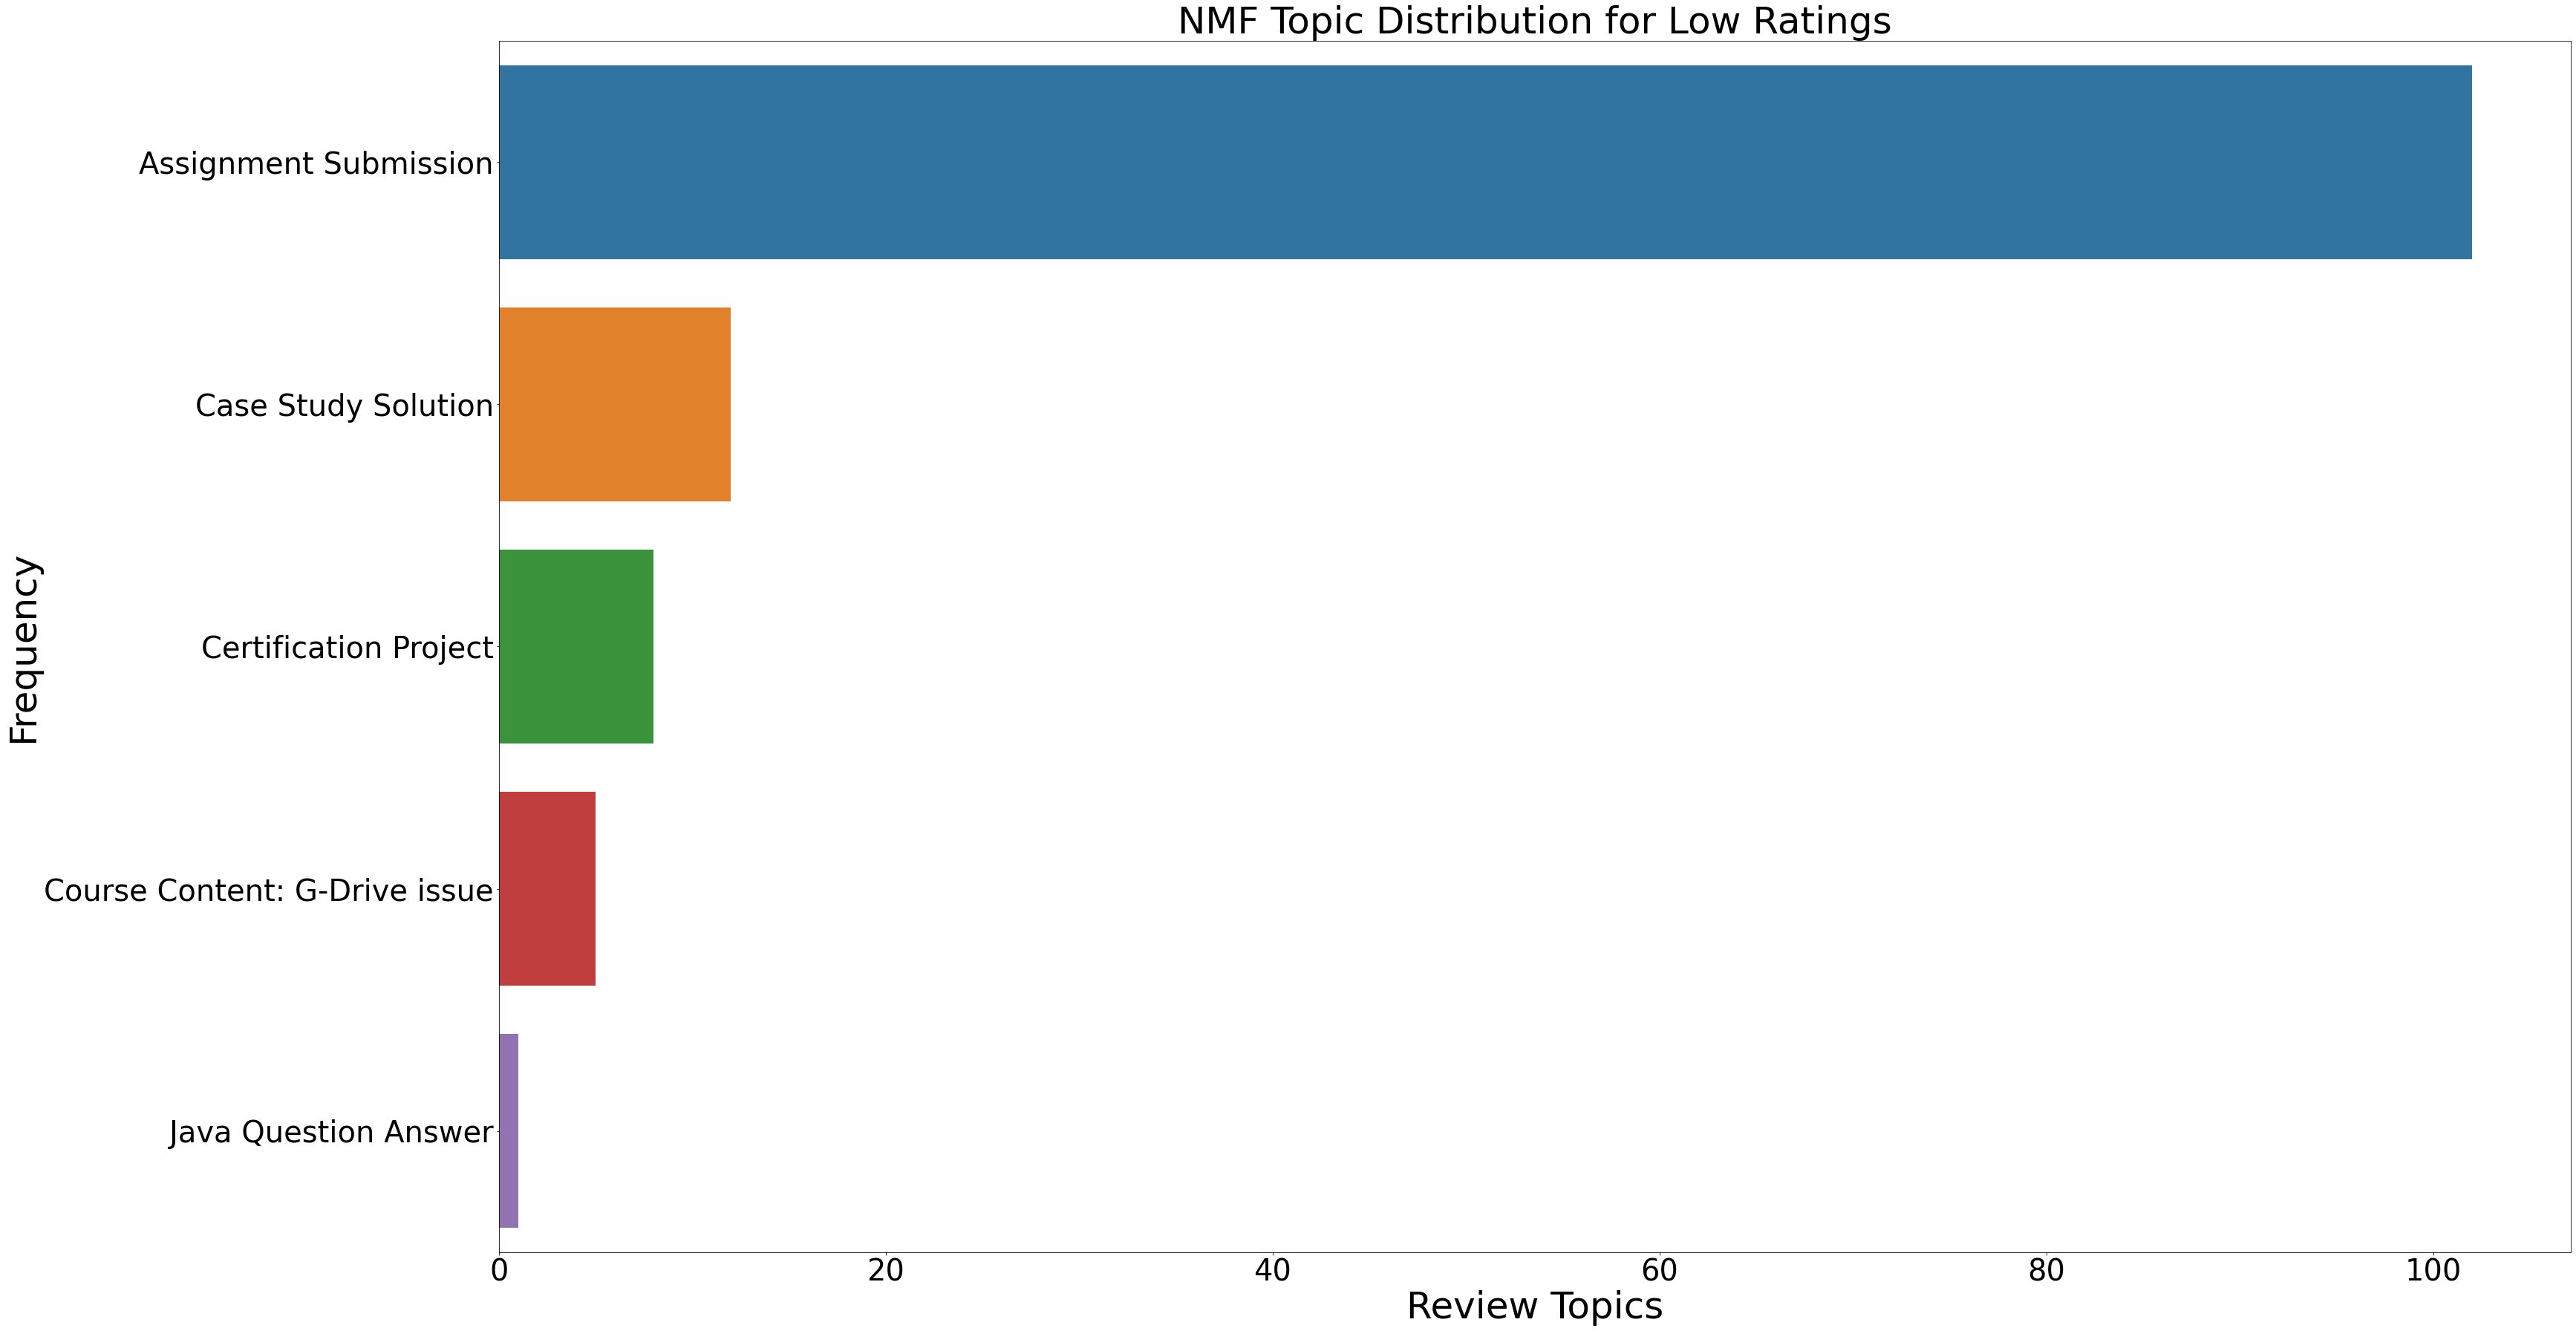

In [257]:
df_low_ratings = df_40k.loc[(df_40k['happiness_rating']=="Bad")]
nmf_low_x = df_low_ratings['nmf_topics'].value_counts()
nmf_low_y = nmf_low_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_low_x, nmf_low_y.index)
plt.title("NMF Topic Distribution for Low Ratings", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

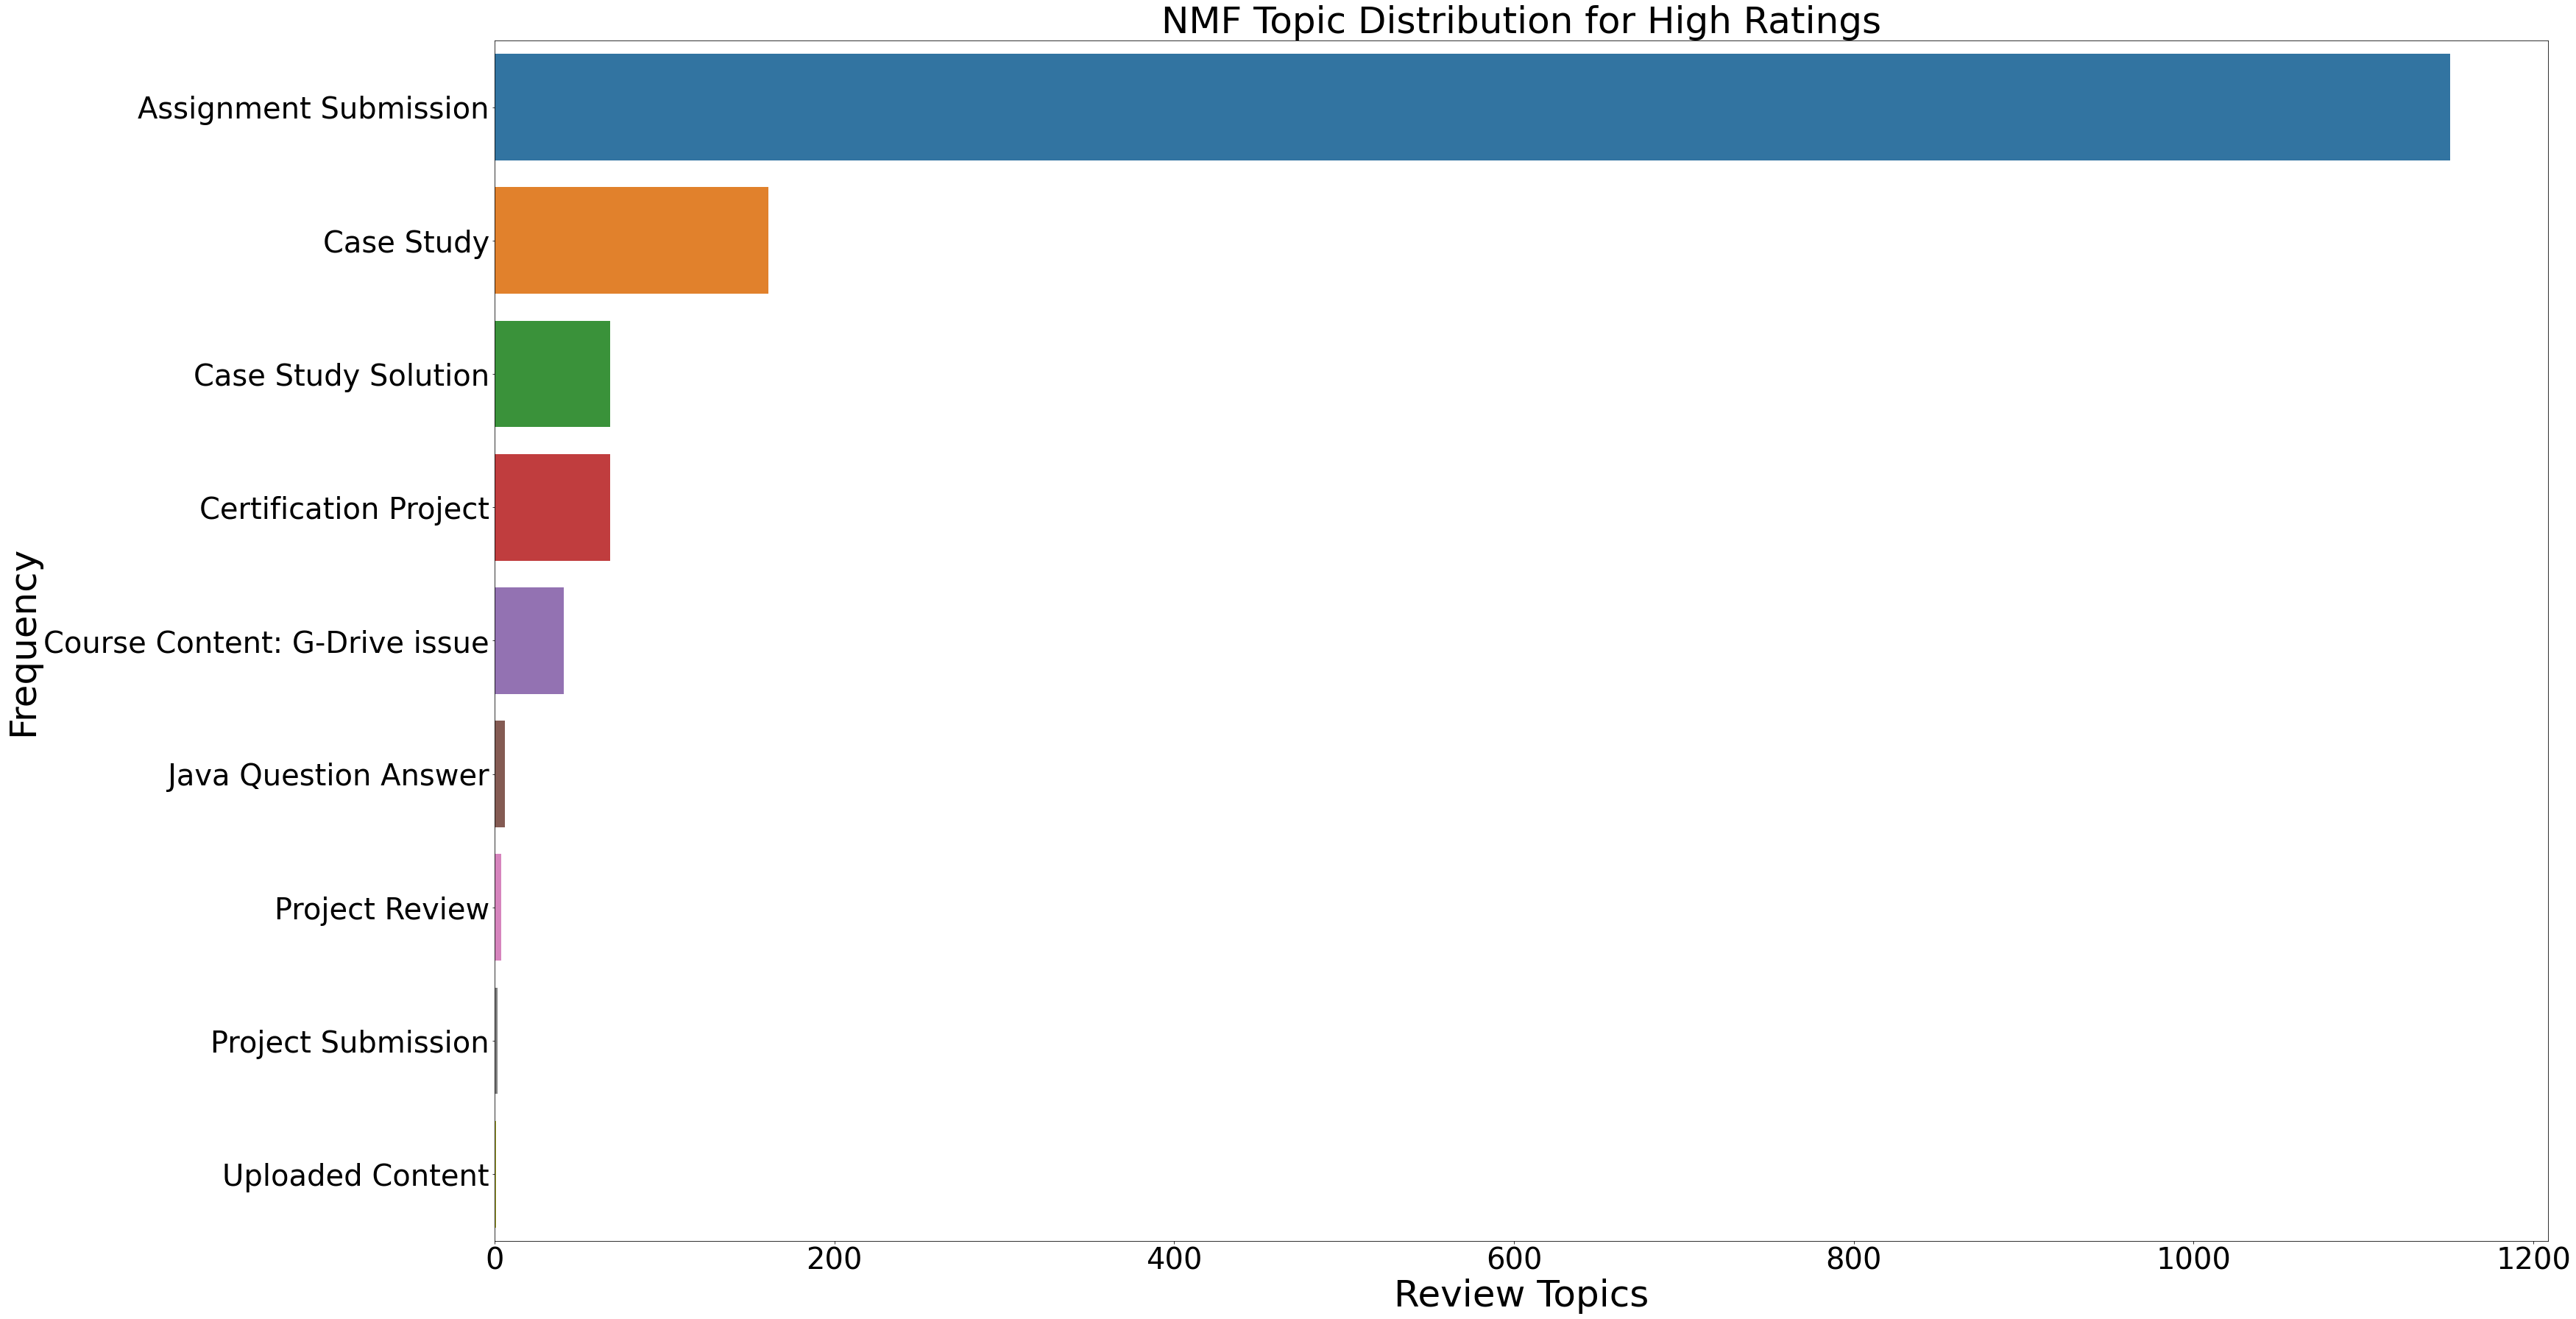

In [258]:
df_high_ratings = df_40k.loc[(df_40k['happiness_rating']=="Good")]
nmf_high_x = df_high_ratings['nmf_topics'].value_counts()
nmf_high_y = nmf_high_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_high_x, nmf_high_y.index)
plt.title("NMF Topic Distribution for High Ratings", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)